In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 30 13:54:02 2016

@author: anna
"""
import sys
sys.path.append('/usr/local/lib/python2.7/dist-packages/')

import time
import os
import re
import traceback
import pandas as pd
import mmap
import itertools
import numpy as np
import datetime
from os import listdir
from os.path import isfile, join
import sys, getopt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import logging
logging.getLogger("paramiko").setLevel(logging.WARNING)
from sar import PART_CPU, PART_MEM, PART_SWP, PART_IO, \
    PATTERN_CPU, PATTERN_MEM, PATTERN_SWP, PATTERN_IO, PATTERN_RESTART, \
    FIELDS_CPU, FIELD_PAIRS_CPU, FIELDS_MEM, FIELD_PAIRS_MEM, FIELDS_SWP, \
    FIELD_PAIRS_SWP, FIELDS_IO, FIELD_PAIRS_IO



Required data to access the remote hosts and store the results of analysis

In [2]:
#Username for remote hosts
#Example "annac"
user=""
#Pasword for remote hosts
password=""

#Path to store sar data /home/<user>/tmp/ - is preferable
path="/home/annac/tmp/"#/Users/annachystiakova/Documents/Capacity/sar_analysis/sar_data/"
#Path for subsidiary data of hosts and classes /home/<user>/ - is preferable
source_path="/home/annac/"

Load sysstat data from remote hosts

In [3]:
import paramiko
# The function to parse the input script arguments
def parse_args(argv):
    user = ''
    password = ''
    host = ''
    param = ''
    minsize=''
    try:
        opts, args = getopt.getopt(argv,"u:p:h:v:s:",["user=","password=", "host=", "param=", "size="])
    except getopt.GetoptError:
        print 'argparse_my.py -u <user> -p <password> -h <host>'
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-N':
            print 'argparse_my.py -u <user> -p <password> -h <host>'
            sys.exit()
        elif opt in ("-u", "--user"):
            user = arg
        elif opt in ("-p", "--password"):
            password = arg
        elif opt in ("-h", "--host"):
            host = arg
        elif opt in ("-v", "--param"):
            param = arg
        elif opt in ("-s", "--size"):
            minsize = arg
    return ([user, password, host, param, minsize])

#Copy sar data from remote host
def get_host_data (host, user, password):
    #Create the directory to store data
    if not os.path.exists('/home/'+user+'/tmp'):
        os.makedirs('/home/'+user+'/tmp')
    if not os.path.exists('/home/'+user+'/tmp/'+host):
        os.makedirs('/home/'+user+'/tmp/'+host)
    host=host
    user = user
    password = password
    files_stat=['sar']
    k=1
    paramiko.util.log_to_file('ssh.log') # sets up logging
    client = paramiko.SSHClient()
    client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    client.connect(host+'.etadirect.com', username=user, password=password)
    cmd='uname'
    stdin, stdout, stderr = client.exec_command(cmd)
    out=[x.replace('\n','') for x in stdout]
    print ("OS is:", out)
    if out[0]!=u'Linux':
        return 0
    cmd='ls /var/log/sa/'
    stdin, stdout, stderr = client.exec_command(cmd)
    sars=[x.replace('\n','') for x in stdout if 'sar' in x]
    #print ("Response was:", sars)
    time.sleep(1)
    #print ('Done')

        #Copy file from remote host to local
    port=22
    transport = paramiko.Transport((host+'.etadirect.com', port))
    transport.connect(username = user, password = password)
    sftp = paramiko.SFTPClient.from_transport(transport)
    # Download
    filepath = '/var/log/sa/'
    localpath = '/home/'+user+'/tmp/'+host+'/'
    for sar in sars:
        sftp.get(filepath+sar, localpath+sar)
    client.close()


Get required data from sar

In [4]:
def _split_file(self, data=''):
    '''
    Splits SAR output or SAR output file (in ASCII format) in order to
    extract info we need for it, in the format we want.
        :param data: Input data instead of file
        :type data: str.
        :return: ``List``-style of SAR file sections separated by
            the type of info they contain (SAR file sections) without
            parsing what is exactly what at this point
    '''

    # Filename passed checks through __init__
    if ((self and os.access(self, os.R_OK))
        or data != ''):

        fhandle = None

        if (data == ''):
            try:
                fhandle = os.open(self, os.O_RDONLY)
            except OSError:
                print(("Couldn't open file %s" % (self.__filename)))
                fhandle = None

        if (fhandle or data != ''):

            datalength = 0
            dataprot = mmap.PROT_READ

            if (data != ''):
                fhandle = -1
                datalength = len(data)
                dataprot = mmap.PROT_READ | mmap.PROT_WRITE

            try:
                sarmap = mmap.mmap(
                    fhandle, length=datalength, prot=dataprot
                )
                if (data != ''):
                    sarmap.write(data)
                    sarmap.flush()
                    sarmap.seek(0, os.SEEK_SET)

            except (TypeError, IndexError):
                if (data == ''):
                    os.close(fhandle)
                traceback.print_exc()
                # sys.exit(-1)
                return False

            # Here we'll store chunks of SAR file, unparsed
            searchunks = []
            oldchunkpos = 0

            dlpos = sarmap.find(b"\n\n", 0)
            size = 0

            if (data == ''):
                # We can do mmap.size() only on read-only mmaps
                size = sarmap.size()
            else:
                # Otherwise, if data was passed to us,
                # we measure its length
                len(data)

            # oldchunkpos = dlpos

            while (dlpos > -1):  # mmap.find() returns -1 on failure.

                tempchunk = sarmap.read(dlpos - oldchunkpos)
                searchunks.append(tempchunk.strip())

                # We remember position, add 2 for 2 DD's
                # (newspaces in production). We have to remember
                # relative value
                oldchunkpos += (dlpos - oldchunkpos) + 2

                # We position to new place, to be behind \n\n
                # we've looked for.
                try:
                    sarmap.seek(2, os.SEEK_CUR)
                except ValueError:
                    print(("Out of bounds (%s)!\n" % (sarmap.tell())))
                # Now we repeat find.
                dlpos = sarmap.find(b"\n\n")

            # If it wasn't the end of file, we want last piece of it
            if (oldchunkpos < size):
                tempchunk = sarmap[(oldchunkpos):]
                searchunks.append(tempchunk.strip())

            sarmap.close()

        if (fhandle != -1):
            os.close(fhandle)

        if (searchunks):
            return searchunks
        else:
            return False

    return False


def get_values(s, di):
    df = {}
    if s is None:
        return df
    s = s.split()
    if s[0] == 'Average:':
        df['time'] = s[0]
        for k, v in di.items():
            df[k] = s[(int(v) - 1)]
    else:
        df['time'] = ' '.join([':'.join([s[0].split(':')[0], s[0].split(':')[1], "00"]), s[1]])

        for k, v in di.items():
            pattern_re = re.compile(k)
            if (pattern_re.search(s[v])):
                df[k] = np.nan
            else:
                df[k] = s[v]

    return (df)


def data_ind(part_parts, FIELDS_CPU):
    return_dict = {}
    counter = 0
    for piece in part_parts:
        for colname in FIELDS_CPU:
            pattern_re = re.compile(colname)
            if (pattern_re.search(piece)) and piece == colname.replace("\\", ""):
                return_dict[colname.replace("%", "").replace("\\", "")] = counter
                # print(piece)
                break
        counter += 1
    return return_dict


def get_data(S):
    cpu_pattern = re.compile('.*CPU.*(usr|user).*nice.*sys.*')
    mem_pattern = re.compile(PATTERN_MEM)
    swp_pattern = re.compile(PATTERN_SWP)
    io_pattern = re.compile(PATTERN_IO)
    #PATTERN_IO_P = ['DEV', '^tps', '^rd_sec\\/s', '^wr_sec\\/s', 'avgrq-sz', 'avgqu-sz', 'await', 'svctm', '\\%util']
    PATTERN_IO_P = '.*tps.*rd_sec\/s.*wr_sec\/s.*avgrq-sz.*avgqu-sz.*await.*svctm.*\%util.*'
    io_pattern_p=re.compile(PATTERN_IO_P)
    restart_pattern = re.compile(PATTERN_RESTART)
    iface_pattern = re.compile('.*IFACE.*rxerr.*txerr.*coll.*rxdrop.*txdrop.*txcarr.*rxfram.*rxfifo.*txfifo.*')
    di = {}
    dm = {}
    df = {}
    io = {}
    iop={}
    FIELDS_MEM= ['kbmemfree', 'kbmemused', '\\%memused', 'kbbuffers', 'kbcached', 'kbcommit','\\%commit']
    FIELDS_CPU = ['CPU', '\\%usr', '\\%nice', '\\%sys', '\\%iowait', '\\%idle']
    FIELDS_IFACE = ['IFACE', 'rxerr/s', 'txerr/s', 'coll/s', 'rxdrop/s', 'txdrop/s', 'txcarr/s', 'rxfram/s', 'rxfifo/s',
                    'txfifo/s']
    FIELDS_IOPS = ['tps', 'rtps', 'wtps', 'bread/s', 'bwrtn/s']
    FIELDS_IOPS_PERC = ['DEV', 'tps', 'rd_sec/s', 'wr_sec/s', 'avgrq-sz', 'avgqu-sz', 'await', 'svctm','\\%util']

    CPU = list()
    MEM = list()
    IF = list()
    IO = list()
    IOP = list()
    for k in range(len(S)):

        D = (S[k].decode().split('\n'))
        part = D[0]
        if (cpu_pattern.search(part)):
            if len(di) == 0:
                part_parts = part.split()
                di = data_ind(part_parts, FIELDS_CPU)
            CPUn = []
            for dd in D:
                CPUn.append(get_values(dd, di))
            # CPUn=list(map(get_values, D, itertools.repeat(di)))
            CPU.extend(CPUn)
        elif (mem_pattern.search(part)):
            if len(dm) == 0:
                part_parts = part.split()
                dm = data_ind(part_parts, FIELDS_MEM)
            MEMn = []
            for dd in D:
                MEMn.append(get_values(dd, dm))
            MEM.extend(MEMn)
        elif (iface_pattern.search(part)):
            if len(df) == 0:
                part_parts = part.split()
                df = data_ind(part_parts, FIELDS_IFACE)
            IFn = []
            for dd in D:
                IFn.append(get_values(dd, df))
            IF.extend(IFn)
        elif (io_pattern.search(part)):
            if len(io) == 0:
                part_parts = part.split()
                io = data_ind(part_parts, FIELDS_IOPS)
            IOn = []
            for dd in D:
                IOn.append(get_values(dd, io))
            IO.extend(IOn)
        elif (io_pattern_p.search(part)):
            if len(iop) == 0:
                part_parts = part.split()
                iop = data_ind(part_parts, FIELDS_IOPS_PERC)
            IOPn = []
            for dd in D:
                IOPn.append(get_values(dd, iop))
            IOP.extend(IOPn)

    return (CPU, MEM, IF, IO, IOP)

def modification_date(filename):
    t = os.path.getmtime(filename)
    return datetime.datetime.fromtimestamp(t)

def get_resource_tables(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    pattern_res = re.compile('sar\\d{2}')
    DFR = pd.DataFrame()
    DMR = pd.DataFrame()
    IFR = pd.DataFrame()
    IOR = pd.DataFrame()
    IOPR = pd.DataFrame()
    dr=re.compile('(\d+-\d+-\d+)')
    for o in onlyfiles:
        if (o.replace("sar", "")).isdigit():
            sarfile = join(mypath, o)
            with open(sarfile, 'r') as f:
                first_line=f.readline()
            dd=dr.findall(first_line)    
            if len(dd)==1:
                dd=str(dd[0])
            else:
                raise ValueError("Cannot define the date in line  ", s)
            S = _split_file(sarfile)
            FF, MEM, IF, IO, IOP = get_data(S)
            DF = pd.DataFrame(FF)
            DM = pd.DataFrame(MEM)
            IF = pd.DataFrame(IF)
            IO = pd.DataFrame(IO)
            IOP = pd.DataFrame(IOP)
            d = datetime.date.today()
                            
            DF.time = DF.time.apply(lambda x: ' '.join([dd, x]))
            DM.time = DM.time.apply(lambda x: ' '.join([dd, x]))
            IF.time = IF.time.apply(lambda x: ' '.join([dd, x]))
            IO.time = IO.time.apply(lambda x: ' '.join([dd, x]))
            IOP.time = IOP.time.apply(lambda x: ' '.join([dd, x]))
            
            DF = DF.dropna()
            DM = DM.dropna()
            IF = IF.dropna()
            IO = IO.dropna()
            IOP = IOP.dropna()

            DFR = DFR.append(DF, ignore_index=True)
            DMR = DMR.append(DM, ignore_index=True)
            IFR = IFR.append(IF, ignore_index=True)
            IOR = IOR.append(IO, ignore_index=True)
            IOPR = IOPR.append(IOP, ignore_index=True)

    import time
    start = time.time()

    DFR['idle'] = DFR['idle'].apply(float)
    DFR['used_cpu'] = 100-DFR['idle']
    
    l = 'Average:'
    DFR_Average = DFR[DFR.time.apply(lambda v: True if l in v else False)]#= DFR.loc[DFR.index.map(lambda v: True if l in v else False)]
    DFR = DFR[DFR.time.apply(lambda v: False if l in v else True)]

    DMR['memused'] = DMR['memused'].apply(float)
    DMR_Average = DMR[DMR.time.apply(lambda v: True if l in v else False)]
    DMR = DMR[DMR.time.apply(lambda v: False if l in v else True)]

    IFR['rxerr/s'] = IFR['rxerr/s'].apply(float)
    IFR_Average = IFR[IFR.time.apply(lambda v: True if l in v else False)]
    IFR = IFR[IFR.time.apply(lambda v: False if l in v else True)]
    IFR.columns =['Network_interface','CollisionN','Received_dropped_packets','Bad_packets','FIFO_overrun_errors', 'Frame_alignment_errors', 'time','Carrier_errors', 'Transmitted_dropped_packets', 'Errors_transmit_packets', 'FIFO_overrun_errors']


    IOR['tps'] = IOR['tps'].apply(float)
    IOR_Average = IOR[IOR.time.apply(lambda v: True if l in v else False)]
    IOR = IOR[IOR.time.apply(lambda v: False if l in v else True)]

    IOPR = IOPR[IOPR.time.apply(lambda v: False if l in v else True)]

    DFR.to_csv(mypath + "/cpu_data.csv", index=False)
    DMR.to_csv(mypath + "/mem_data.csv", index=False)
    IFR.to_csv(mypath + "/net_errors_data.csv", index=False)
    IOR.to_csv(mypath + "/io_data.csv", index=False)
    IOPR.to_csv(mypath + "/io_perc_data.csv", index=False)




# Capacity estimation. Forecast

In [79]:

'''The function is desighned to analyse the resourse 
    utilization based on clusterization and linear models of trend.
    Use the R function to detect last period of homogeneous structure
'''

import rpy2.interactive as r
import rpy2.interactive.packages # this can take few seconds
rlib = r.packages.packages
r.packages.importr("utils")
#rlib.utils.install_packages("devtools")
from rpy2.robjects.packages import importr
devtools=importr('devtools')
devtools.install_github(repo="BreakoutDetection", username="twitter")
import sklearn
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.pyplot as plt

""" median filtering """
def get_median_filtered(signal, threshold=3):
    """
    signal: is numpy array-like
    returns: signal, numpy array
    """
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    s = [0 if median_difference == 0 else dd / float(median_difference) for dd in difference]
    mask = [ss > threshold for ss in s]
    signal = [np.median(signal) if mask[i] else signal[i] for i in range(len(signal))]
    return signal

def get_avg_filtered(signal, threshold=3):
    """
    signal: is numpy array-like
    returns: signal, numpy array
    """
    difference = np.abs(signal - np.median(signal))
    median_difference = np.average(difference)
    s = [0 if median_difference == 0 else dd / float(median_difference) for dd in difference]
    mask = [ss > threshold for ss in s]
    signal = [np.average(signal) if mask[i] else signal[i] for i in range(len(signal))]
    return signal


def get_util(test, index, plot_clust, min_clust_size=0.1):
    #print(min_clust_size)
    clust_n=6
    if len(set(test)) < clust_n:
        test_h = test
        inds = range(len(test_h))
    else:
        km = KMeans(clust_n)
        #print("Get utilized")
        x=StandardScaler().fit_transform(np.array(test).reshape(-1,1))
        km.fit(np.array(x).reshape(len(x), 1), clust_n)
        clust = km.predict(np.array(x).reshape(len(test), 1))
        #print("Sihoette distance for "+str(clust_n)+" clusters is")
        #print(sklearn.metrics.silhouette_score(np.array(x).reshape(len(x), 1), clust))
        val = [np.argmax(km.cluster_centers_)]
        inds = [int(x) for x in range(len(clust)) if clust[x] in val]
        test_h = [test[i] for i in inds]#test[inds]
        clust_cent = km.cluster_centers_

        # while len(test_h) < min_clust_size * len(test):
        #    if len(np.unique(clust_cent[0])) == 1  and (np.unique(clust_cent[0])[0] == 0 or np.unique(clust_cent[0])[0] < 0):
        #        test_h = test
        #        inds = range(len(test_h))
        #        break
        #    clust_cent[val] = 0
        #    val.append(np.argmax(clust_cent))
        #    inds = [int(x) for x in range(len(clust)) if clust[x] in val]
        #    test_h = [test[i] for i in inds] 
        while len(test_h) < min_clust_size * len(test):
            #print("High load data length "+str(len(test_h)))
            #print(type(np.ravel(clust_cent)))
            #print(np.ravel(clust_cent))
            #print(((np.ravel(clust_cent))<=0).all())
            #print(len(test_h))
            if ((np.ravel(clust_cent))<=0).all():
                test_h = test
                inds = range(len(test_h))
                break
            clust_cent[val] = 0
            val.append(np.argmax(clust_cent))
            inds = [int(x) for x in range(len(clust)) if clust[x] in val]
            test_h = [test[i] for i in inds] 
            # print(len(test_h))
    if plot_clust:
        plt.figure()
        plt.scatter(index,test)
        #plt.plot(test)
        plt.scatter(x=[index[i] for i in inds], y=test_h, color='red')
        plt.show()
        plt.clf()
    test_h = get_median_filtered(test_h)
    return max(test_h)
 
def last_period_forecast(data, min_size, min_clust_size=0.1):
    #print(min_clust_size)
    BreakoutDetection = importr('BreakoutDetection')
    base = importr('base')
    data2 = [x for x in data]
    data3 = data2
    points = []
    #print("Length of input data "+str(len(data3)))
    #print("min size"+str(min_size))
    while len(data3) > min_size:
        breaks = BreakoutDetection.breakout(base.as_numeric(data3), min_size)
        #print("Length of data is "+str(len(data3)))
        #print(breaks[0])
        if int(np.asarray(breaks[0])[0]) == 0:
            if len(points)==0:
                points=[0]
            break
        if len(points) > 0:
            points.append(int(np.asarray(breaks[0])[0]) + points[len(points) - 1])
        else:
            points = [int(np.asarray(breaks[0])[0])]
        data3 = data3[int(np.asarray(breaks[0])[0]):]

    #print(points)
    #print(len(data))
    test = data[points[len(points) - 1]:]
    i = 1
    while len(test) < min_size:
        test = data[points[len(points) - i]:]
        i=i+1
        
    clust_n=6

    if len(set(test))<clust_n:
        test_h=test
        inds=range(len(test_h))
    else:
        km = KMeans(clust_n)
        #print("Forecast")
        x=StandardScaler().fit_transform(test.reshape(-1,1))
        km.fit(np.array(x).reshape(len(x), 1), clust_n)
        clust = km.predict(np.array(x).reshape(len(x), 1))
        #print(km.cluster_centers_)
        val = [np.argmax(km.cluster_centers_)]
        # print(val)
        inds = [int(x) for x in range(len(clust)) if clust[x] in val]
        test_h = [test[i] for i in inds]  # test[inds]
        clust_cent = km.cluster_centers_
        
        #print(len(test_h))

        while len(test_h) < min_clust_size * len(test):
            #if any(np.ravel(clust_cent))<=0:
            if ((np.ravel(clust_cent))<=0).all():
                test_h = test
                inds = range(len(test_h))
                break
            clust_cent[val] = 0
            val.append(np.argmax(clust_cent))
            inds = [int(x) for x in range(len(clust)) if clust[x] in val]
            test_h = test[inds]
            # print(len(test_h))
        #print(len(test_h))
    test_h = get_median_filtered(test_h)
    #test_h=get_avg_filtered(test_h)
    #print("Test H is calculated")

    lr1 = LinearRegression()
    # if param == 'used_cpu':
    #    test_h = [np.float16(x) for x in test_h]
    lr1.fit(np.array(inds).reshape(len(inds), 1), np.array(test_h).reshape(len(test_h), 1))
    # predict for 1 week L =2016
    X = np.array(range(max(inds), (max(inds) + 1008)))
    res = lr1.predict(X.reshape(len(X), 1))
    res = [x for x in res.ravel()]
    
    lr2 = LinearRegression()
    data_ind=range(len(test))
    lr2.fit(np.array(data_ind).reshape(len(data_ind), 1), np.array(test).reshape(len(test), 1))
    X = np.array(range(max(data_ind), (max(data_ind) + 1008)))
    pred_data = lr2.predict(X.reshape(len(X), 1))
    pred_data = [x for x in pred_data.ravel()]
    
    res=[max(res[i],pred_data[i]) for i in range(len(res))]

    return res, np.std(test_h), points[len(points) - 1]


def forecast_on_sar(host, user, min_size=566, start=0, plot_clust=True):
    #ID = pd.DataFrame({'kbmemused': "mem_data", "used_cpu": "cpu_data", "bread/s": "io_data",
    #                   "bwrtn/s": "io_data"}, index=range(1))
    ID = pd.DataFrame({'kbmemused': "mem_data", "used_cpu": "cpu_data", "bread/s": "io_data",
                       "bwrtn/s": "io_data"}, index=range(1))
    npl = 221
    my_dpi = 80
    #fig1 = plt.figure()
    fig1 = plt.figure(0, figsize=(2000 / my_dpi, 900 / my_dpi), dpi=my_dpi)
    ncores=0
    ram=0
    D=pd.DataFrame()
    # for input_data in ID:
    for param in ID.columns:
        #print(param)
        input_data = ID[param][0]
        mem = pd.read_csv(path+host+"/" + input_data + ".csv", index_col=False)
        if start>0:
            mem=mem[mem.time>start]
        #print(mem.head())
        #print(input_data)
        if input_data=="cpu_data":
            ncores=(len(pd.unique(mem['CPU']))-1)
            mem2=mem[mem['CPU']!="all"]
            mem2.index = pd.DatetimeIndex(mem2.time)
            mem2 = mem2.sort_index()
            dm=mem2.groupby(mem2.index)[param].sum()
            data = dm.values
            min_clust_size=0.01
            util = get_util([x for x in data], dm.index, plot_clust, min_clust_size)
            mem=mem[mem['CPU']=="all"]

            #print("CPU Cores " + str(ncores))
        elif input_data=="mem_data":
            ram=np.float32(mem['kbmemused'].values[0]+mem['kbmemfree'].values[0])
            
            mem['real_kbfree']=mem['kbmemfree']+mem['kbcached']
            mem['real_used']=[(ram-x) for x in mem['real_kbfree']]
            mem.to_csv(path+host+"/memory_calculated.csv")
            param='real_used'
            mem.index = pd.DatetimeIndex(mem.time)
            mem = mem.sort_index()
            dm = mem[param]
            data = dm.values
            util = get_util([x for x in data], dm.index, plot_clust)
            ram=np.ceil(ram/1024/1024)
            D = D.append(pd.DataFrame({"Resource": input_data, "Capacity": ram, "Param":param, "Used": np.ceil(util/1024/1024), "Details":"All data in GB"}, index=[host]))
            #param='kbmemused'
            param='real_used'
            dm = mem[param]
            #dm.index = pd.DatetimeIndex(dm.time)
            dm = dm.sort_index()
            data = dm.values
            min_clust_size=0.1
            util = get_util([x for x in data], dm.index, plot_clust, min_clust_size)

            #print("RAM " + str(ram))
        else:
            mem.index = pd.DatetimeIndex(mem.time)
            mem = mem.sort_index()
            dm = mem[param]
            #dm = dm.sort_index()
            data = dm.values
            min_clust_size=0.1
            util = get_util([x for x in data], dm.index, plot_clust, min_clust_size)
            
        res, stand_dev, point = last_period_forecast(data, min_size, min_clust_size=min_clust_size)
        #print("Utilized "+ str(util))
        #print("forecast_done")
        #print(dm.index)
        
        

    
        res = [np.median(data) if res[i]<min(data) else res[i] for i in range(len(res))]
        
        pred = (pd.Series(res, index=pd.date_range(str(dm.index[dm.shape[0] - 1]), periods=1008, freq='10min')))
        pred.index = pd.to_datetime(pred.index, unit='s')
        RES = pd.concat([dm, pred], axis=0)
        #Lin_model = (pd.Series(pred_data, index=pd.date_range(str(dm.index[dm.shape[0] - 1]), periods=1008, freq='10min')))

        #print("plot_forecast")
        fig1.add_subplot(npl)
        plt.plot(dm.index, dm.values, lw=1, label="Input data", color='blue')
        plt.plot(pred.index, pred.values, lw=2, label="Forecast", color='red', ls='--')
        plt.plot(pred.index, pred.values + 3 * stand_dev, lw=2, label="Forecast with confidence interval",
                 color='orange', ls='--')
        #plt.plot(Lin_model.index, Lin_model.values, lw=2, label="Model of all TS data",
        #         color='green', ls='--')
        plt.fill_between(RES.index[point:len(dm.index) - 1], max(RES), min(RES), \
                         facecolor='yellow', alpha=0.5, \
                         label="last period with uniform structure")
        plt.title("Forecast of " + param + " based on sar")
        plt.legend(loc='upper left',prop={'size':8})
        #print("done")
        npl = npl + 1
        if input_data == "cpu_data":
            #print("Cores %")
            #print(np.float64(ncores)/100)
            D=D.append(pd.DataFrame({"Resource":input_data, "Capacity":ncores,"Param":param,"Used":(str(util)+" %"), "Details":"Used in %. All data ncores*100%"}, index=[host]))
        elif input_data=="mem_data":
            D = D.append(pd.DataFrame({"Resource": input_data, "Capacity": ram, "Param":param,"Used": util/1024/1024, "Details":"All data in GB"}, index=[host]))

    #plt.show(block=False)
    plt.show()
    fig1.show()
    fig1.savefig(path+host+"/Forecast_"+host.replace(".","_")+"_min_period_"+str(min_size), dpi=300)
    #''/home/'+user+'/tmp/'+host + "/Forecast_"+host.replace(".","_")+"_min_period_"+str(min_size), dpi=300)
    fig1.clf()
    return (D)
    



In [111]:
def get_resource_data(group_serv):
    D=pd.DataFrame()
    for G in data.Group.unique():
        if group_serv in G:
            print(G)
            df=pd.DataFrame()
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
            ax0, ax1= axes.flat

            d=DFR_RAM[DFR_RAM.Group==G]
            #print(d)
            D=D.append(d)
            X, Y=d.shape
            ind = np.arange(X)
            width = 0.5
            #d=d[['server','Used', 'Available']]
            p1 = ax0.bar(ind, d.Used.values,  color='red', label='Used_memory_Gb')
            p2 = ax0.bar(ind, d.Available.values, color='green', bottom=d.Used.values, label='Available')
            ax0.set_xticks(range(d.shape[0]))
            ax0.set_xticklabels([str(x) for x in d.server.values], rotation=90)
            ax0.set_title(G+" Memory usage Gb")
            ax0.get_legend()
            ax0.set_xlabel("KB")
            df=df.append(pd.DataFrame({"Group":G, "Number":d.shape[0],"Resource":"Memory","Sum_used":d.Used.sum(),"Sum_capacity":d.Capacity.sum() }, index=['RAM']))


            d=DFR_CPU[DFR_CPU.Group==G]
            D=D.append(d)
            X, Y=d.shape
            ind = np.arange(X)
            width = 0.5
            #d=d[['server','Used', 'Available']]
            d['Used']=np.float16(d['Used'].str.replace(" %", ""))
            p1 = ax1.bar(ind, d.Used.values,  color='red', label='Used_CPU_%')
            p2 = ax1.bar(ind, d.Available.values, color='green', bottom=d.Used.values, label='Available')
            ax1.set_xticks(range(d.shape[0]))
            ax1.set_xticklabels([str(x) for x in d.server.values], rotation=90)
            ax1.set_title(G+" CPU usage %")
            ax1.set_xlabel("%")

            #fig.text(G)
            fig.set_label(G)
            fig.show

            df=df.append(pd.DataFrame({"Group":G, "Number":d.shape[0], "Resource":"CPU","Sum_used":d.Used.sum(),"Sum_capacity":100*d.Capacity.sum() }, index=['CPU']), ignore_index=True)
            print(df)
            print("Summary CPU ")
            print("Used "+str(d.Used.sum()/d.Capacity.sum())+" %")
            print("Summary RAM ")
            print("Used "+str(100*np.float16(df['Sum_used'][df.Resource=='Memory'].values/df.Sum_capacity[df.Resource=='Memory'].values)[0])+" %")
    return D

app101.eta.prod.ed1


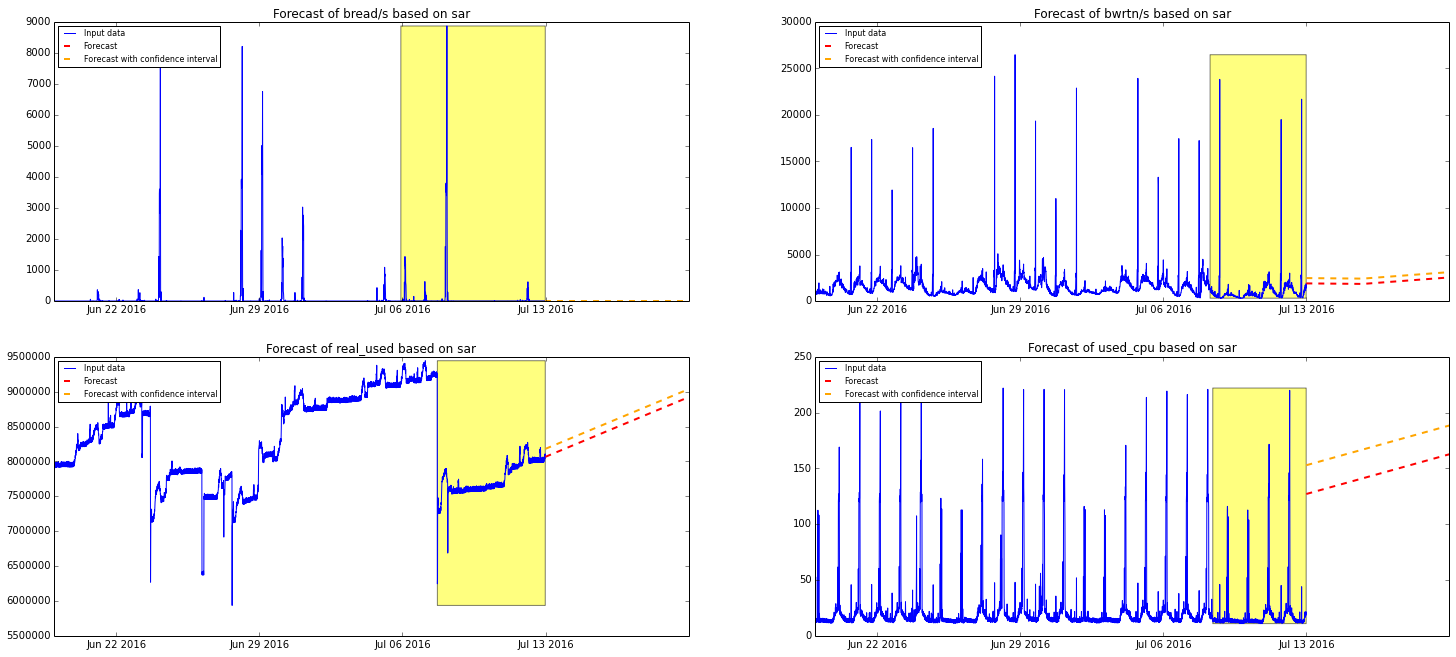

app102.eta.prod.ed1


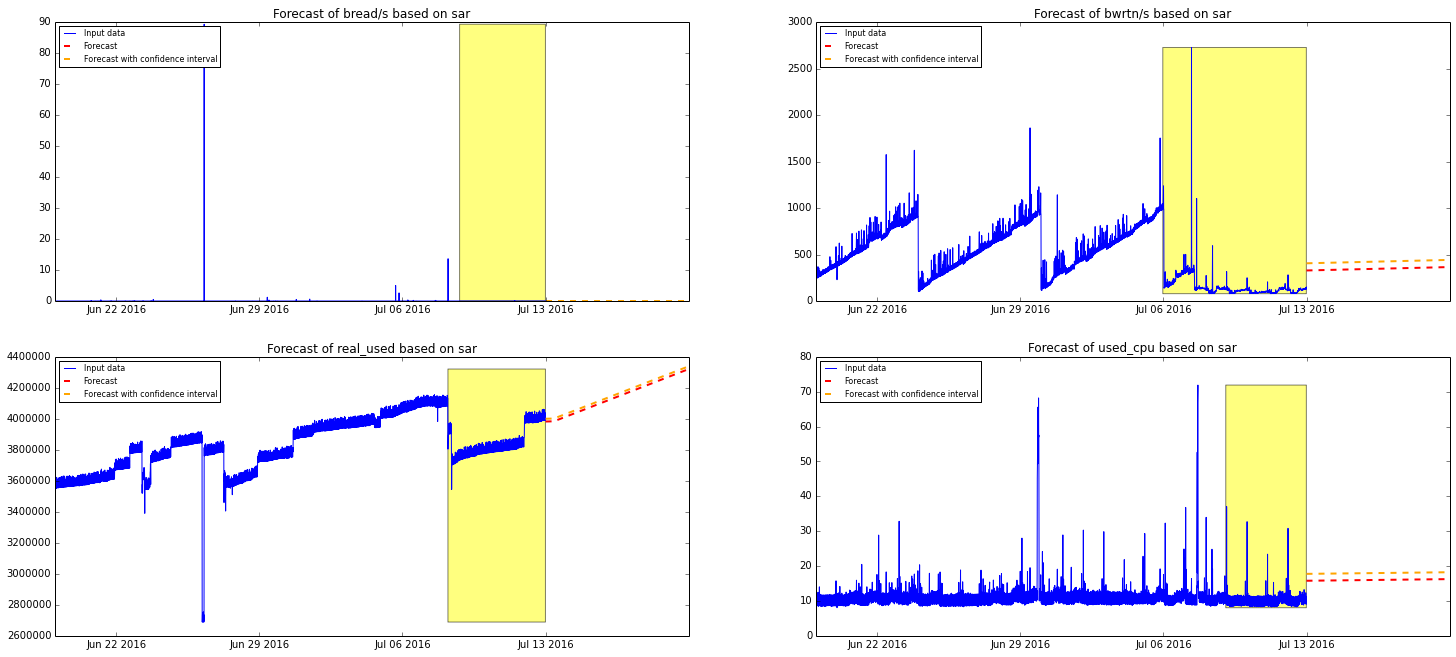

app103.eta.prod.ed1


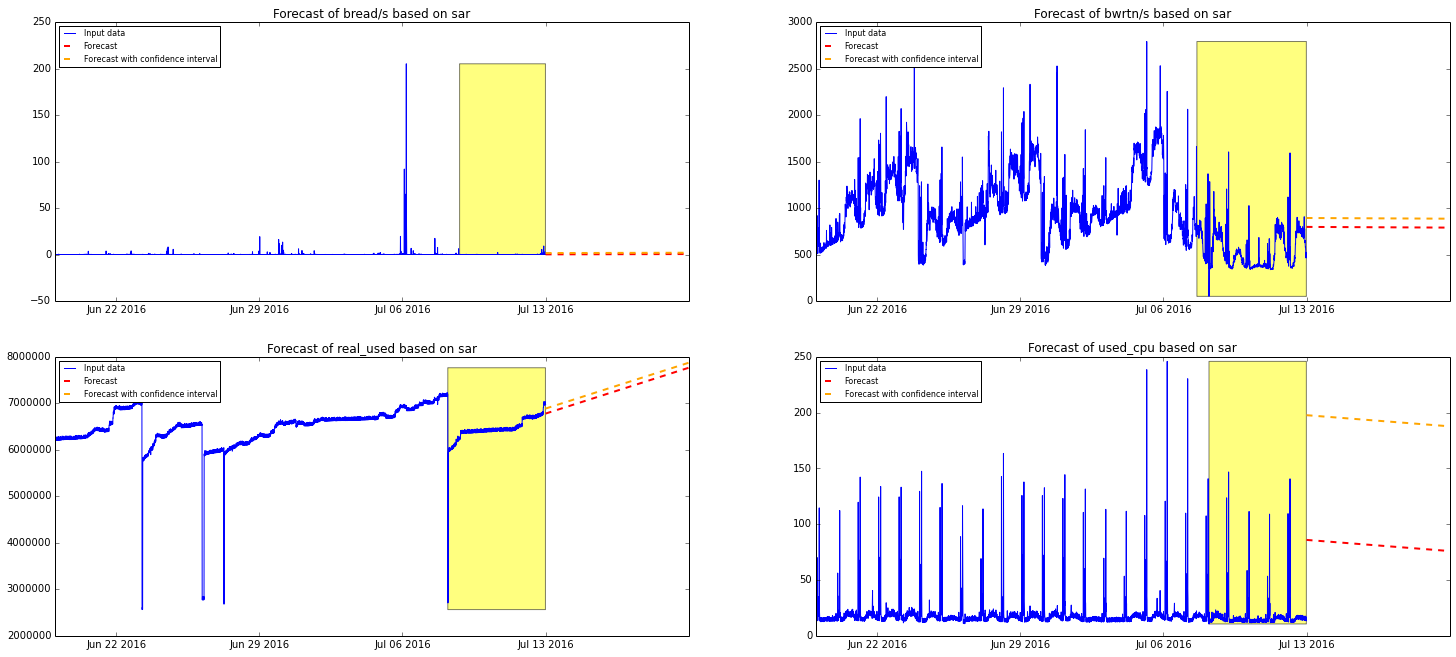

app104.eta.prod.ed1


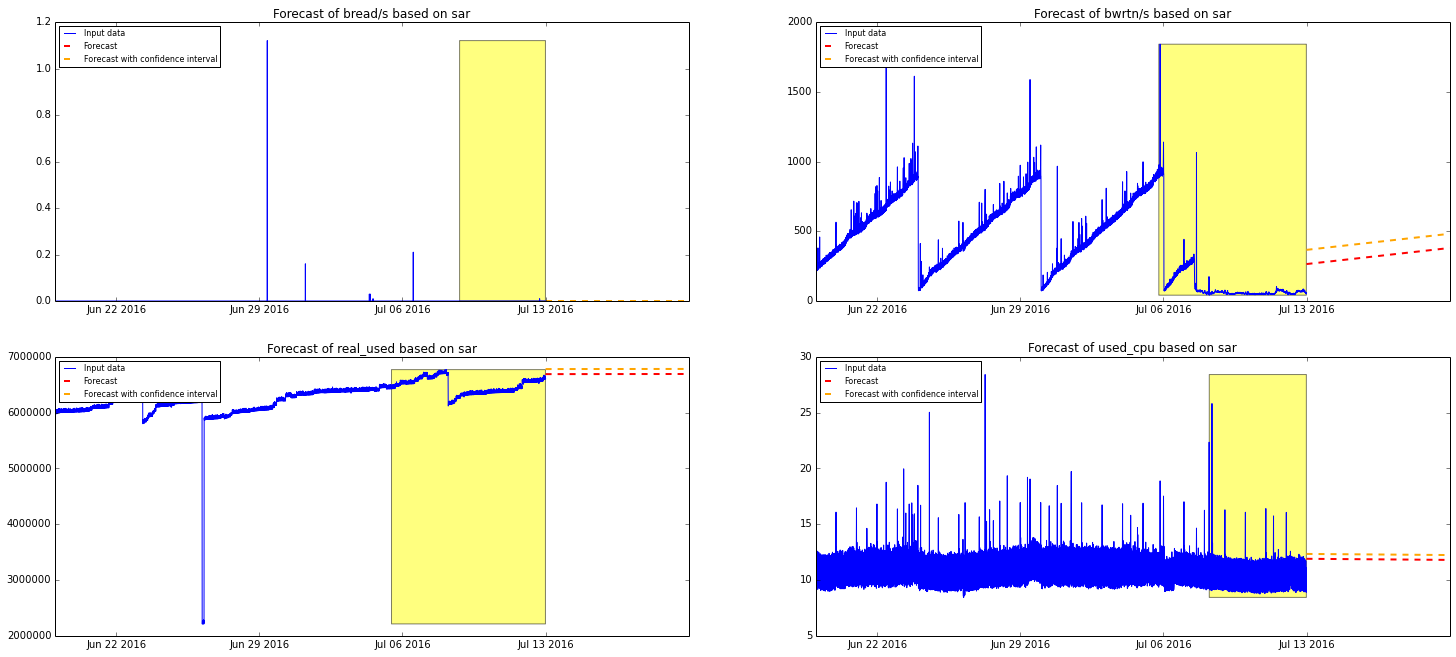

app105.eta.prod.ed1


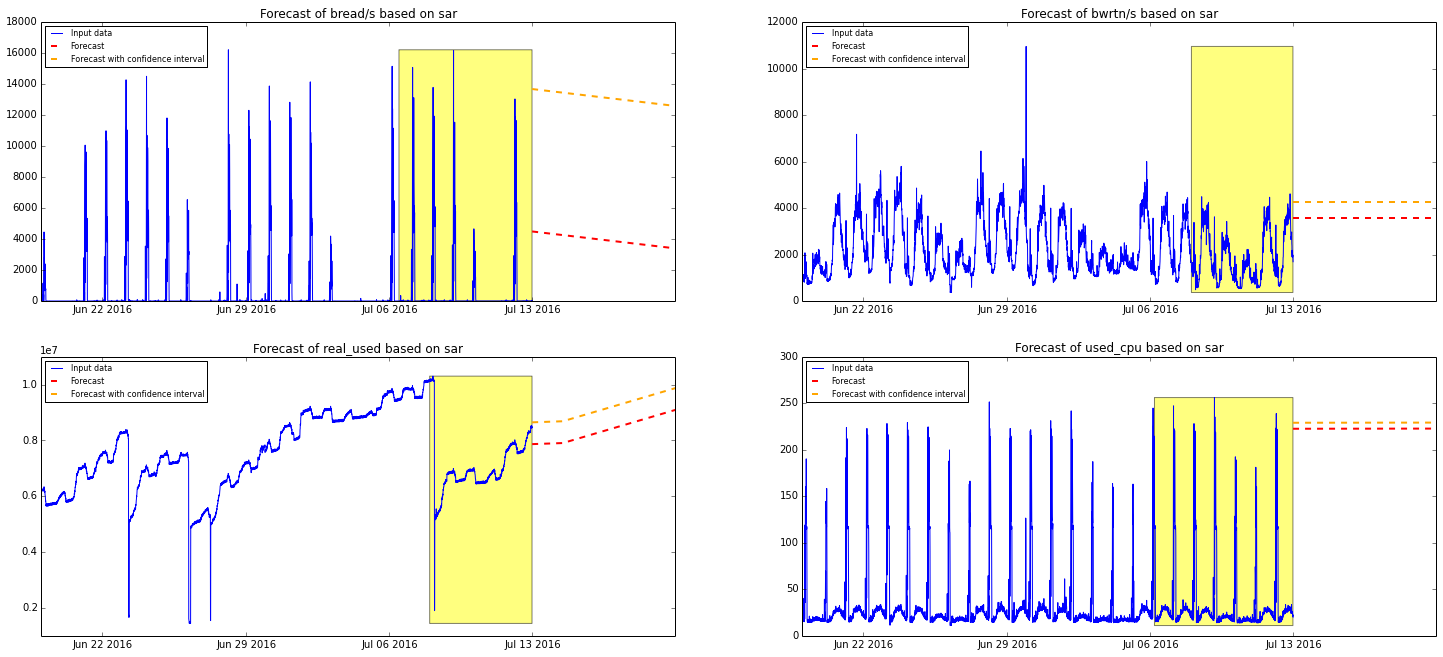

app106.eta.prod.ed1


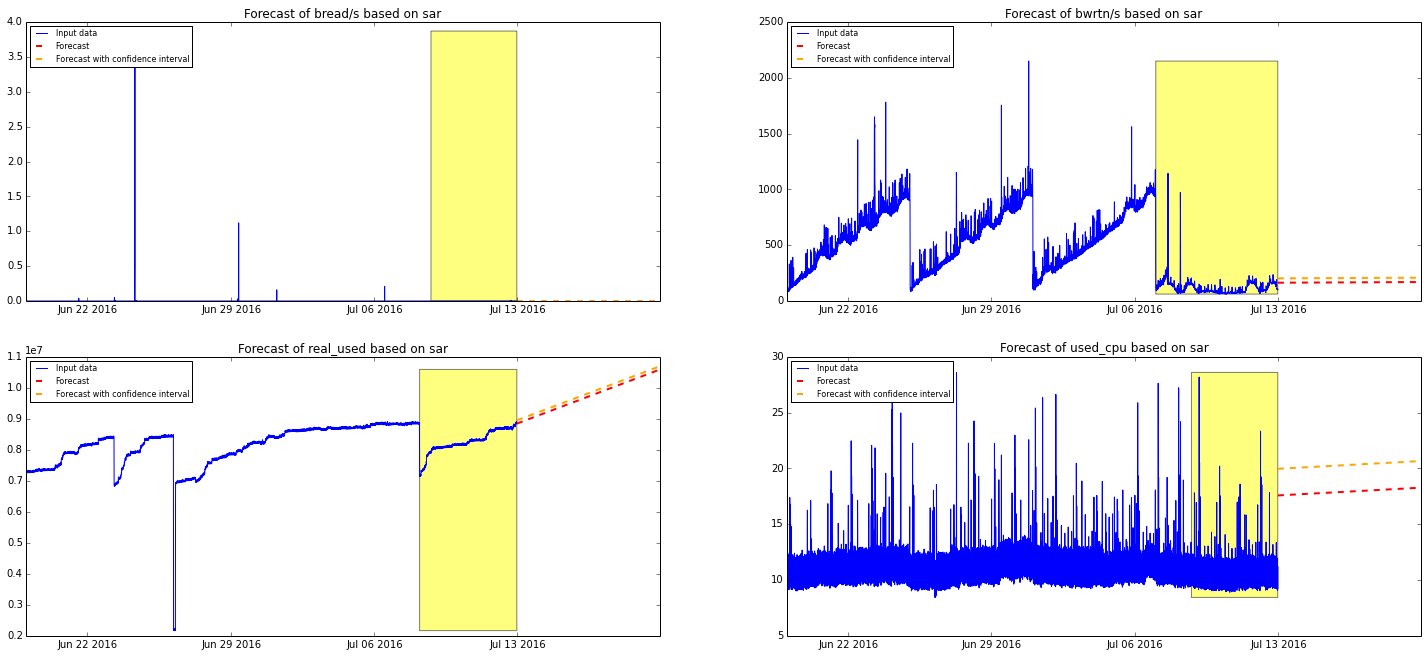

app107.eta.prod.ed1


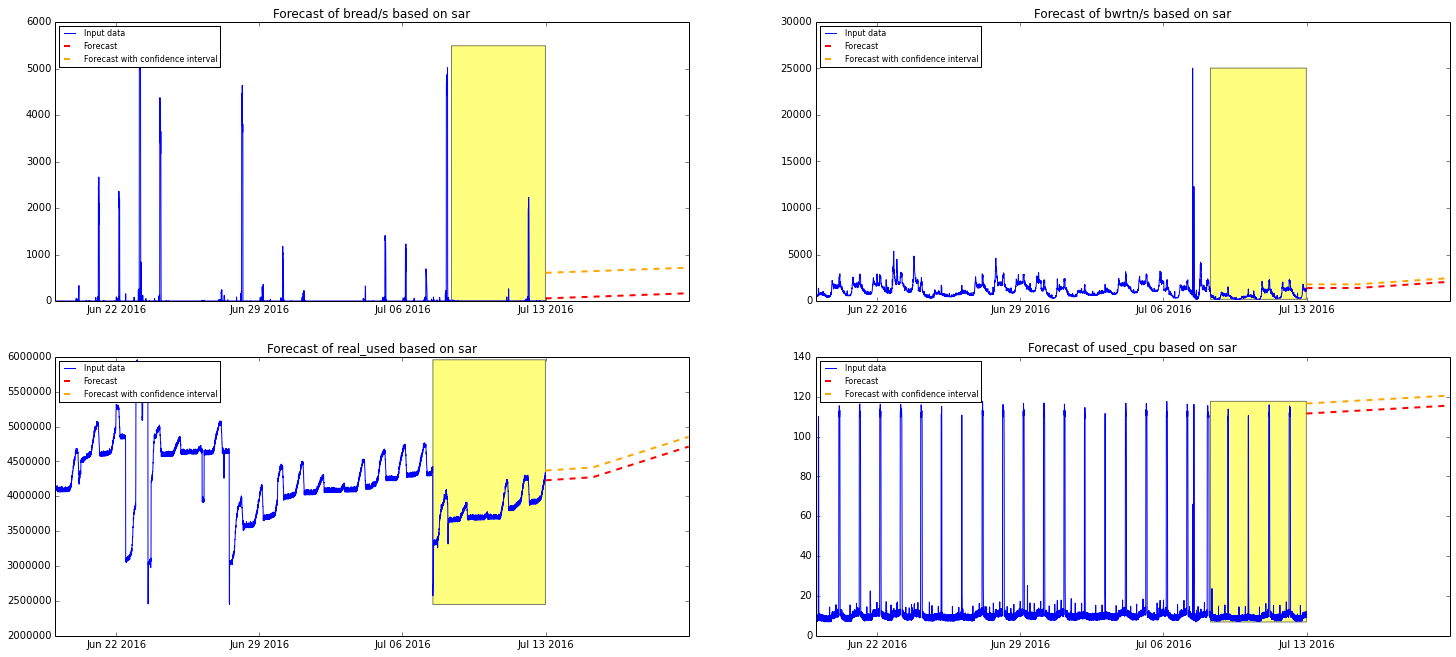

app108.eta.prod.ed1


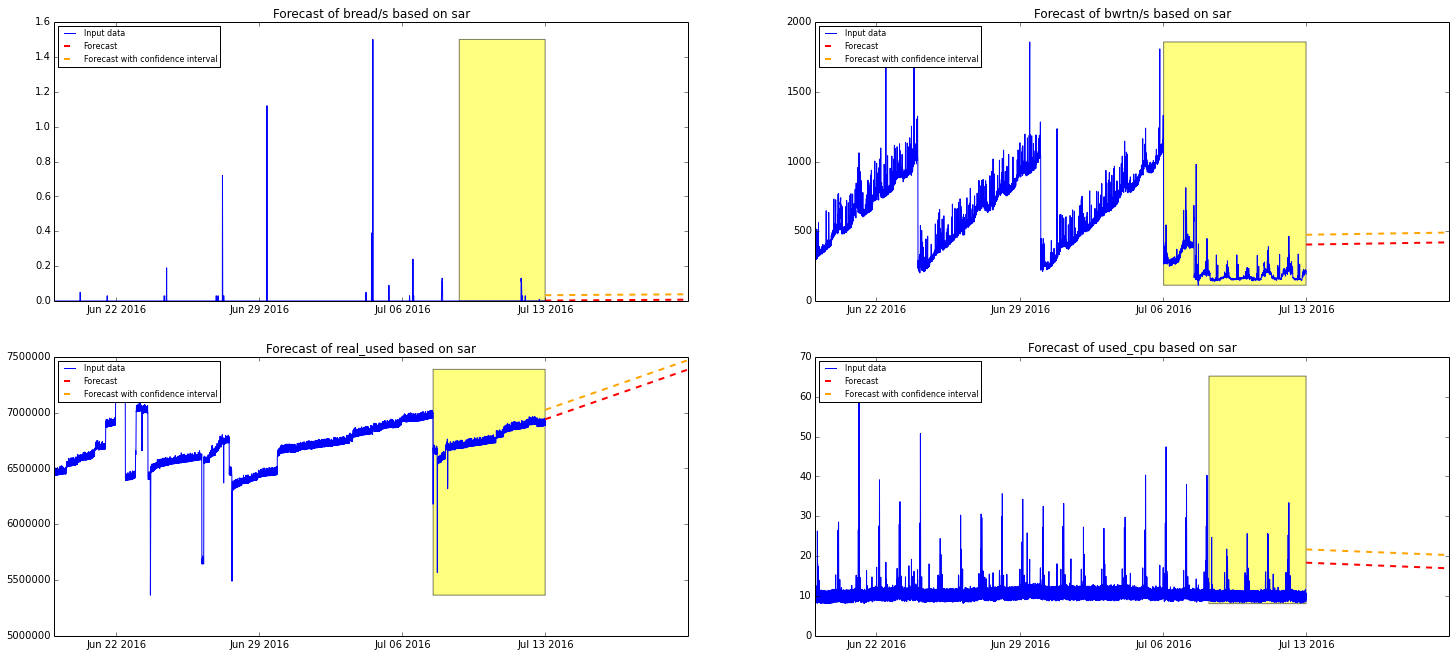

app109.eta.prod.ed1


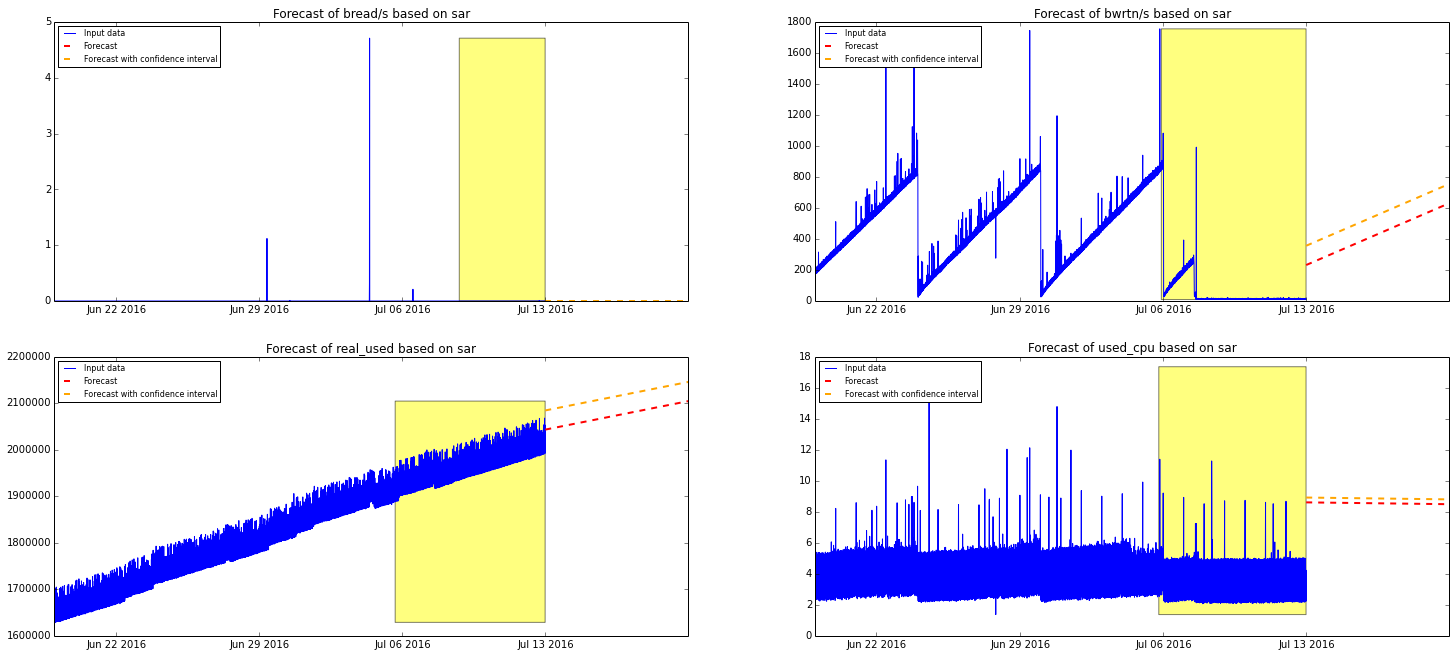

app110.eta.prod.ed1


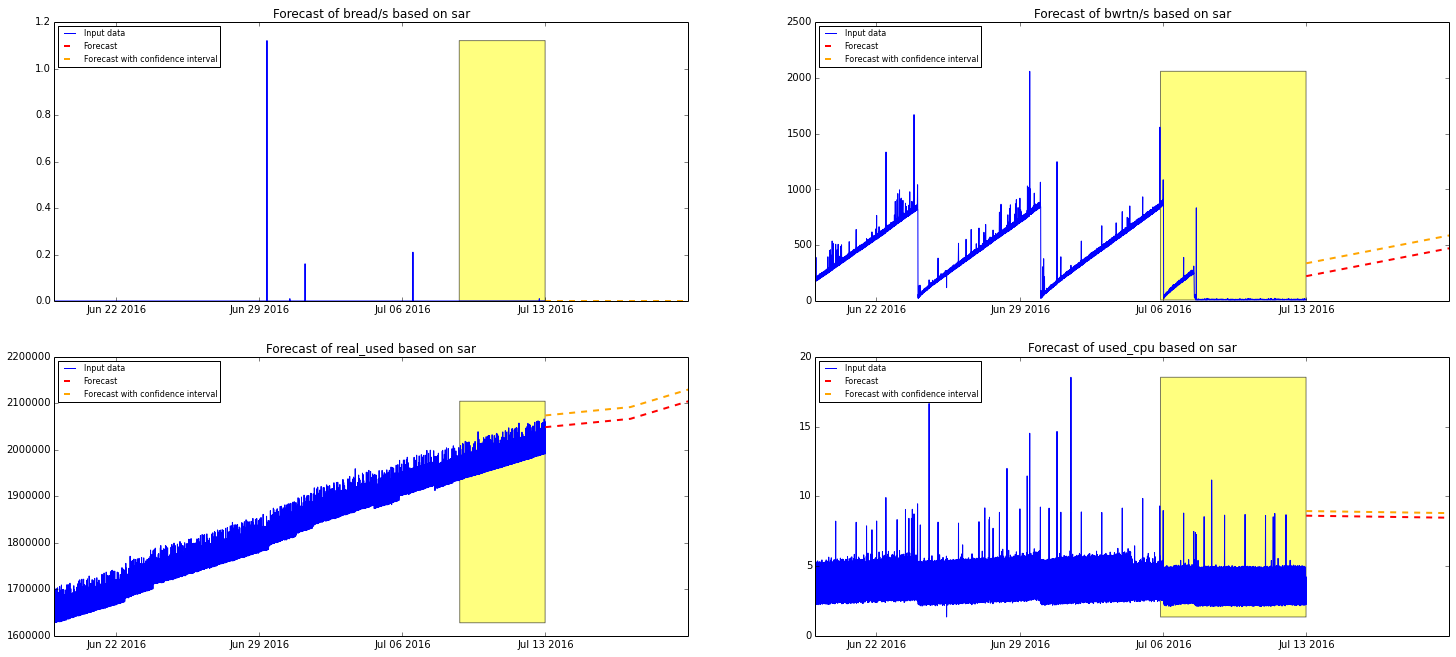

app111.eta.prod.ed1


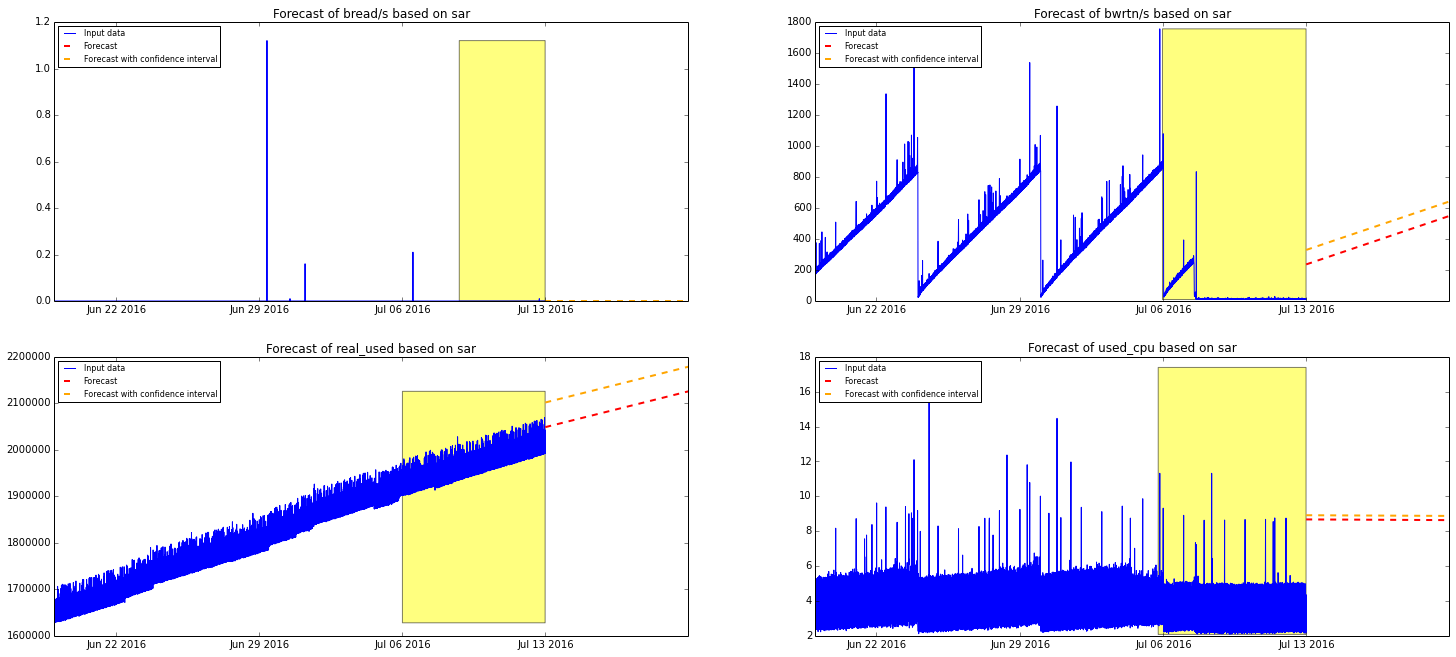

app112.eta.prod.ed1


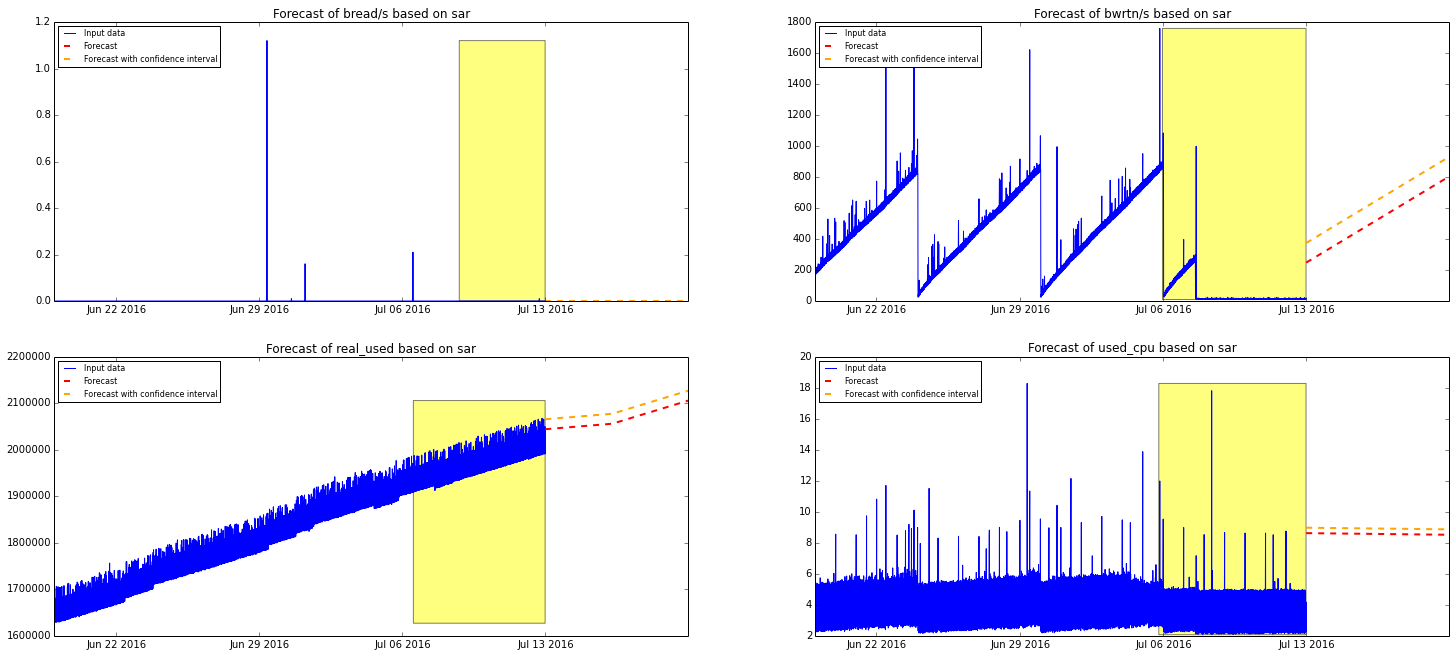

app101.eta.prod.ed5


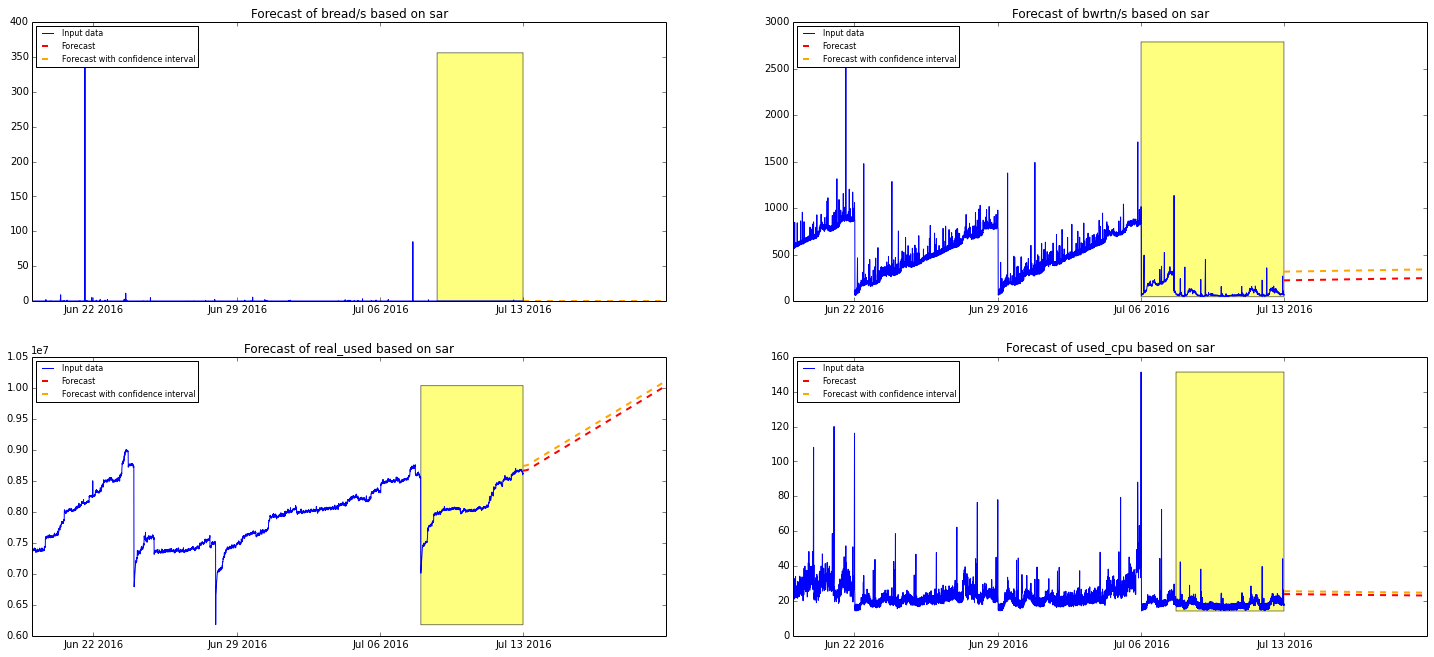

app102.eta.prod.ed5


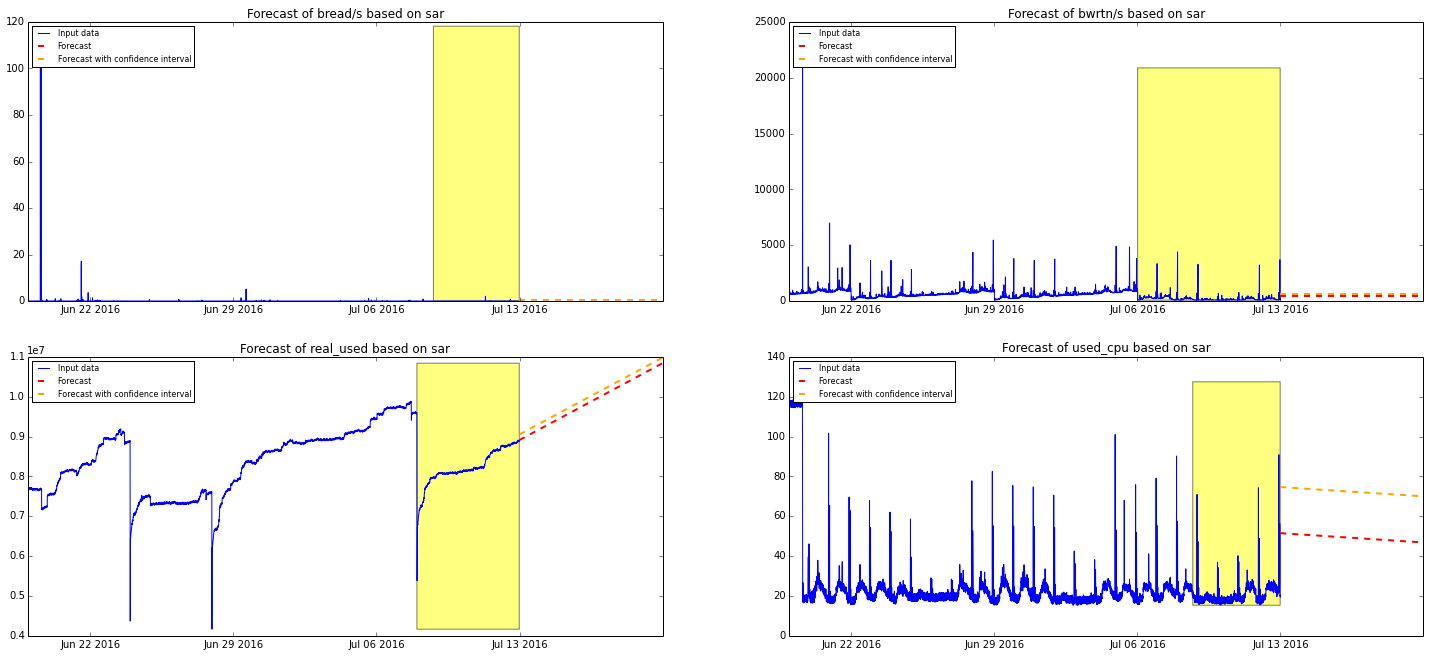

app103.eta.prod.ed5


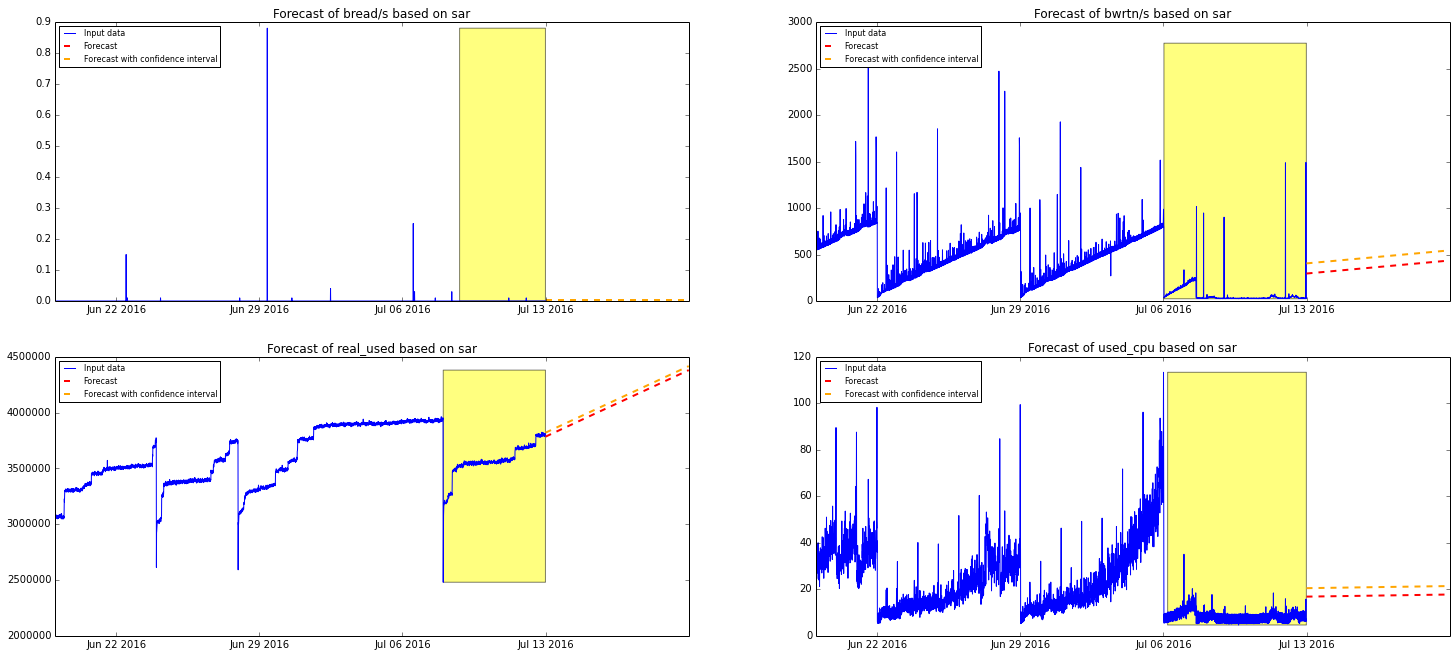

app104.eta.prod.ed5


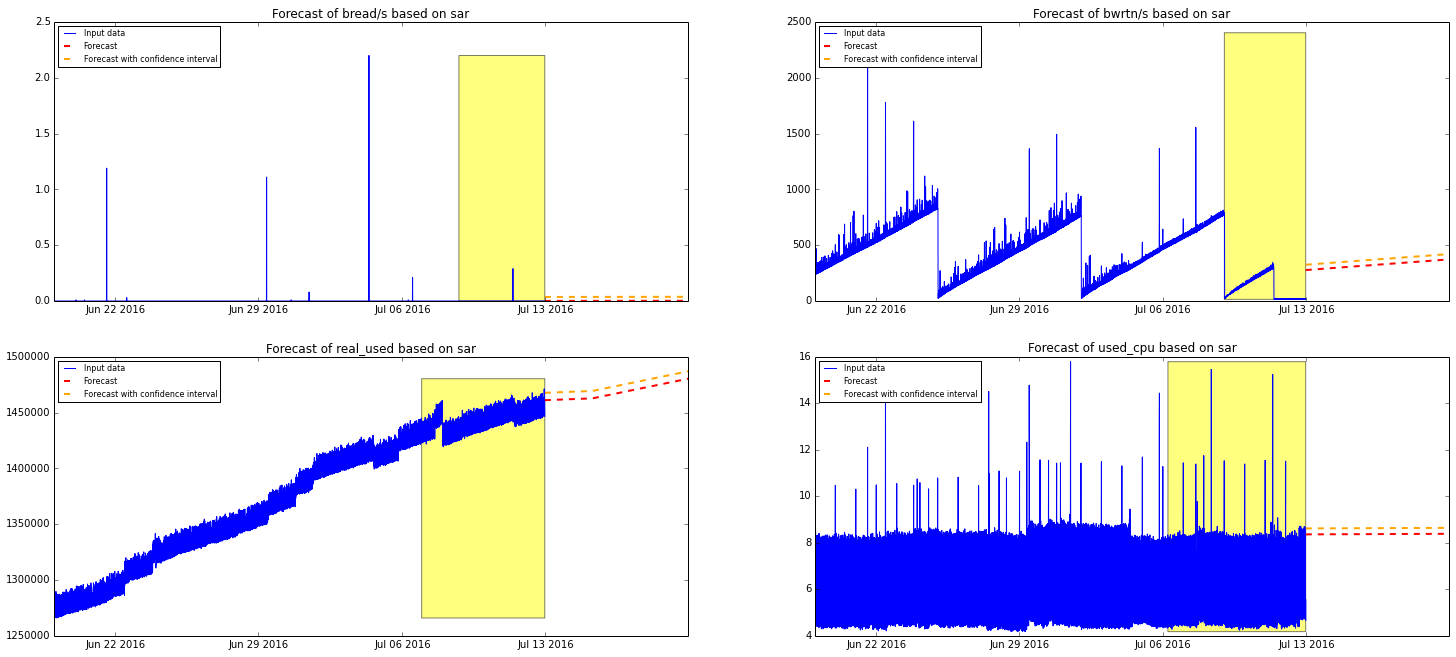

custom101.eta.prod.ed1


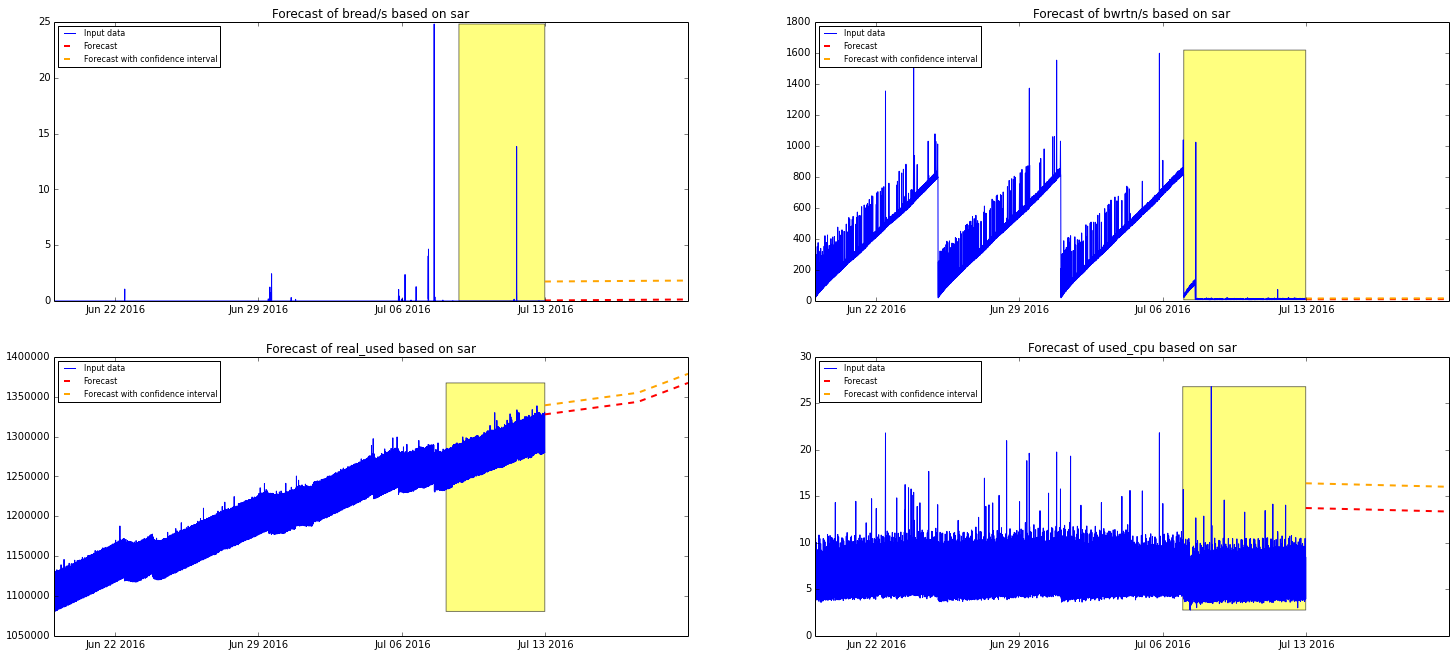

custom102.eta.prod.ed1


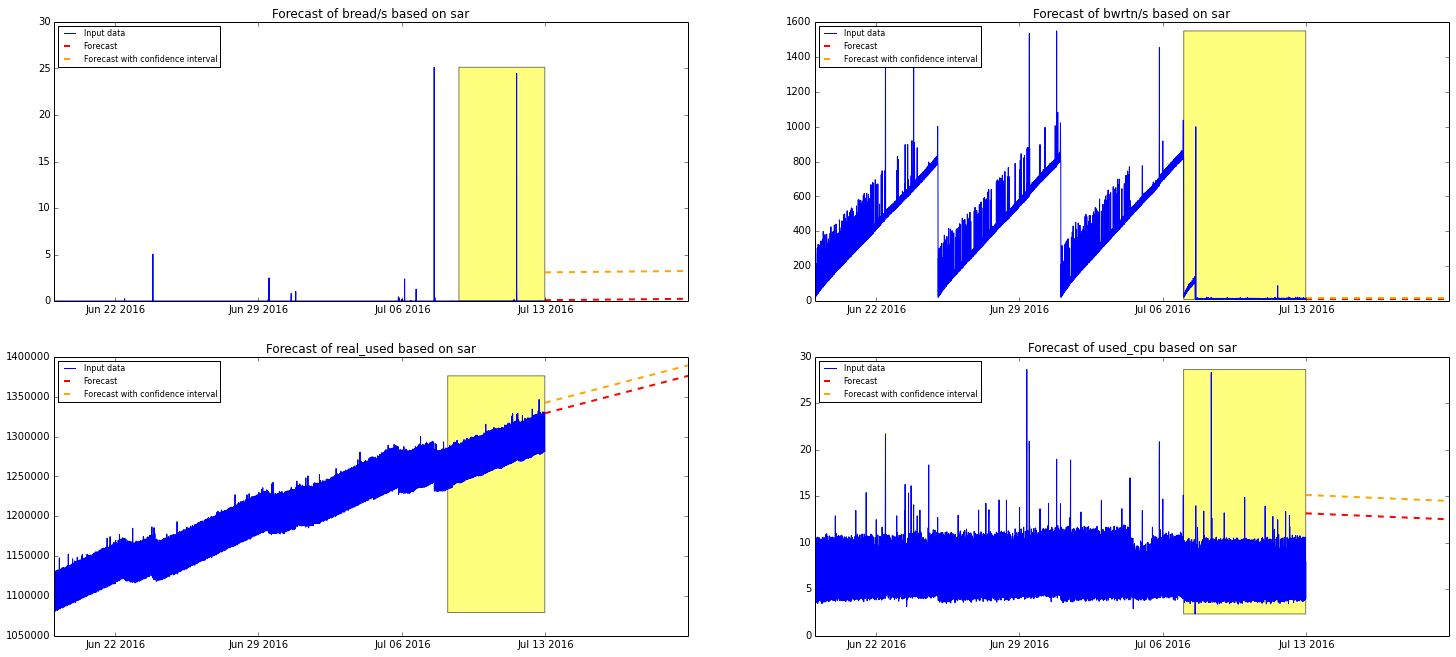

custom101.eta.prod.ed5


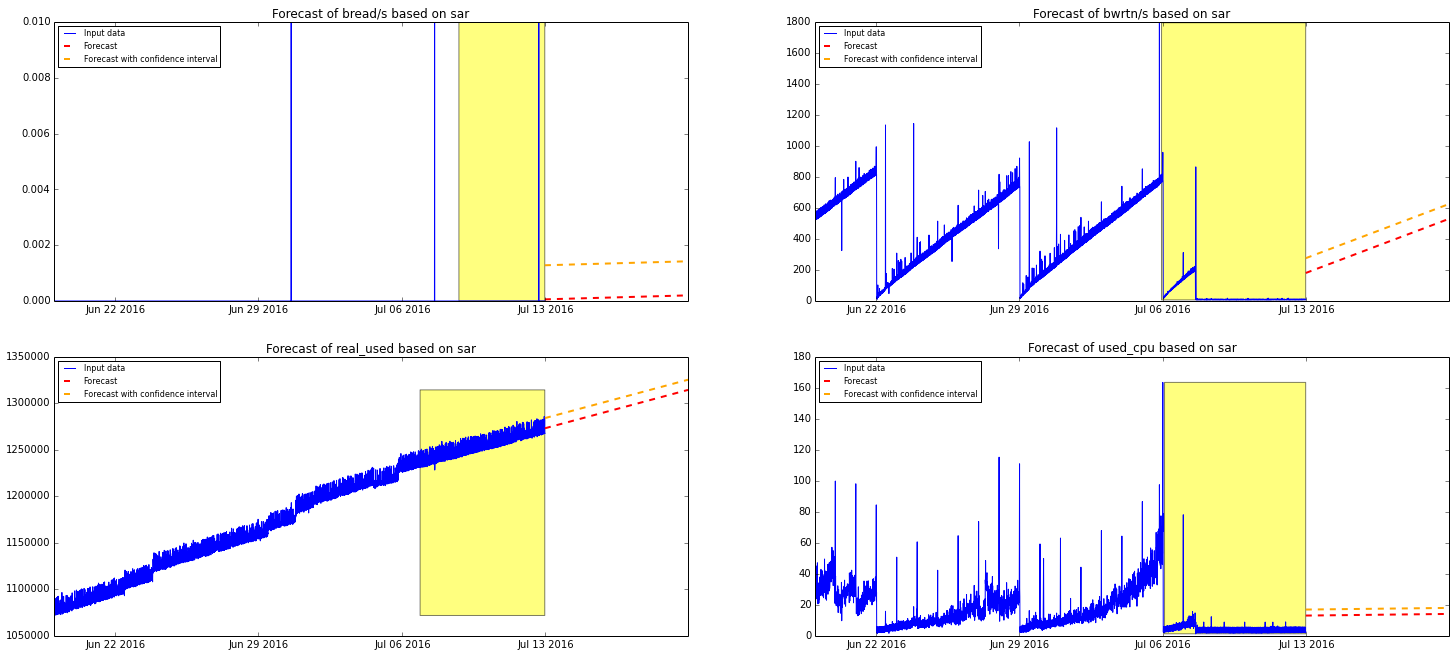

custom102.eta.prod.ed5


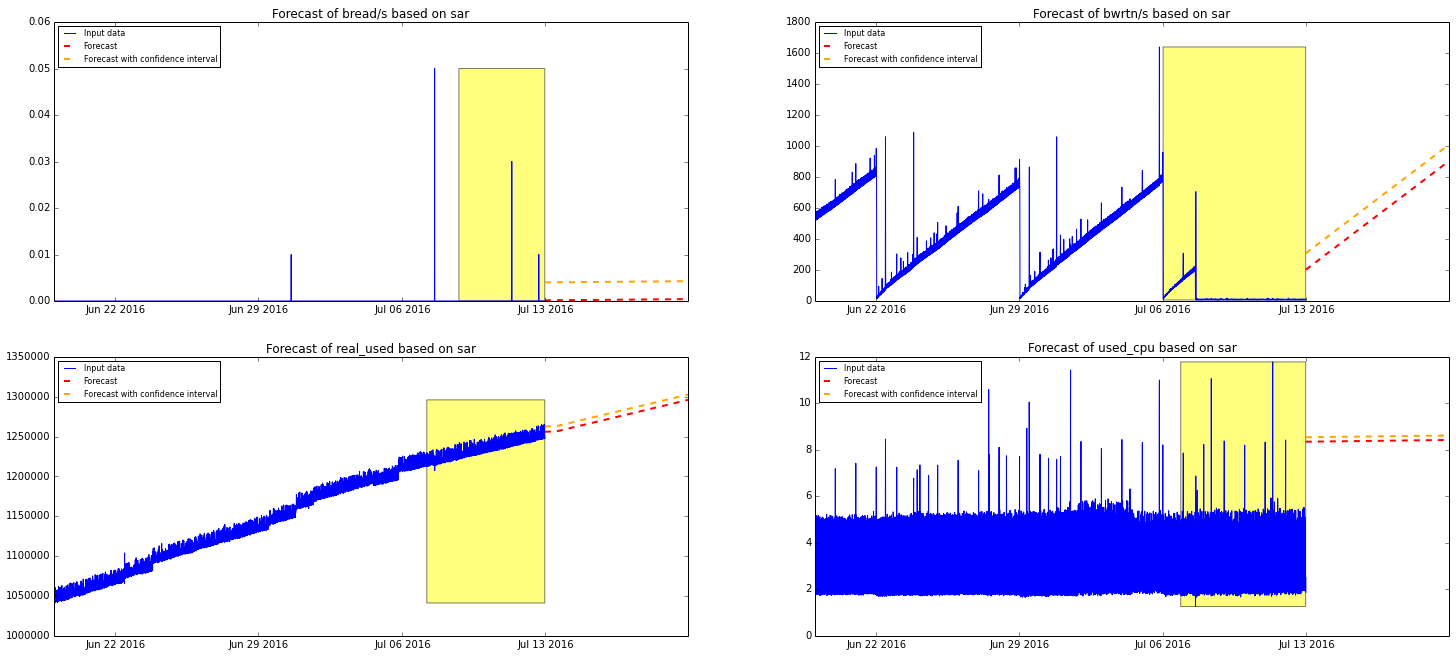

db101.eta.prod.ed1


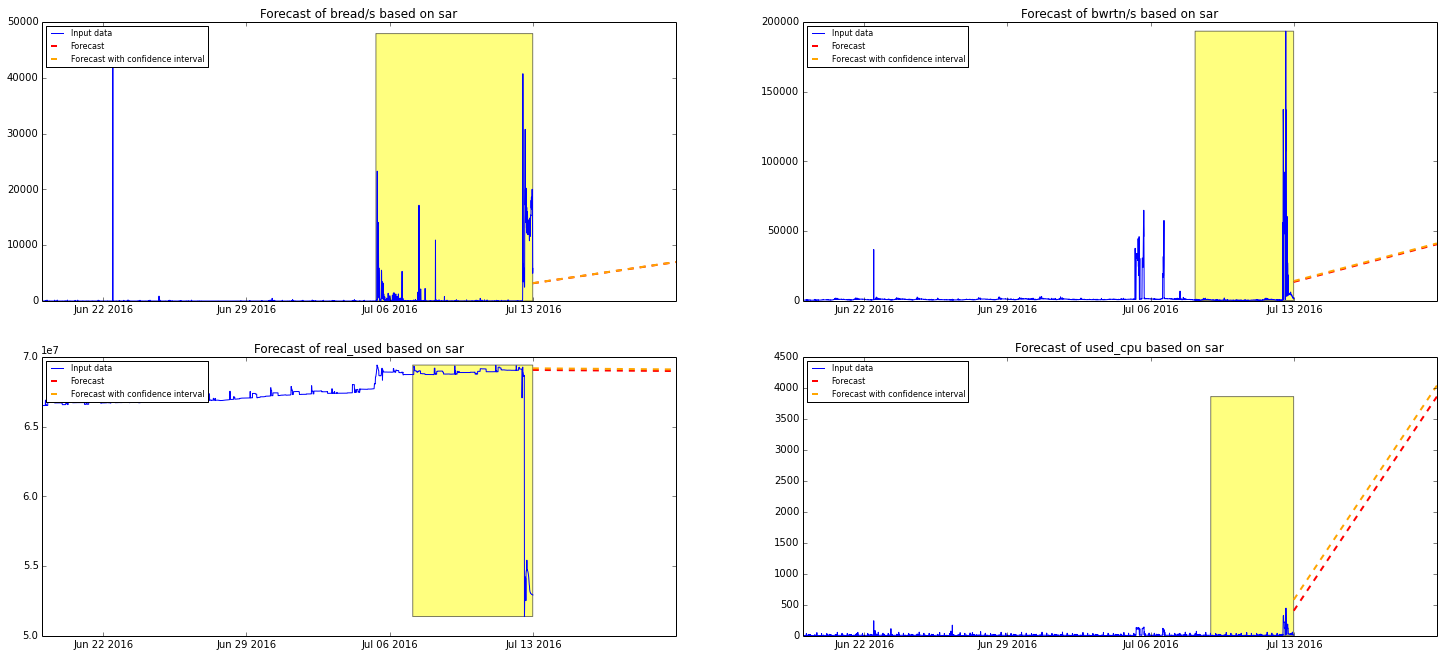

db102.eta.prod.ed1


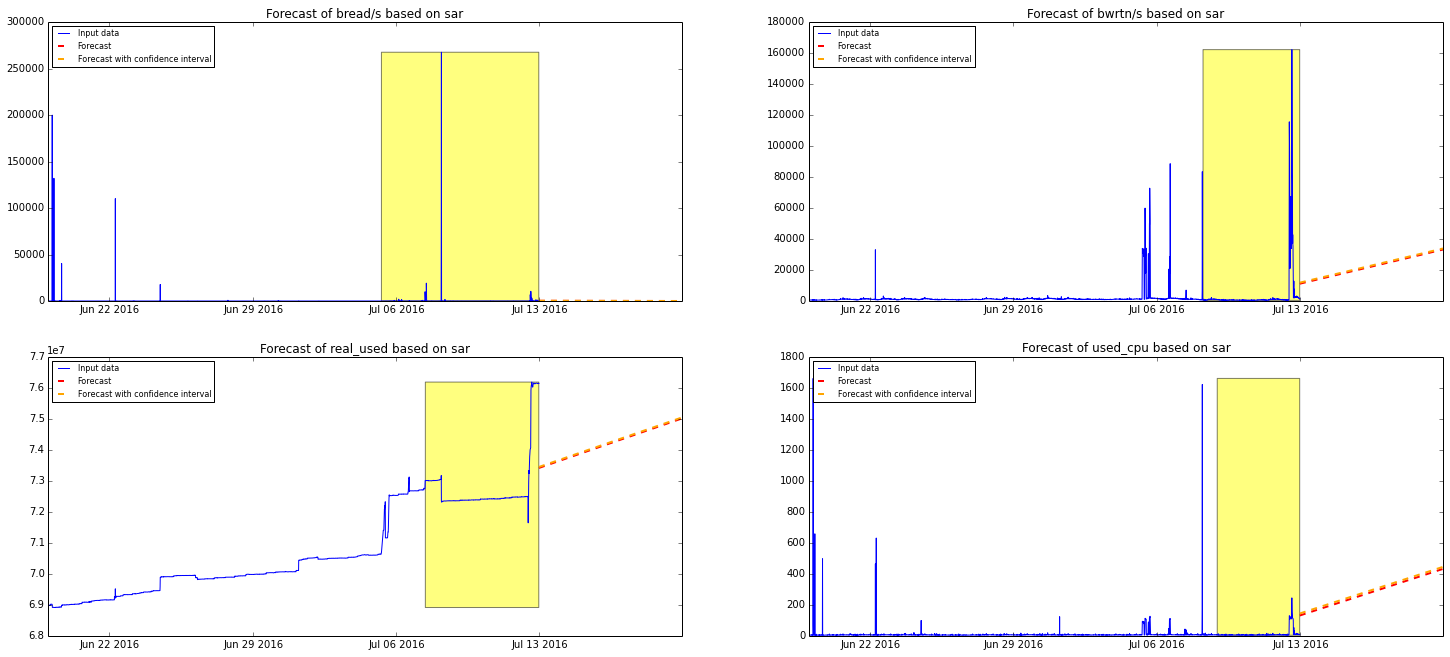

db101.eta.prod.ed5


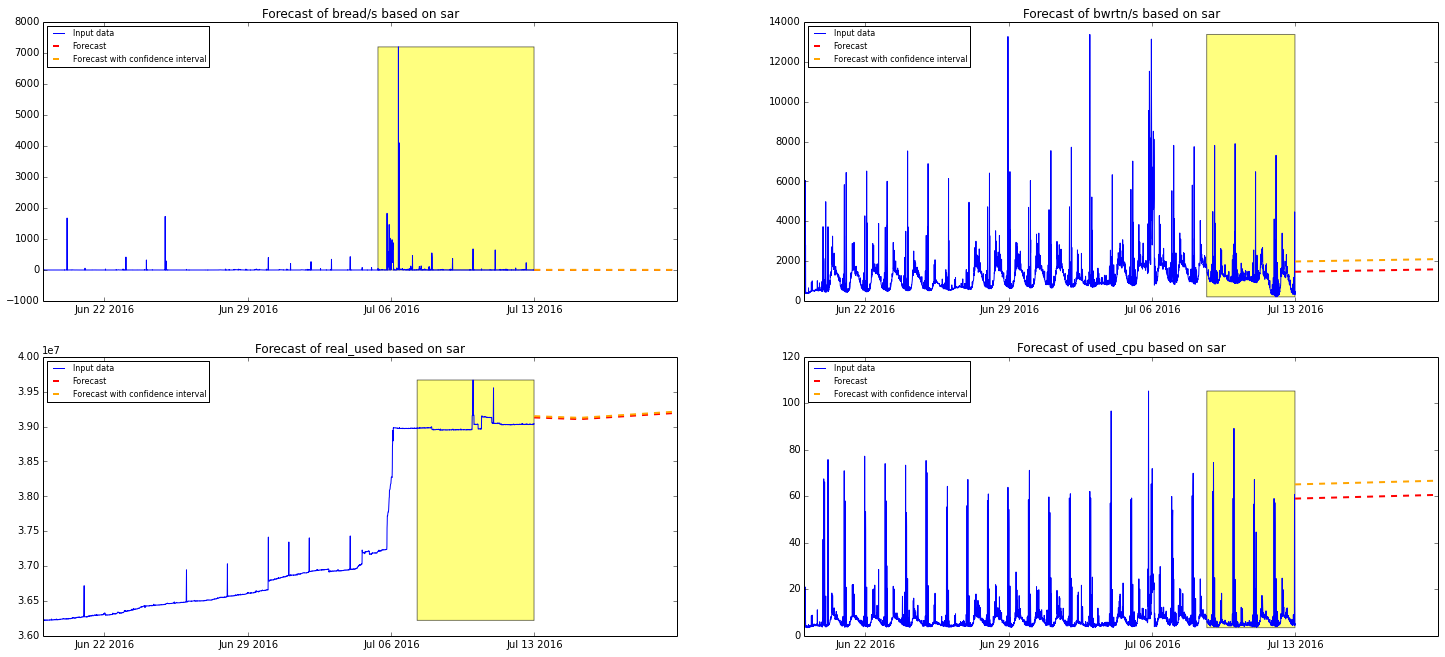

db102.eta.prod.ed5


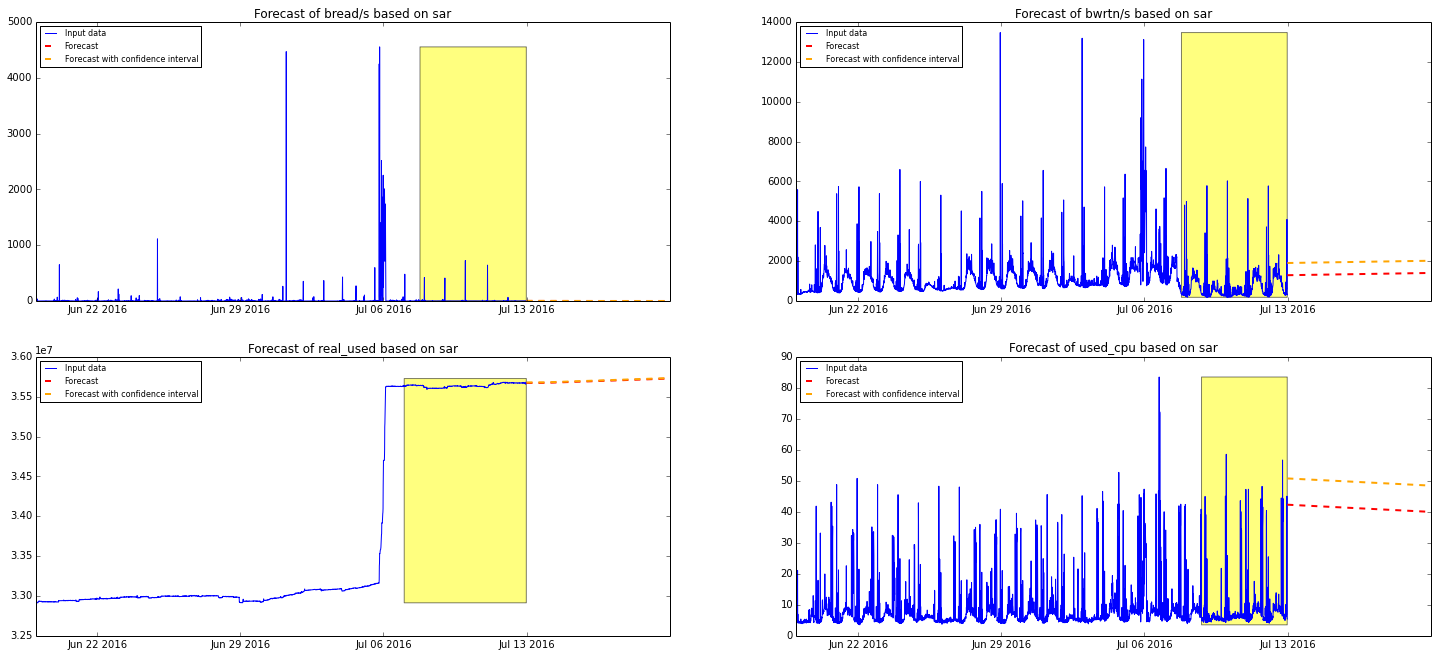

web101.eta.prod.ed1


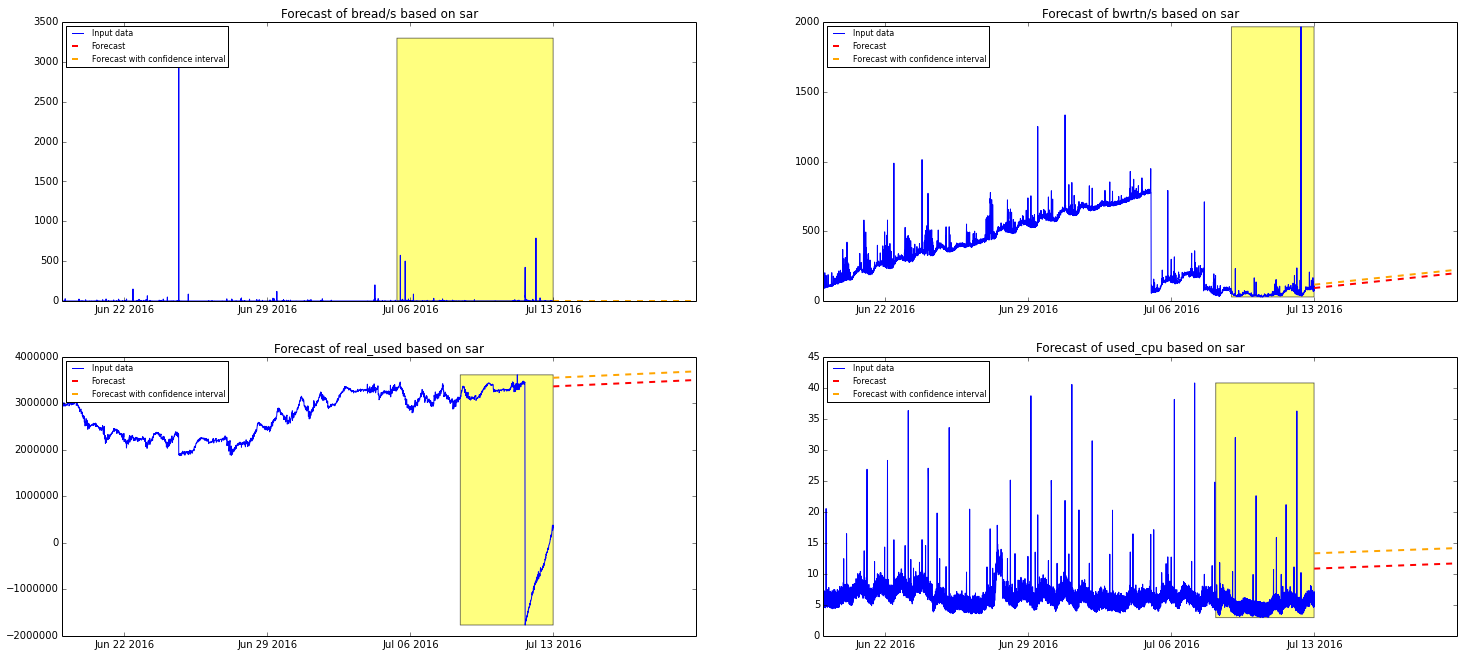

web102.eta.prod.ed1


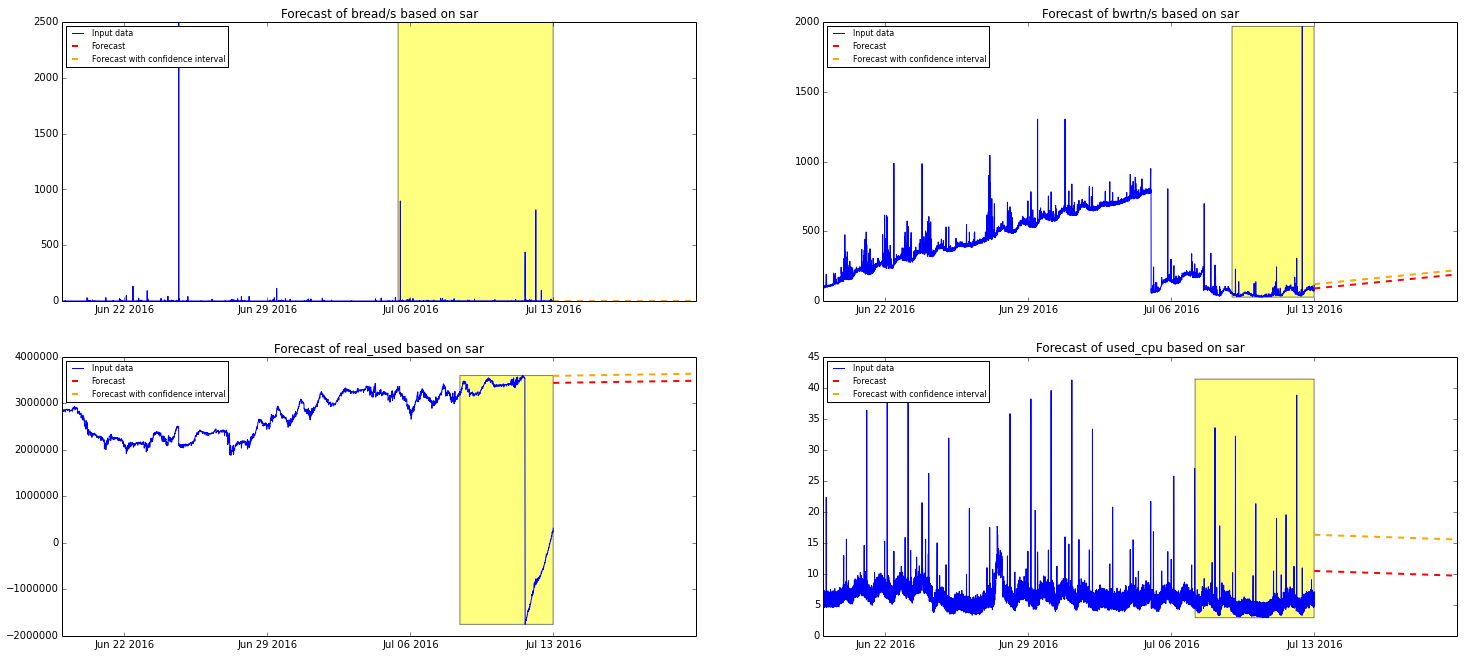

web103.eta.prod.ed1


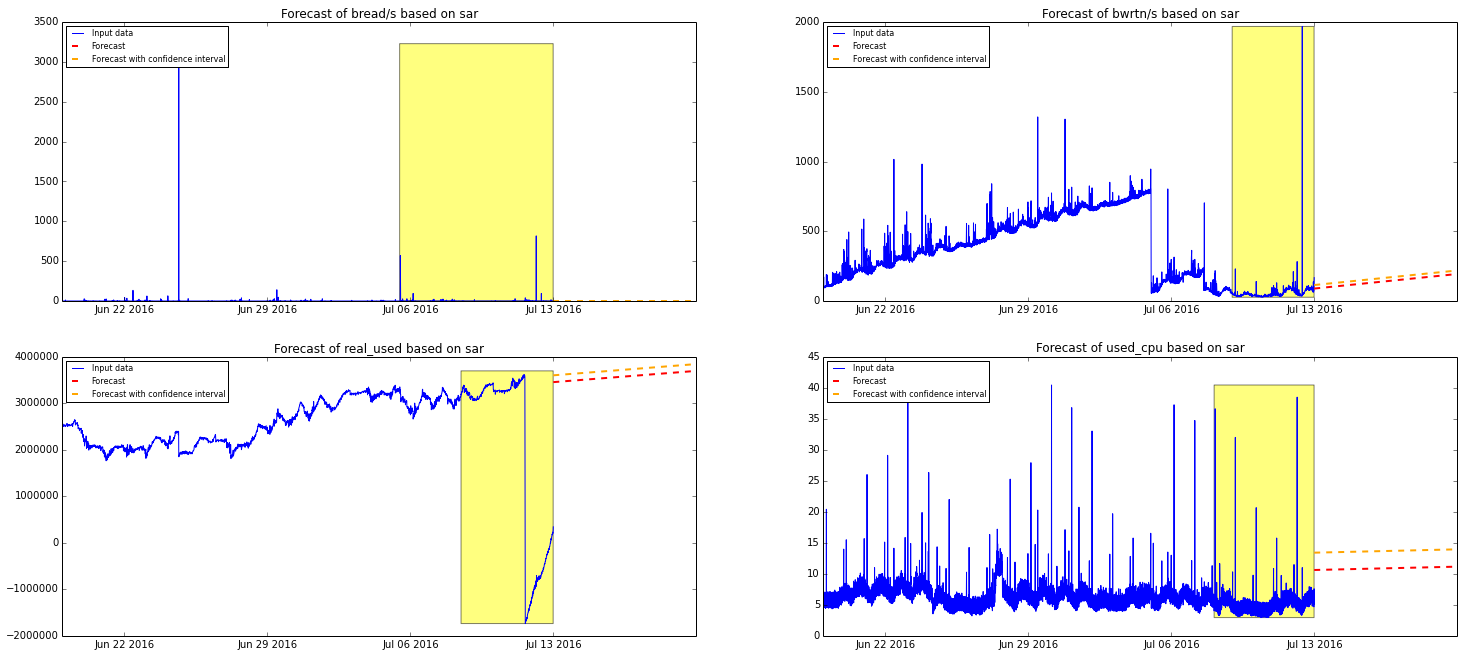

web104.eta.prod.ed1


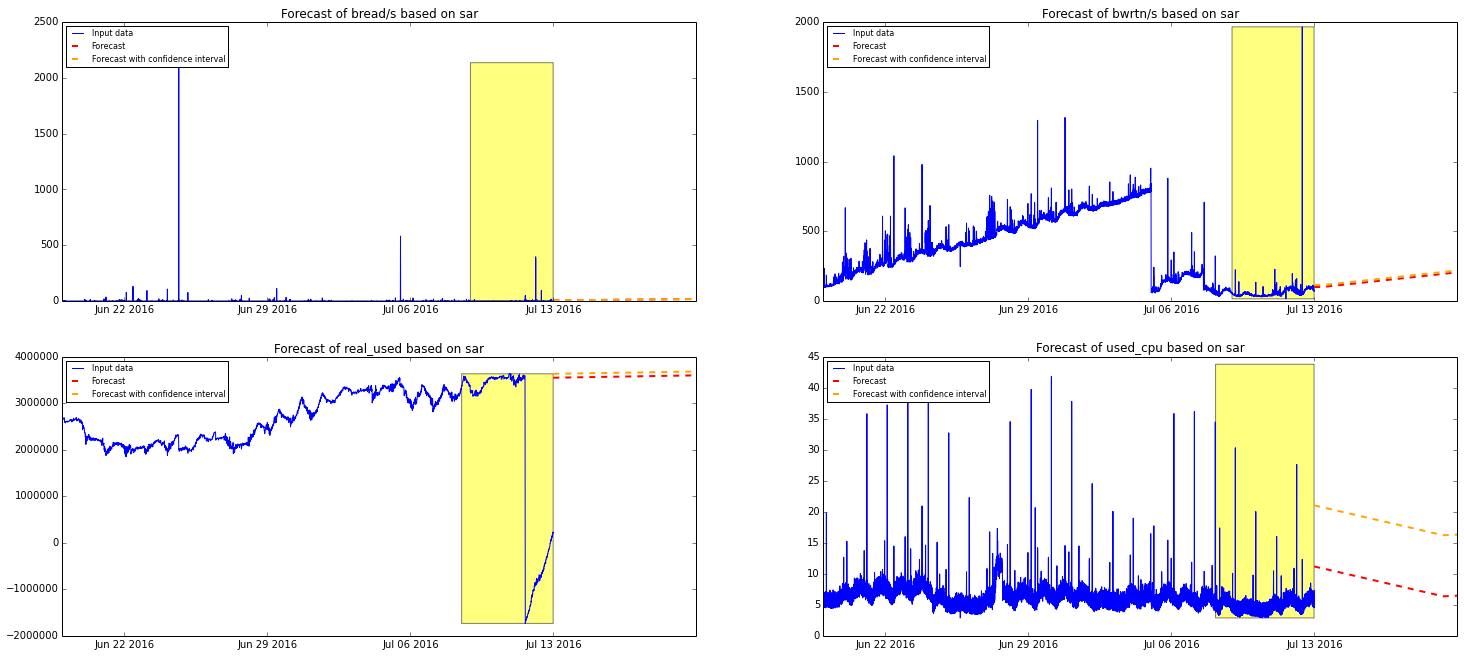

web105.eta.prod.ed1


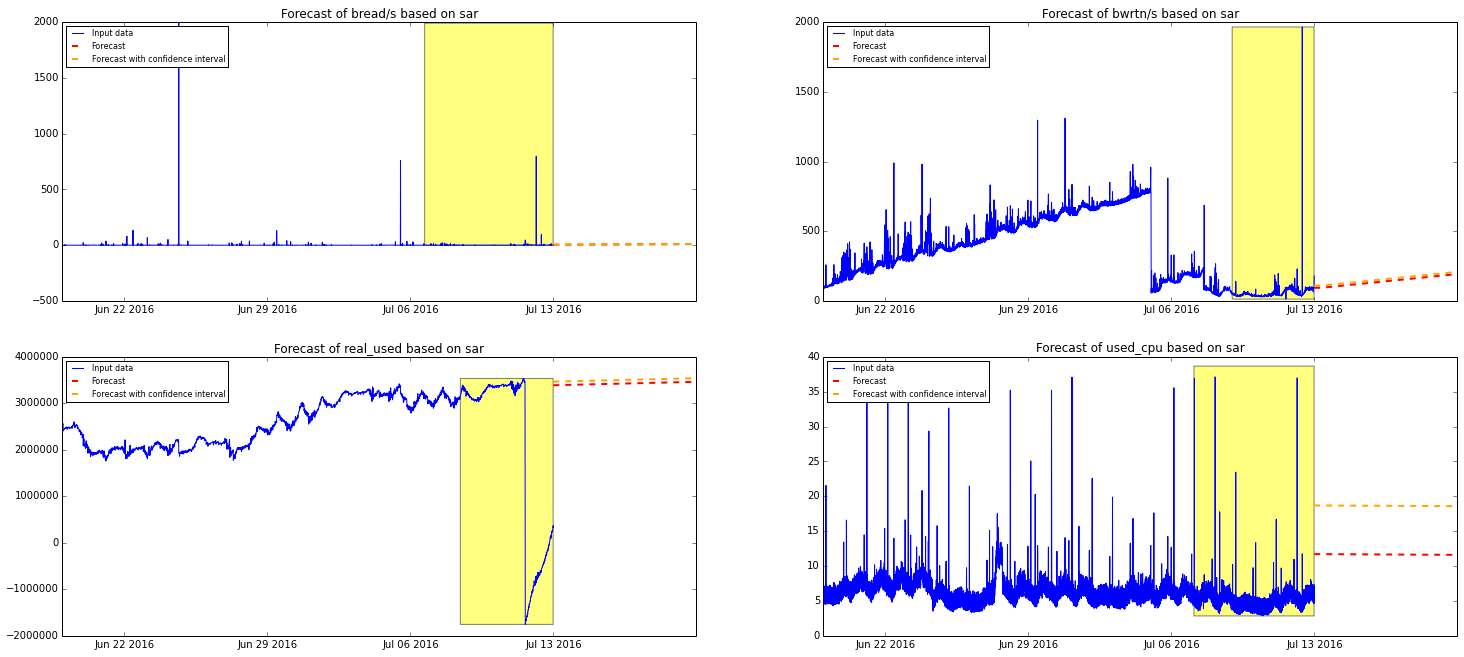

web106.eta.prod.ed1


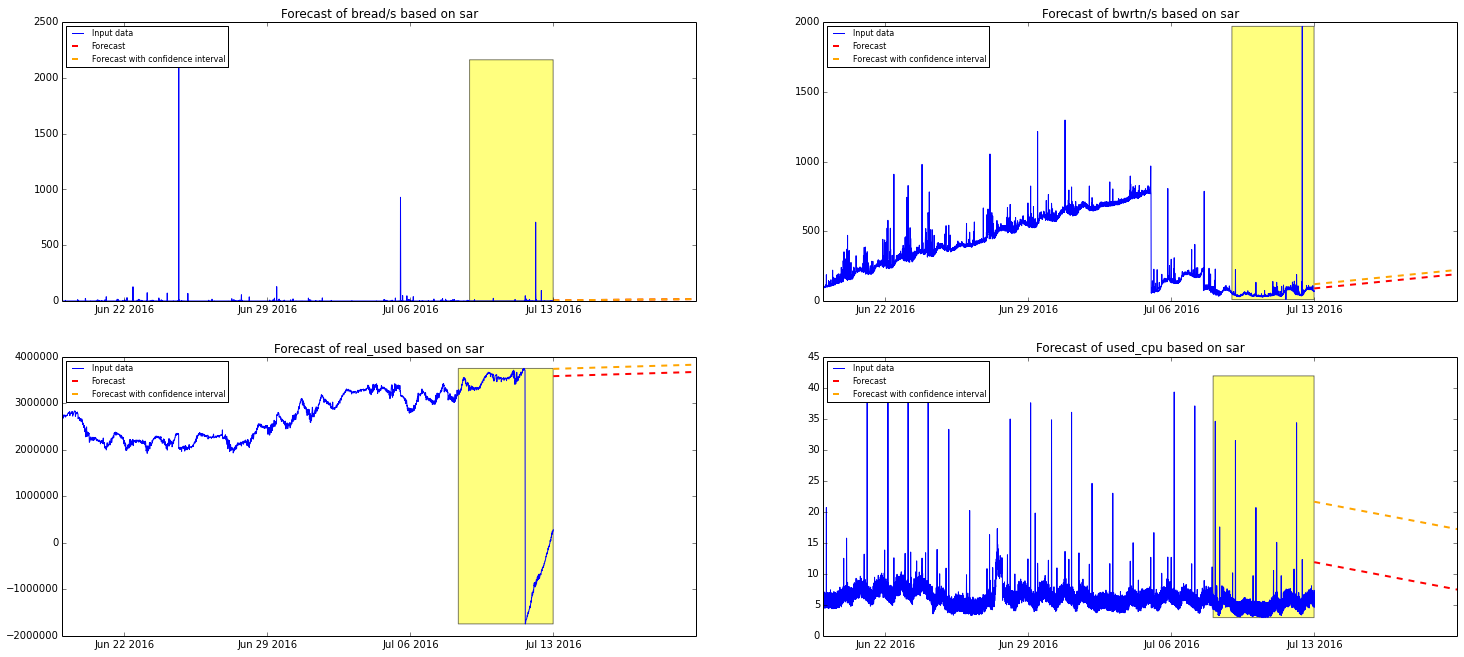

web107.eta.prod.ed1


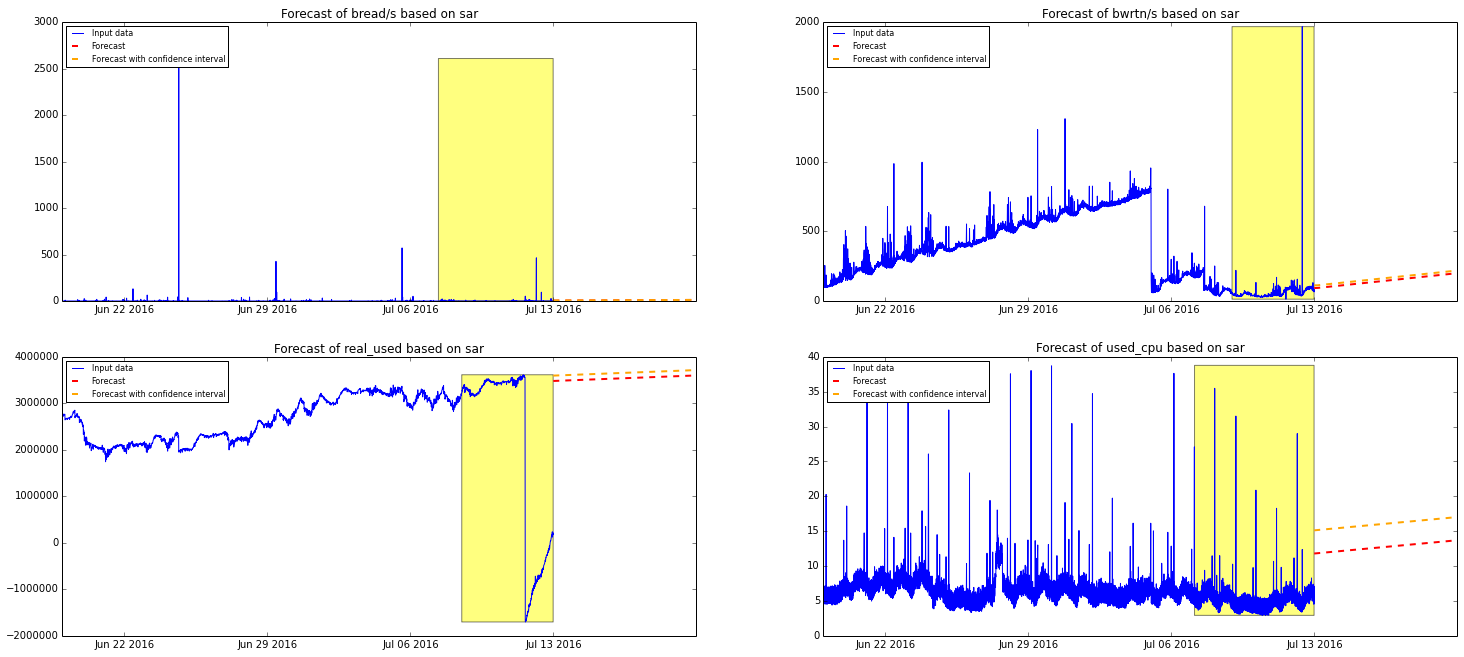

web108.eta.prod.ed1


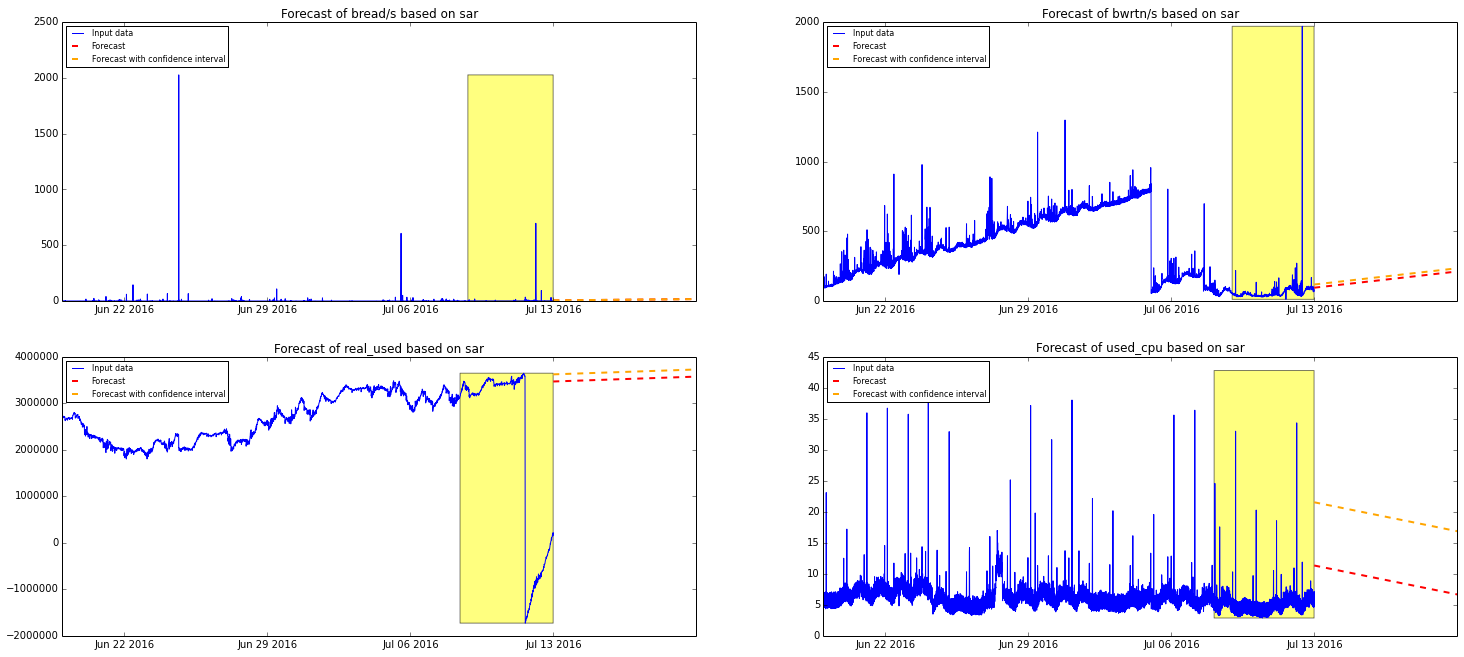

web109.eta.prod.ed1


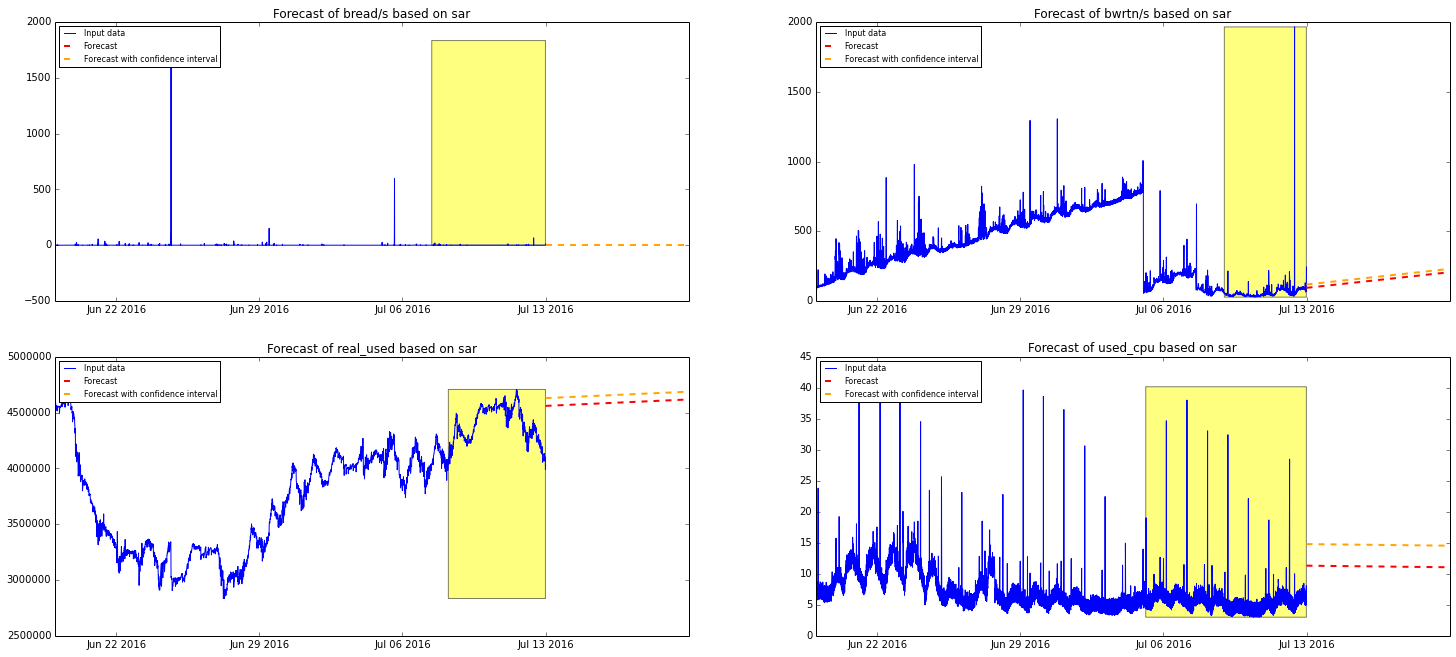

web110.eta.prod.ed1


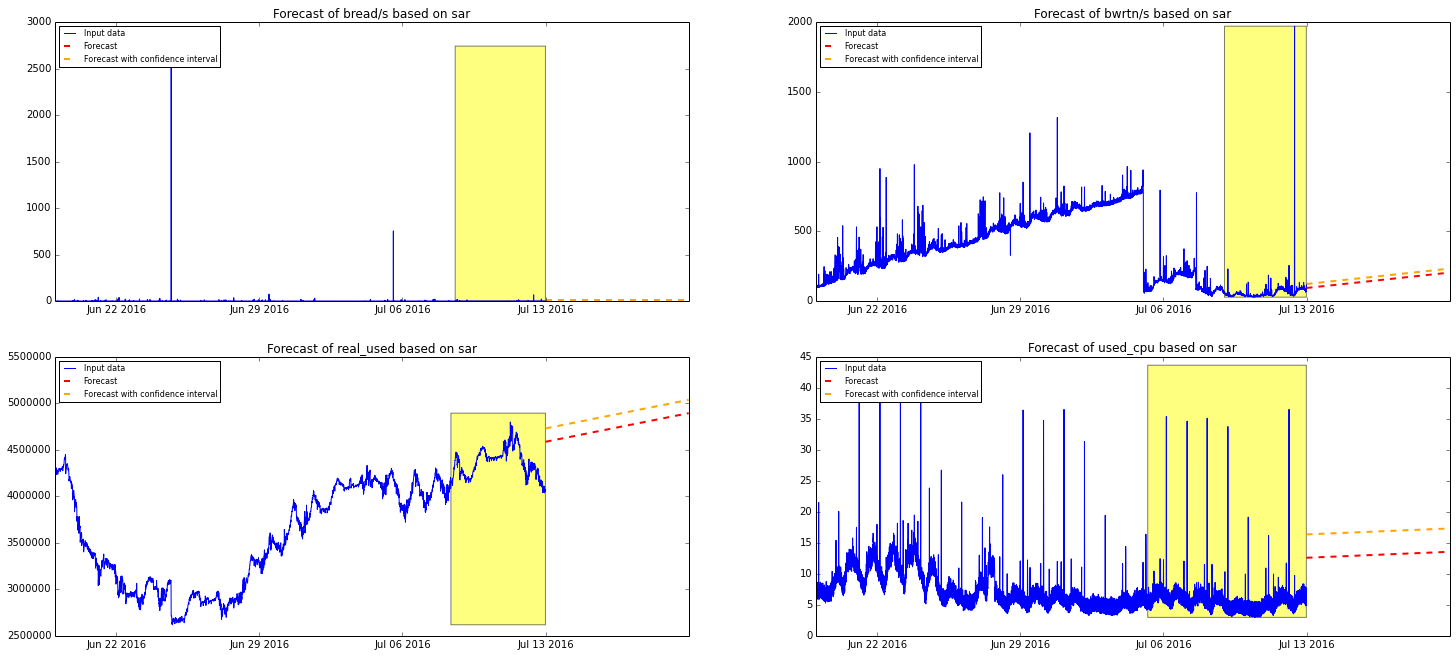

web111.eta.prod.ed1


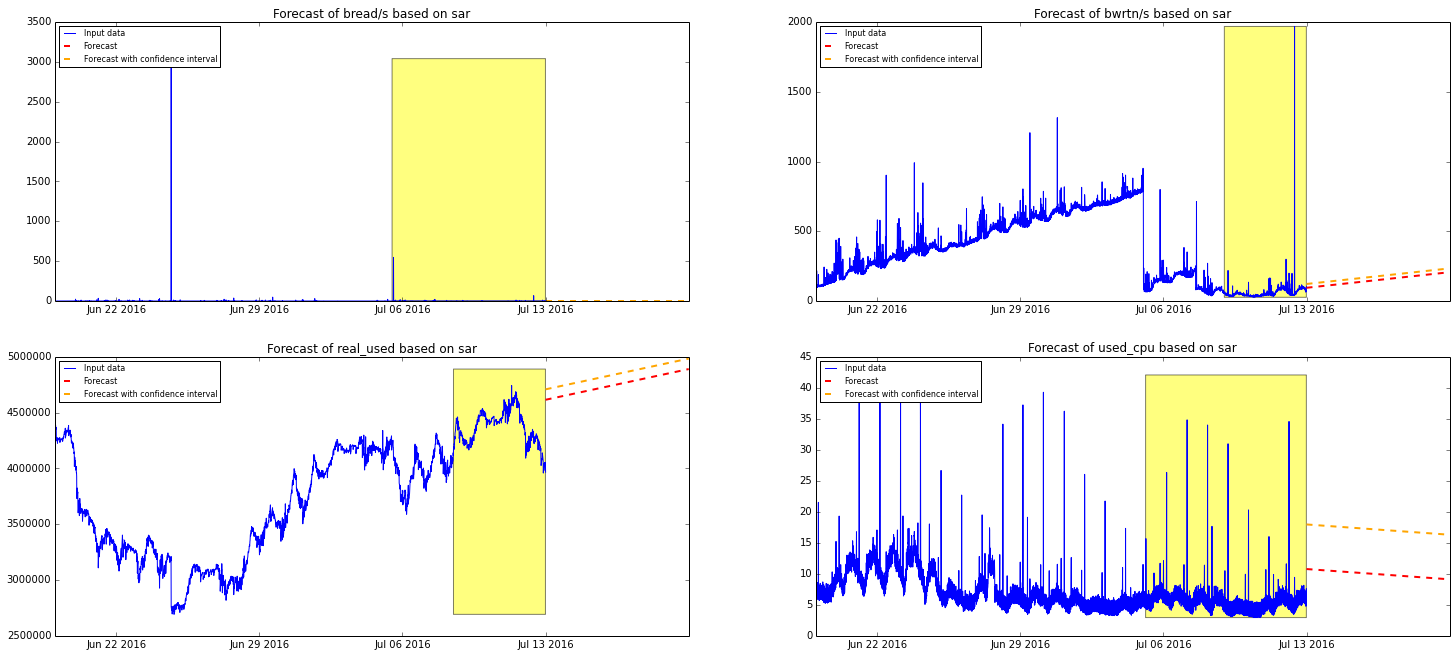

web112.eta.prod.ed1


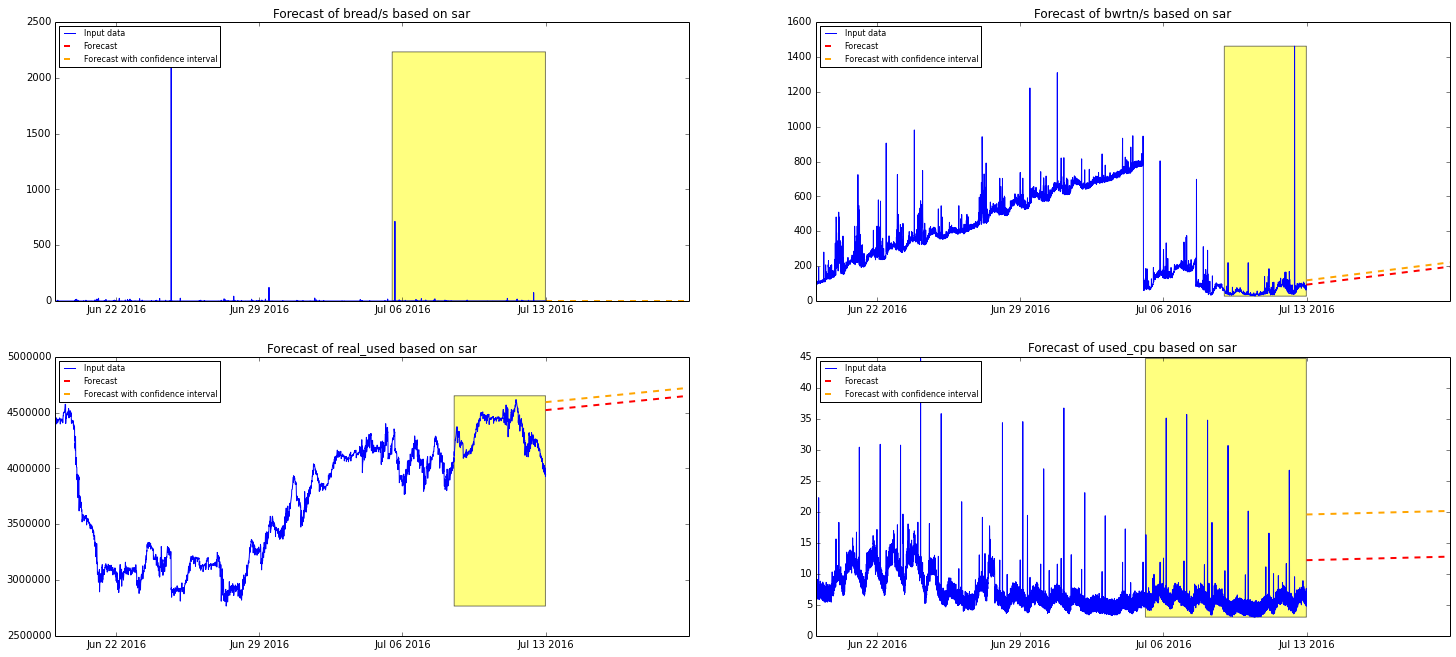

web113.eta.prod.ed1


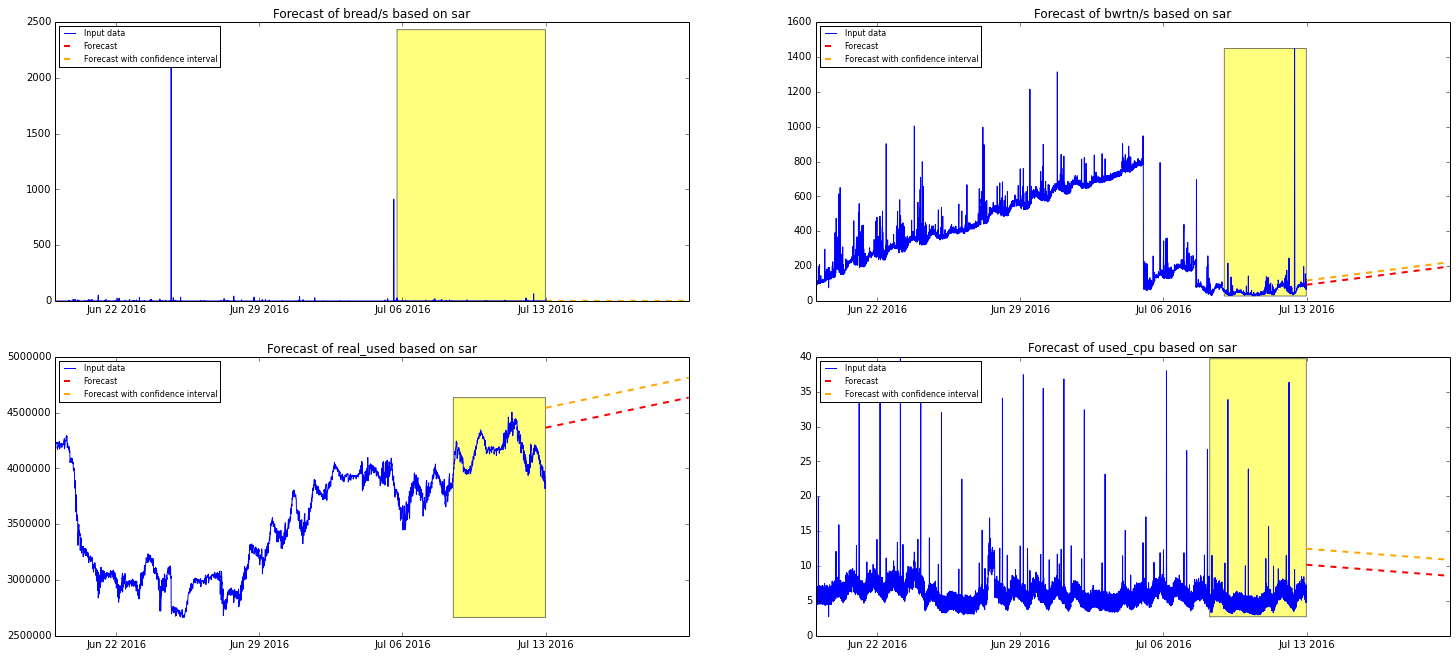

web114.eta.prod.ed1


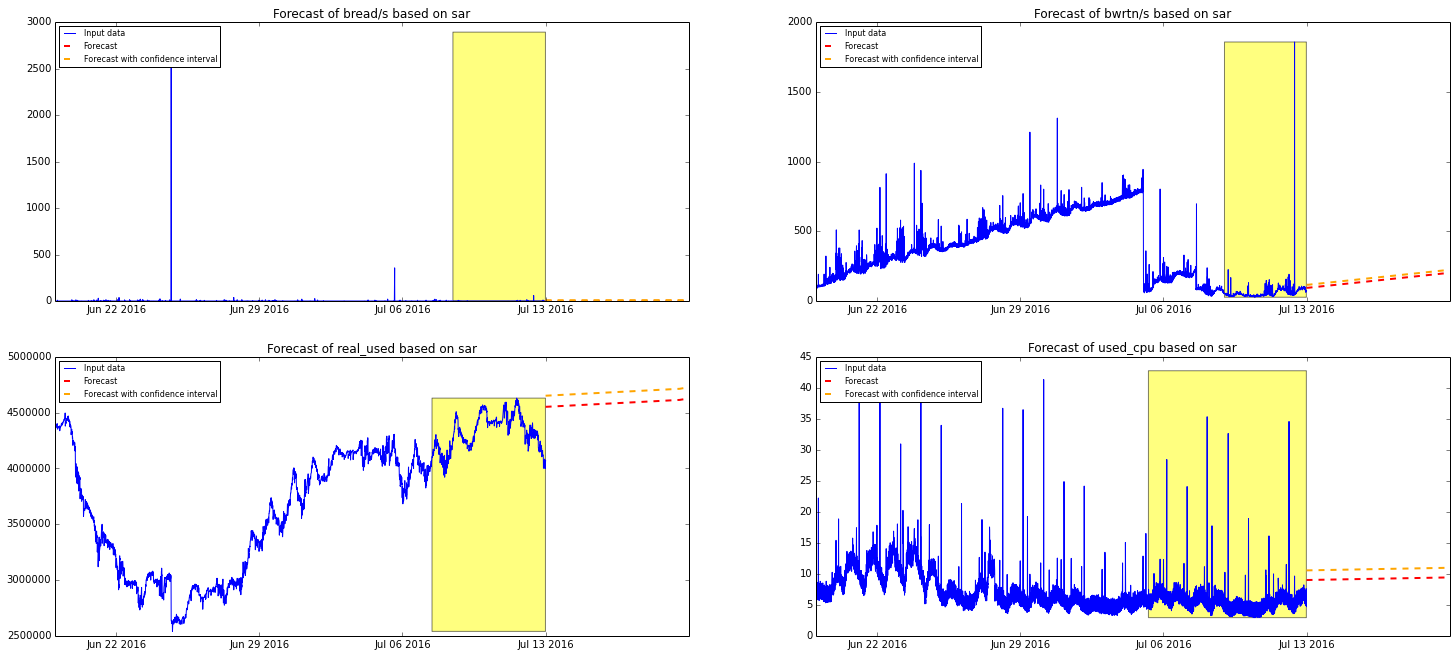

web115.eta.prod.ed1


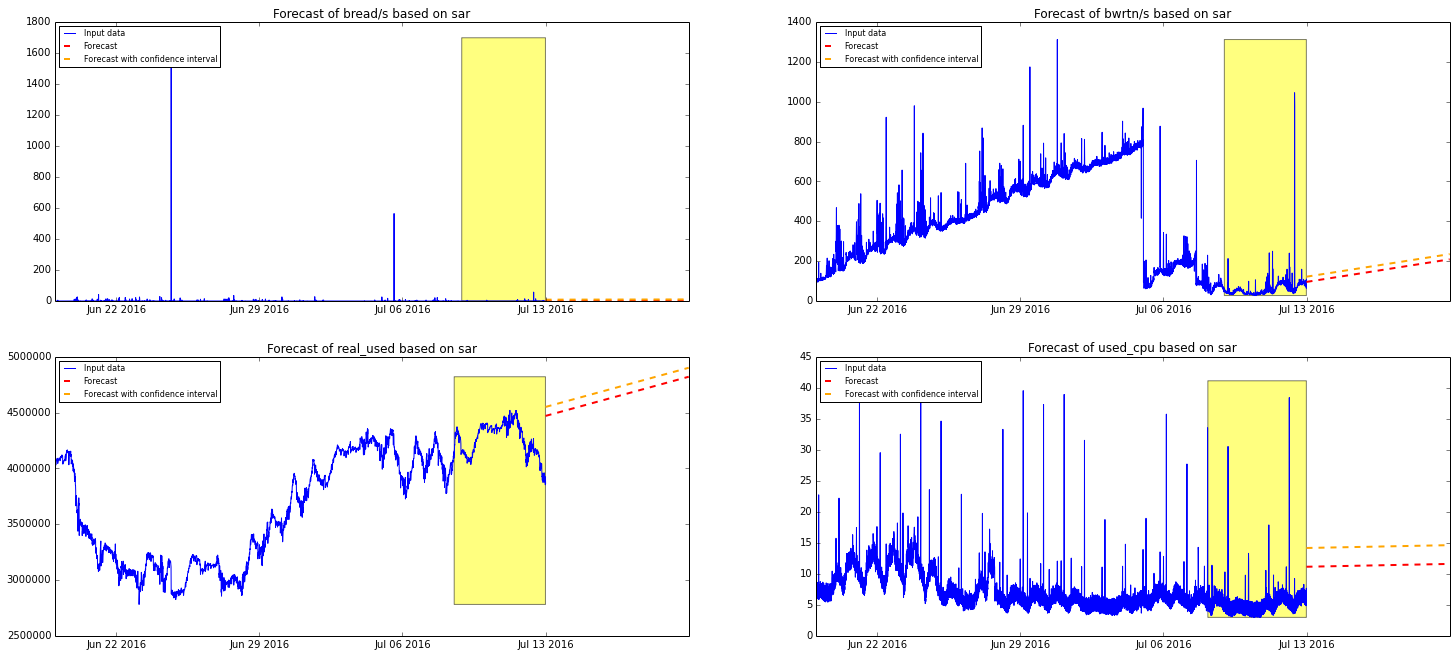

web116.eta.prod.ed1


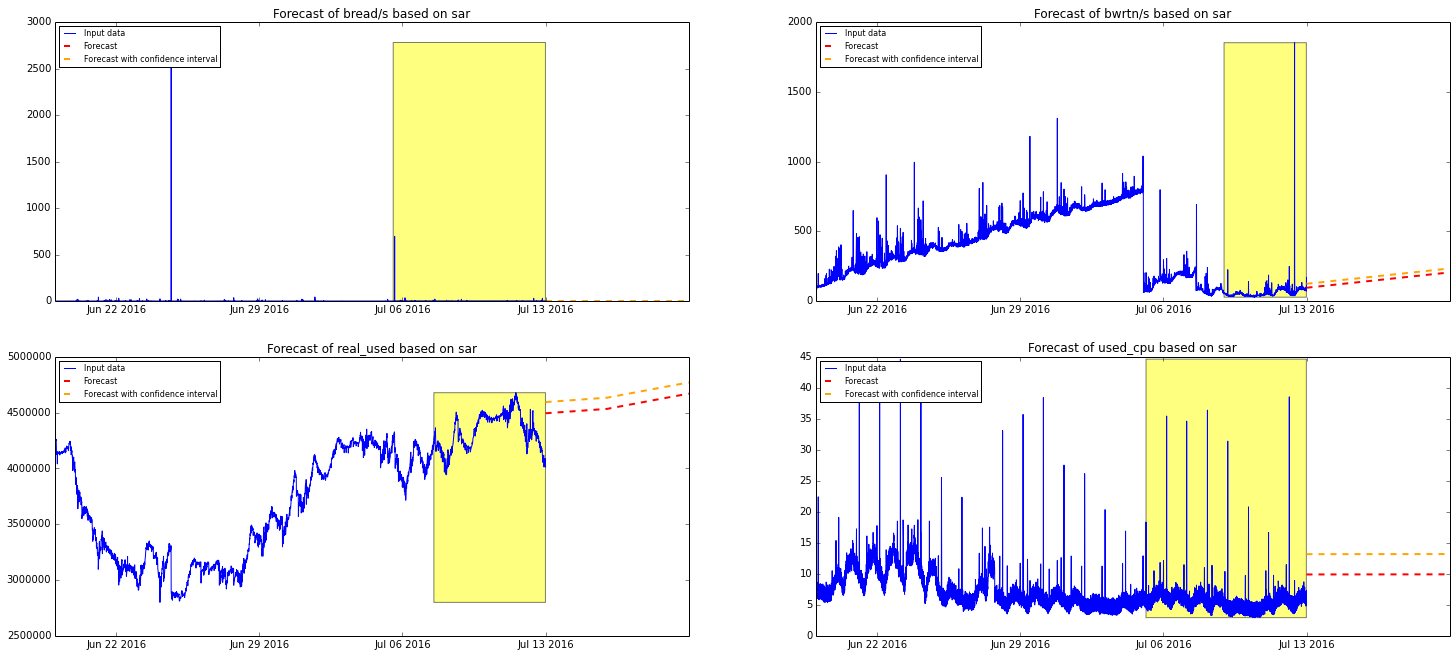

web117.eta.prod.ed1


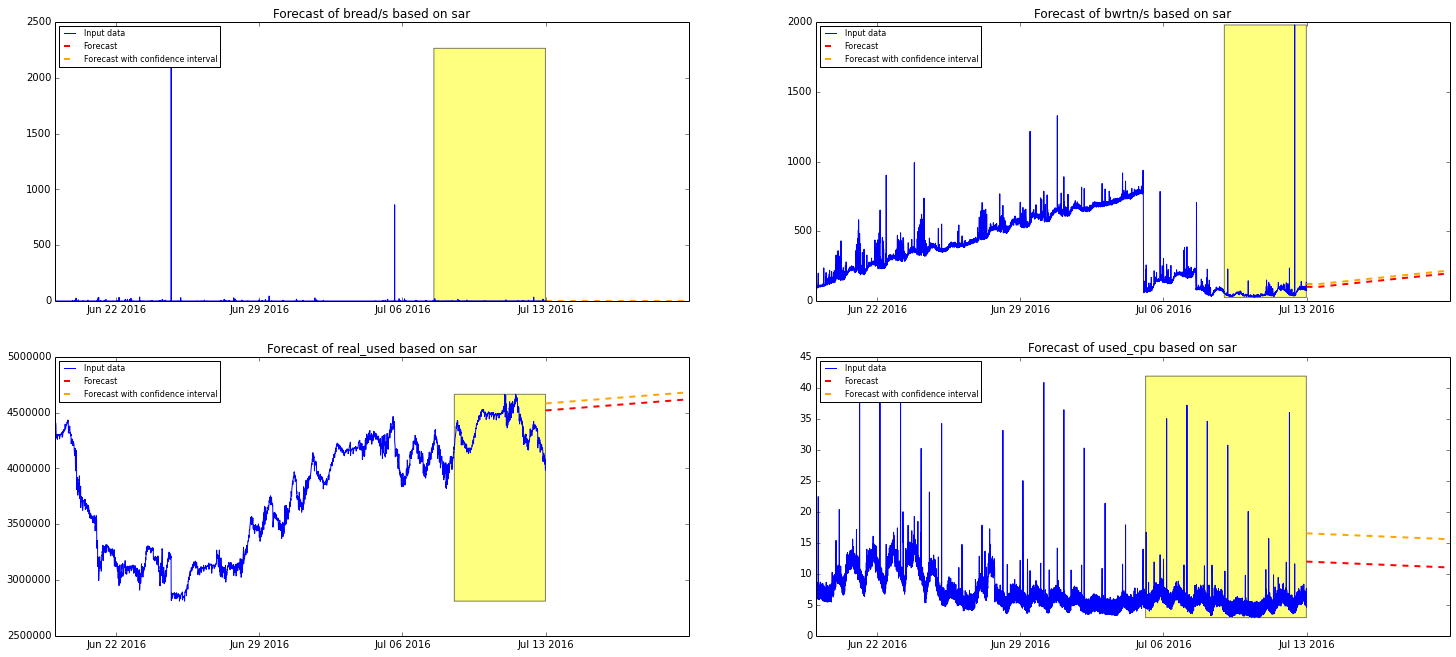

web118.eta.prod.ed1


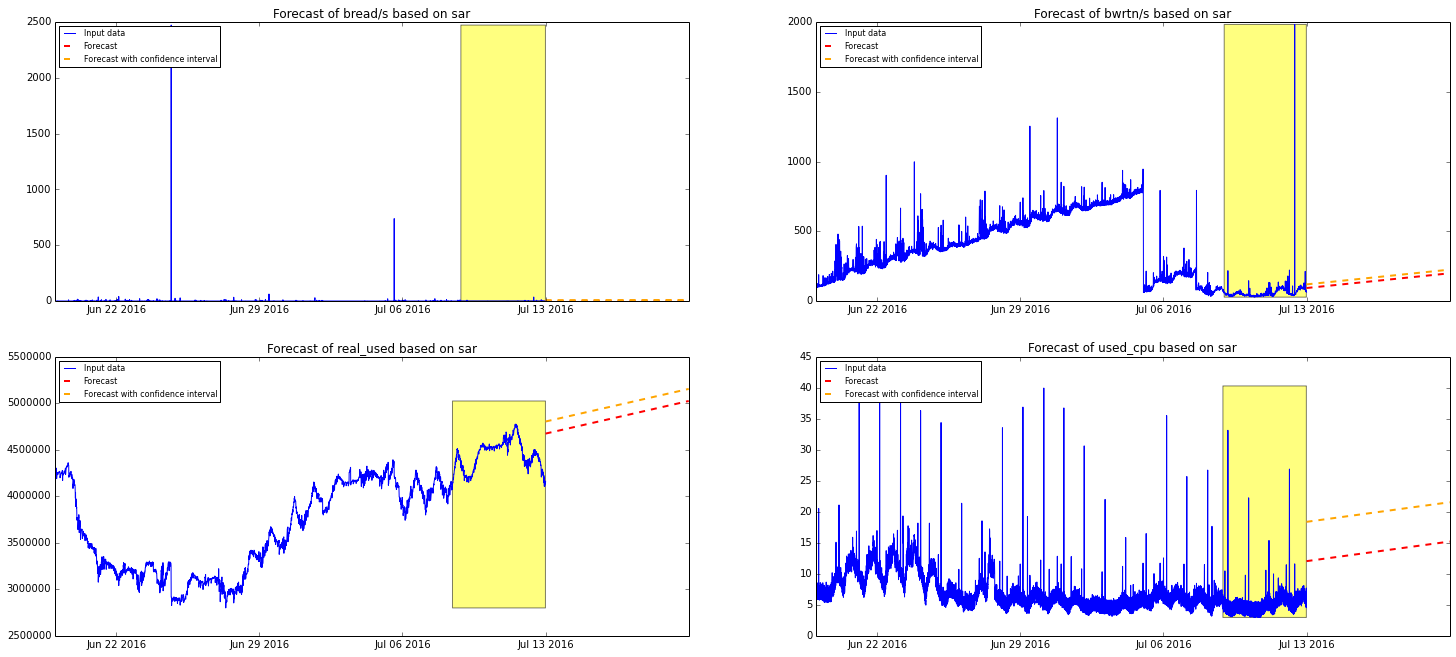

web119.eta.prod.ed1


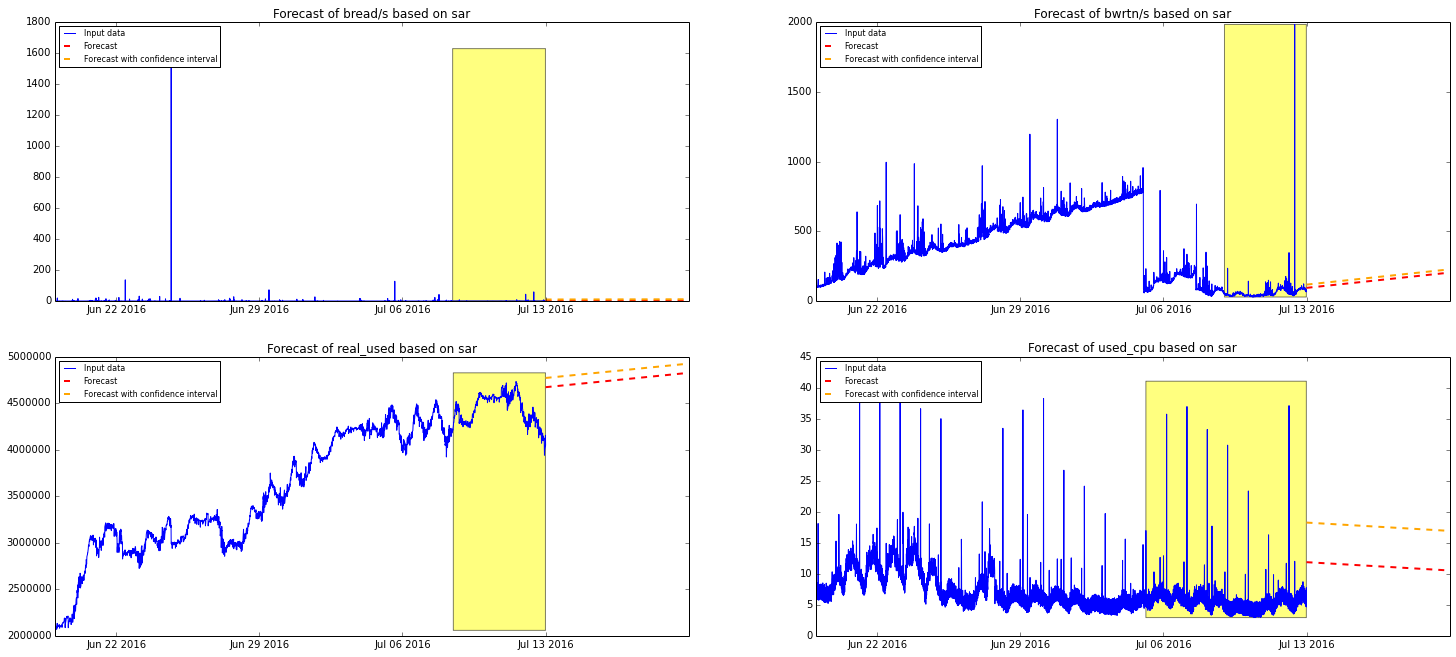

web101.eta.prod.ed5


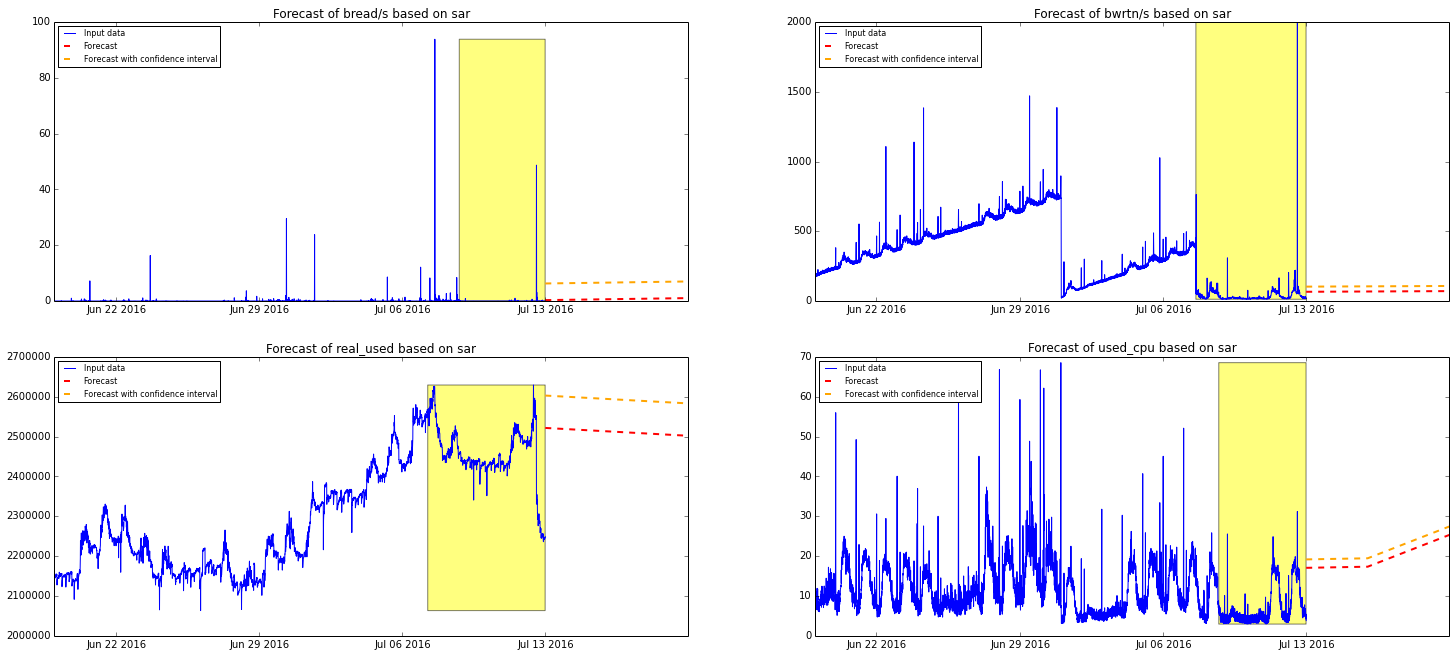

web102.eta.prod.ed5


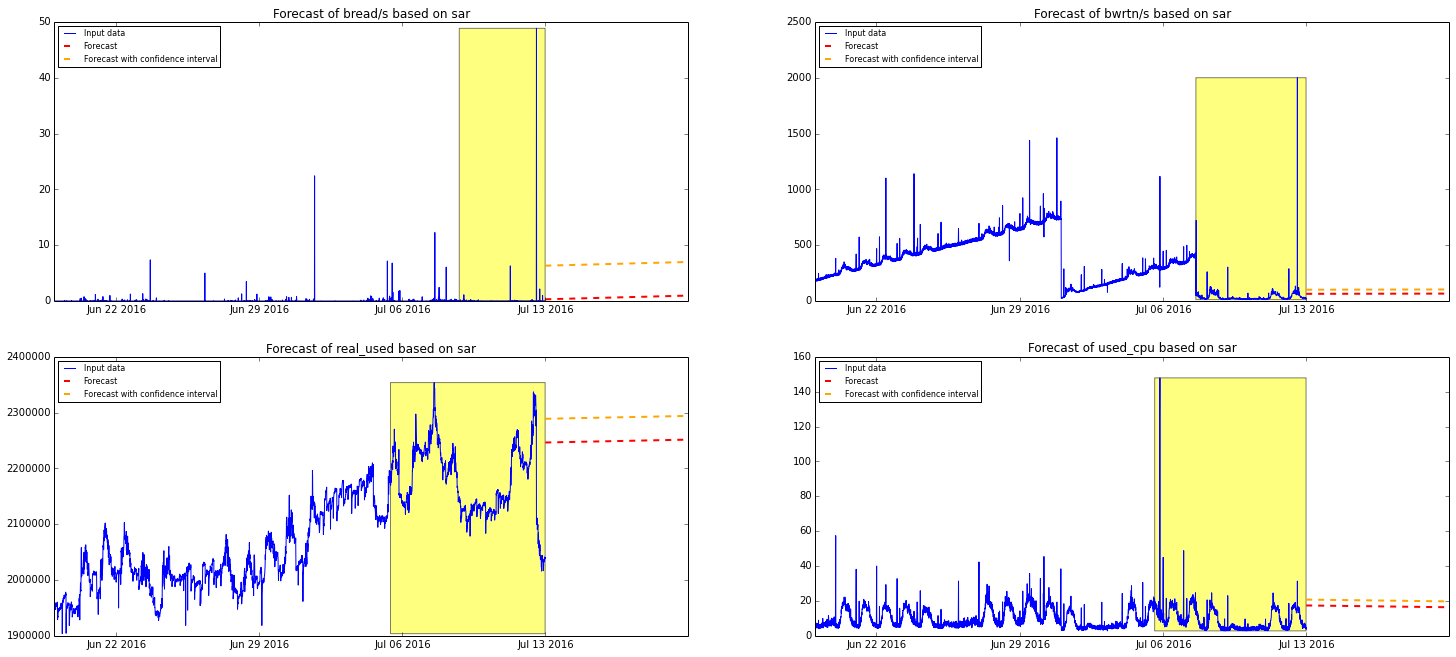

web103.eta.prod.ed5


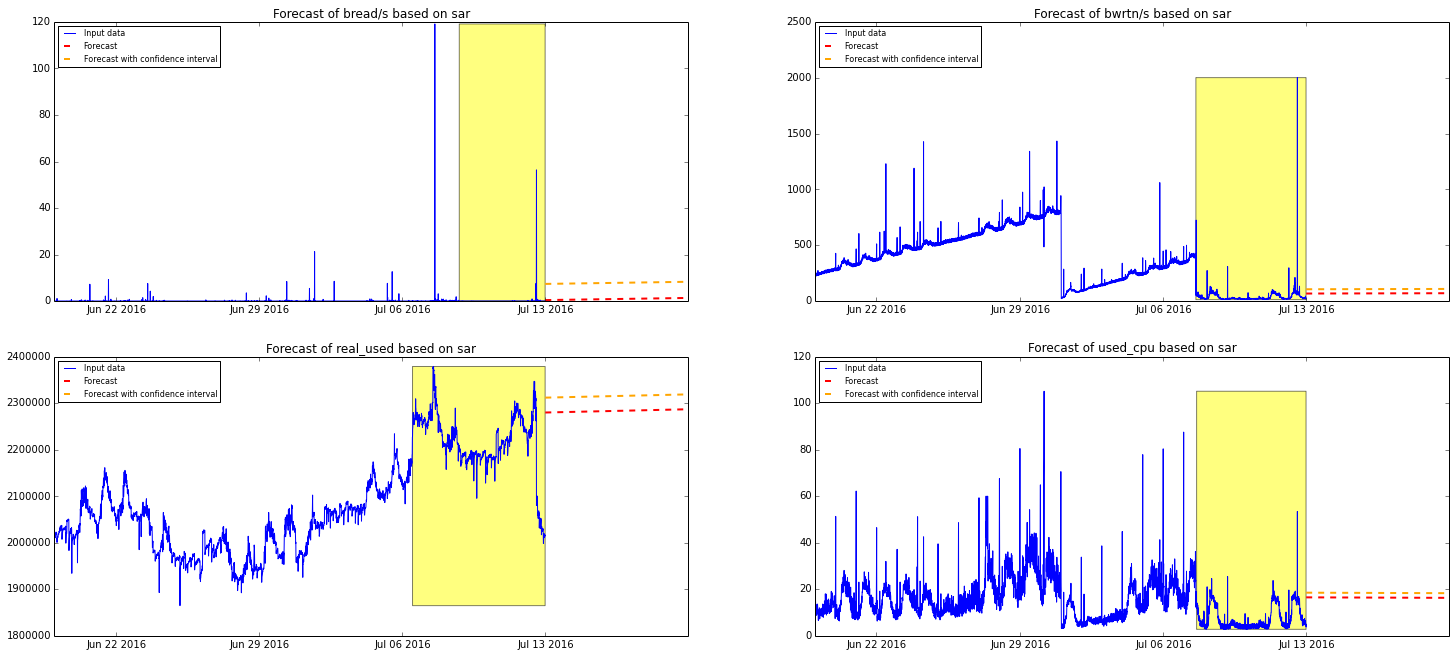

web104.eta.prod.ed5


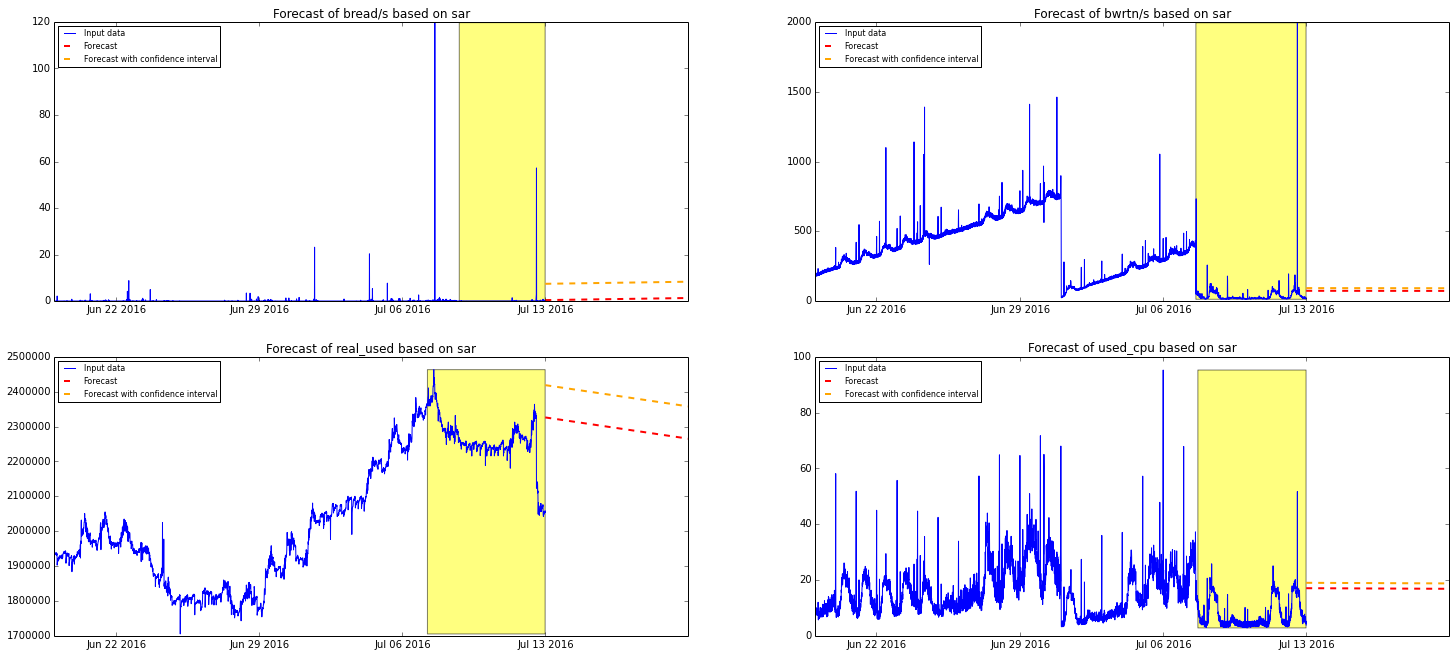

web105.eta.prod.ed5


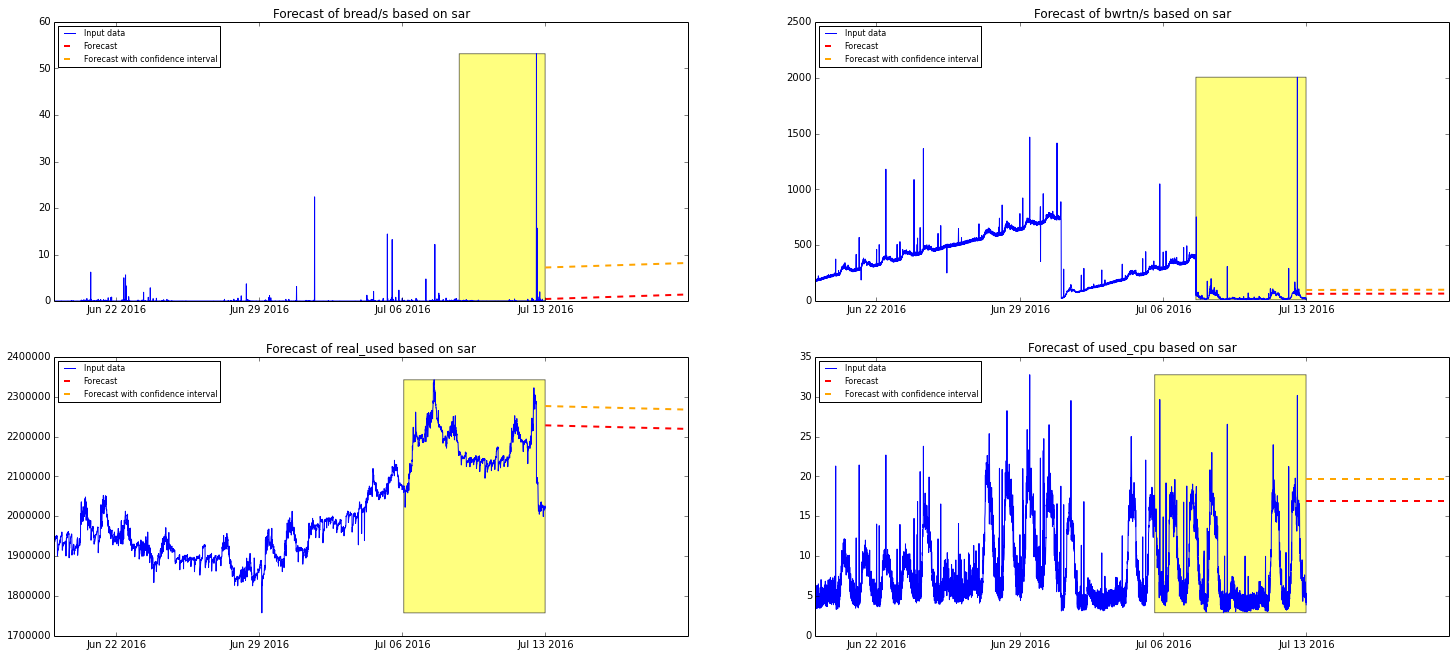

web106.eta.prod.ed5


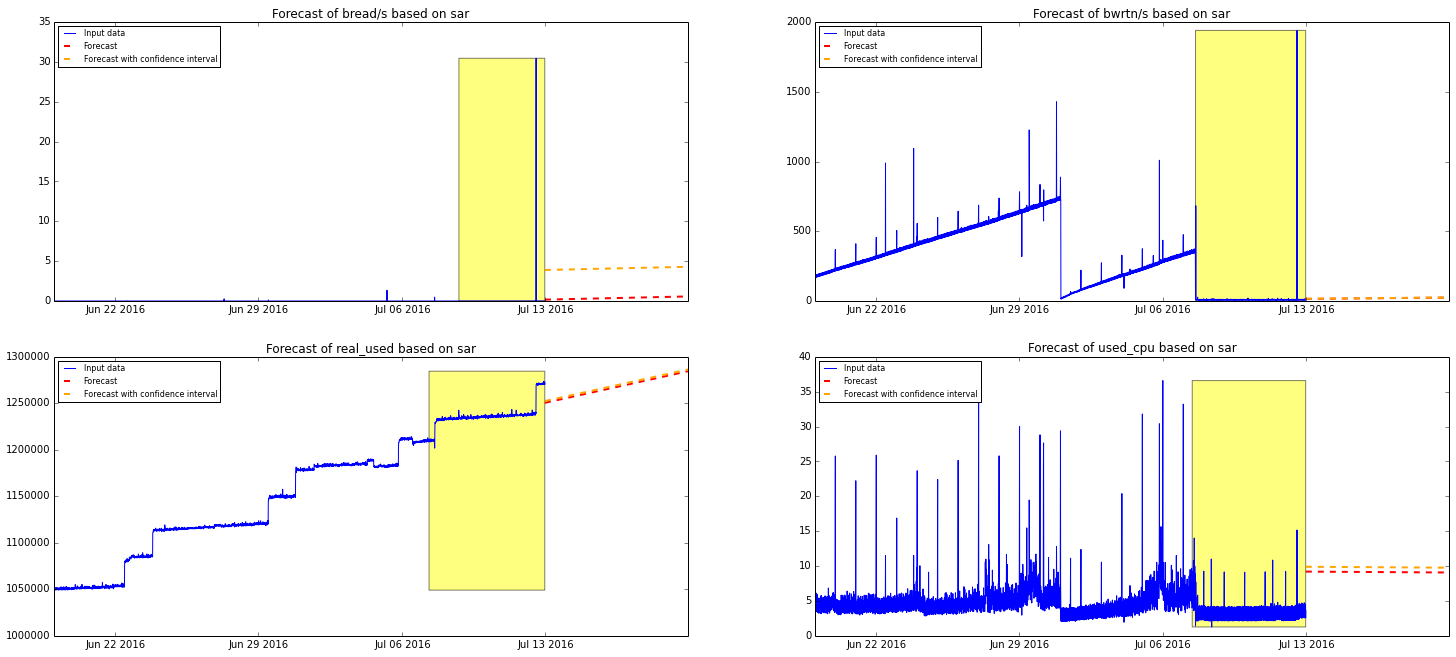

web107.eta.prod.ed5


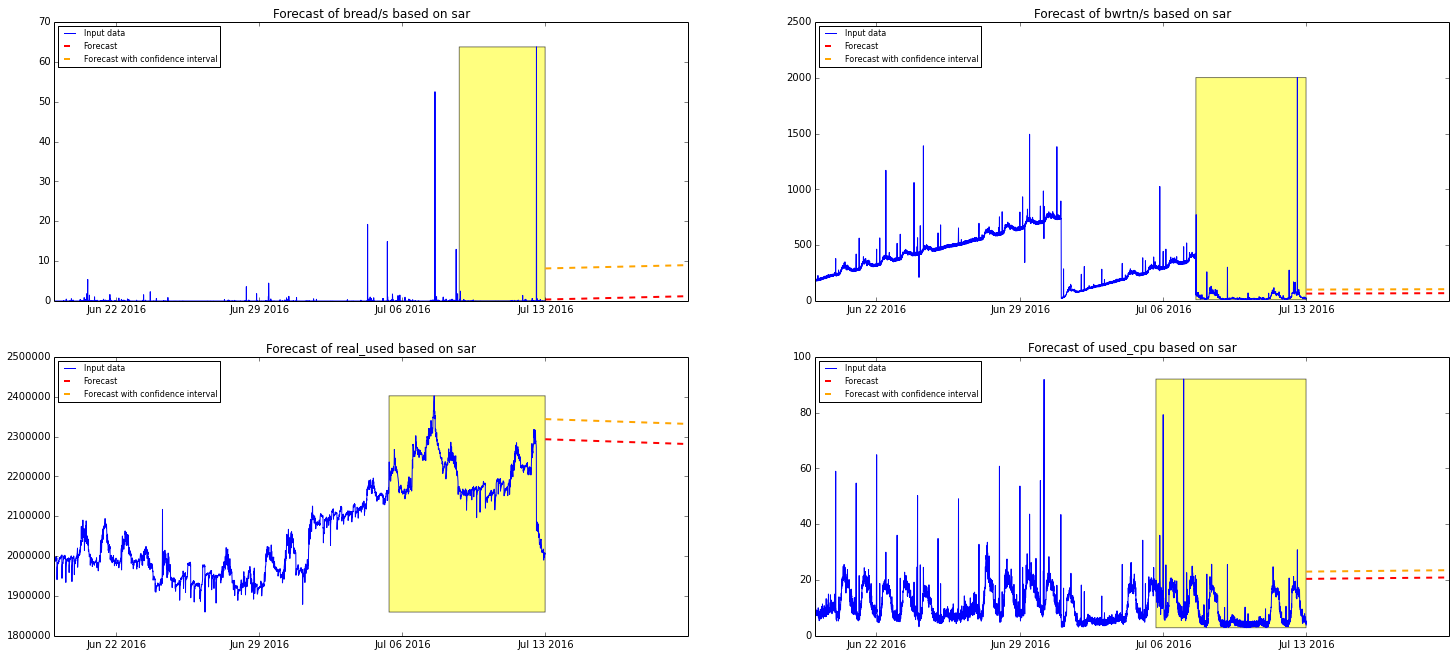

web108.eta.prod.ed5


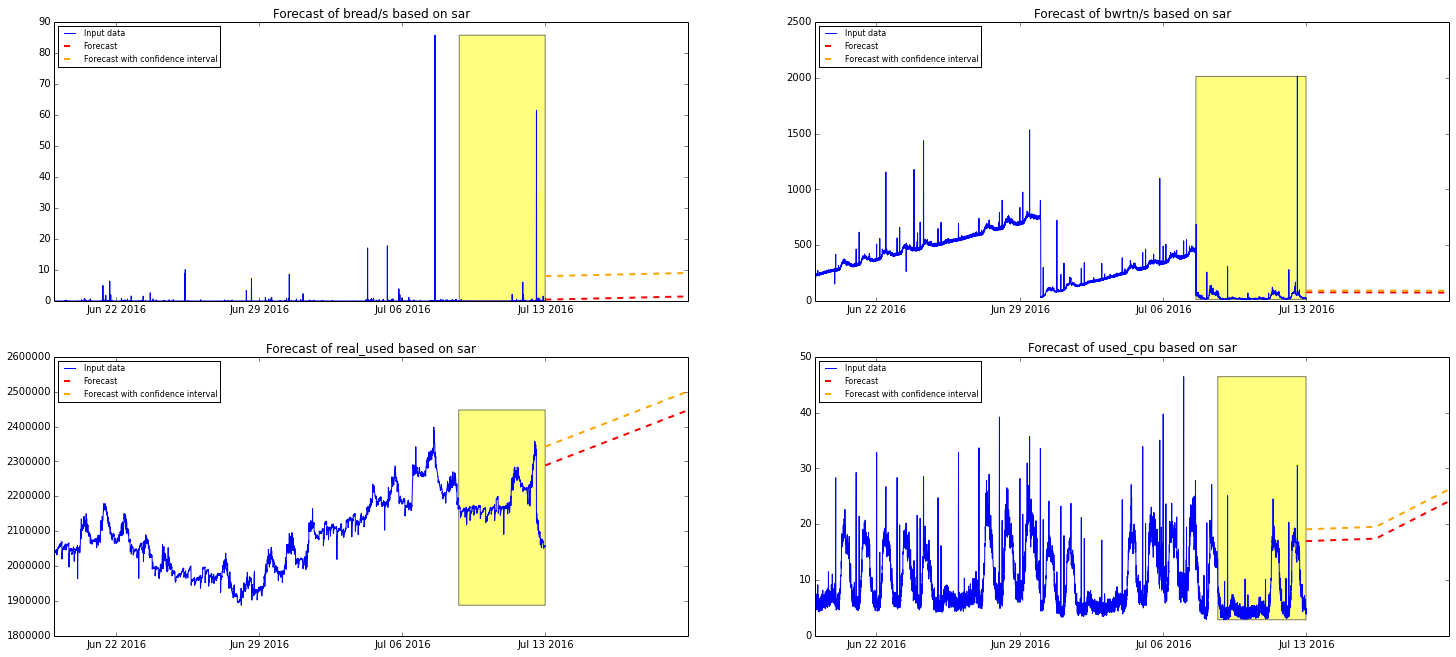

services101.eta.prod.ed1


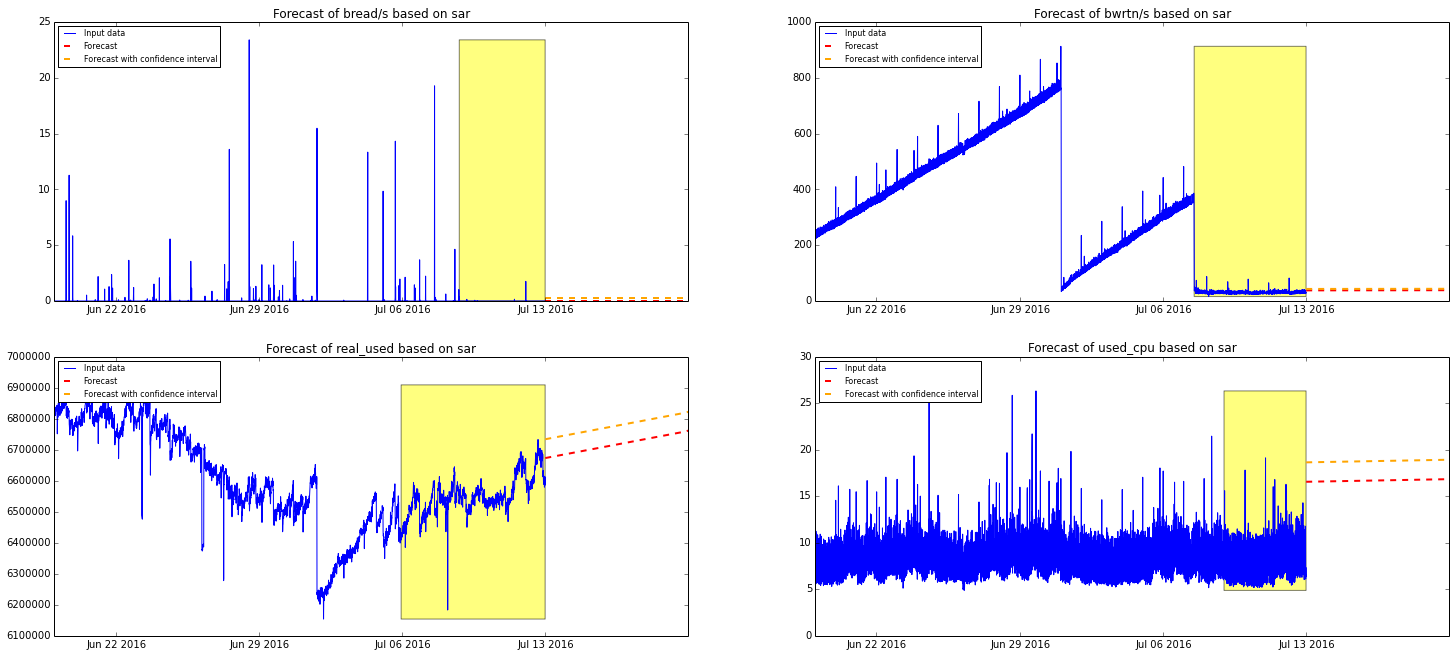

services102.eta.prod.ed1


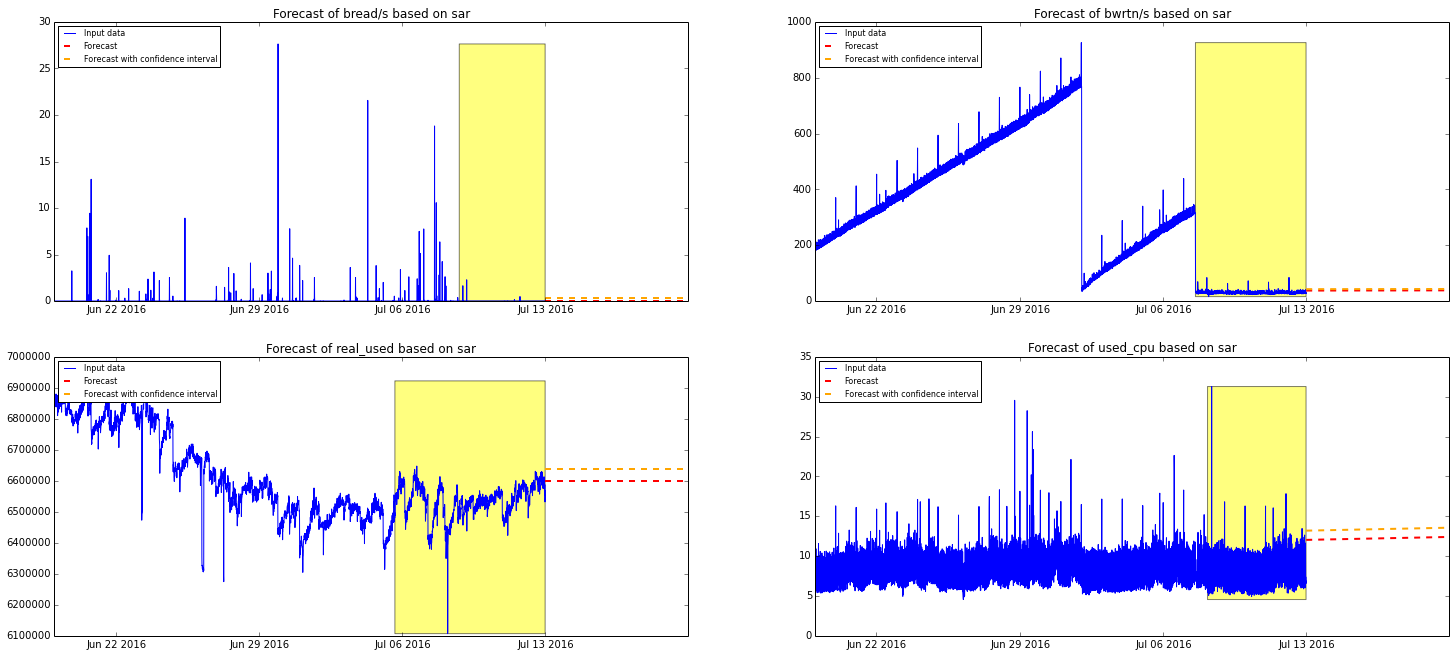

services103.eta.prod.ed1


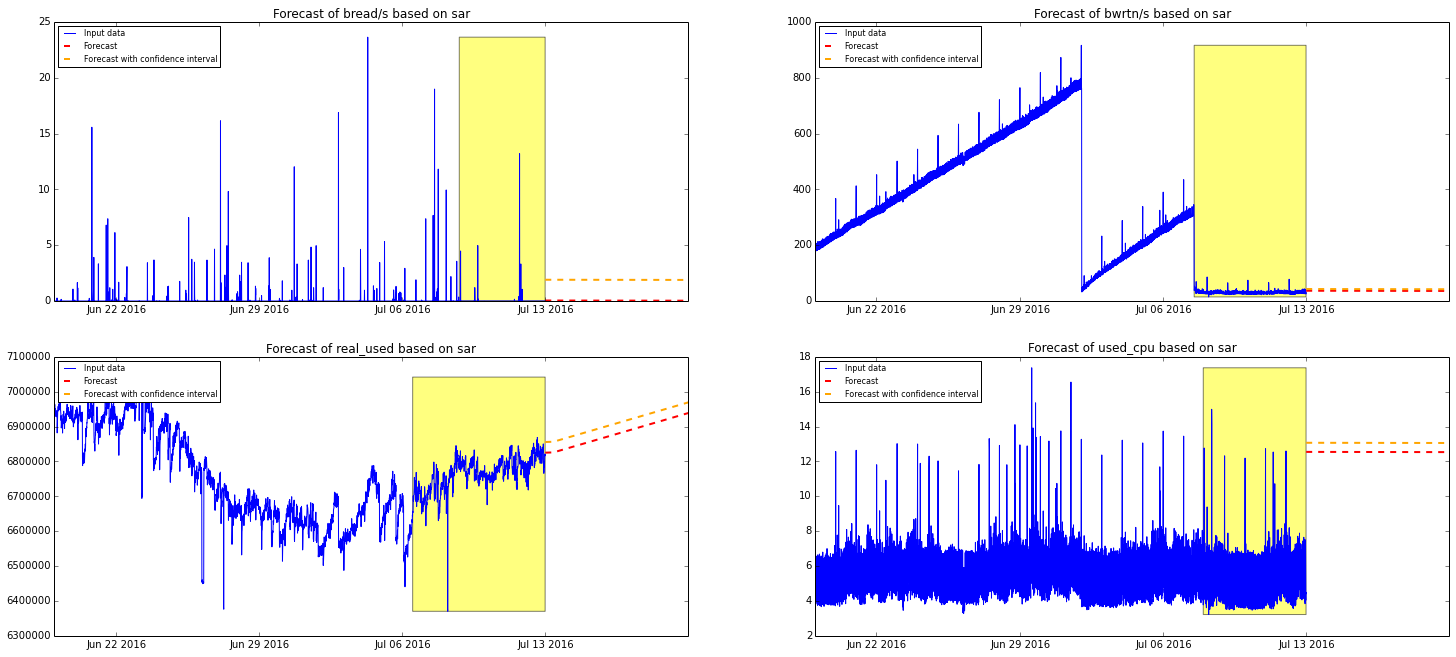

services104.eta.prod.ed1


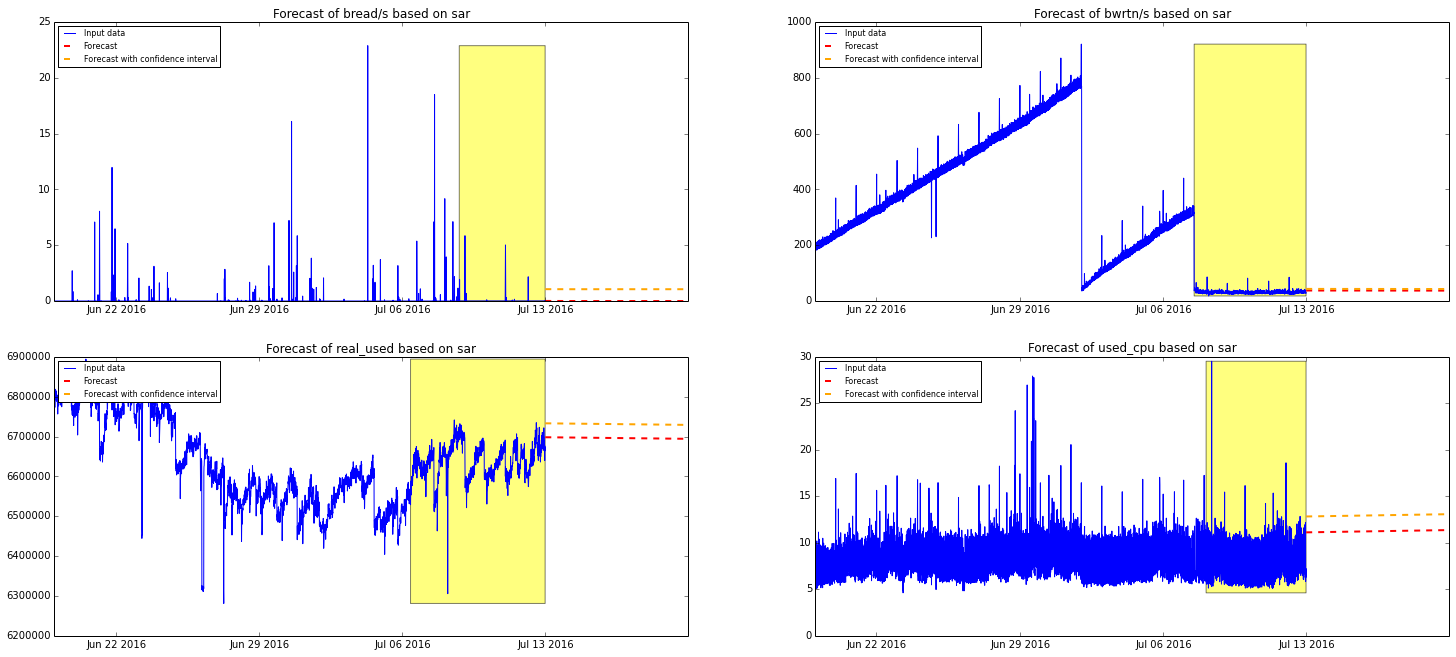

services105.eta.prod.ed1


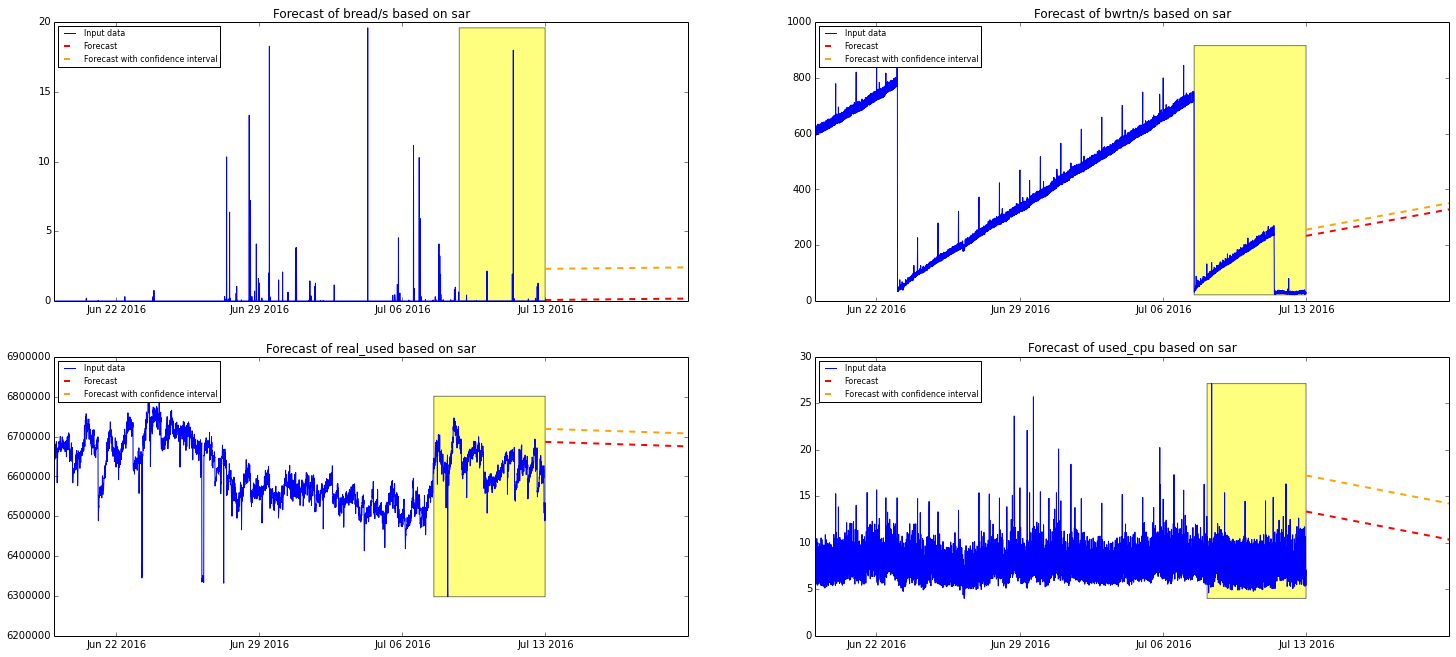

services101.eta.prod.ed5


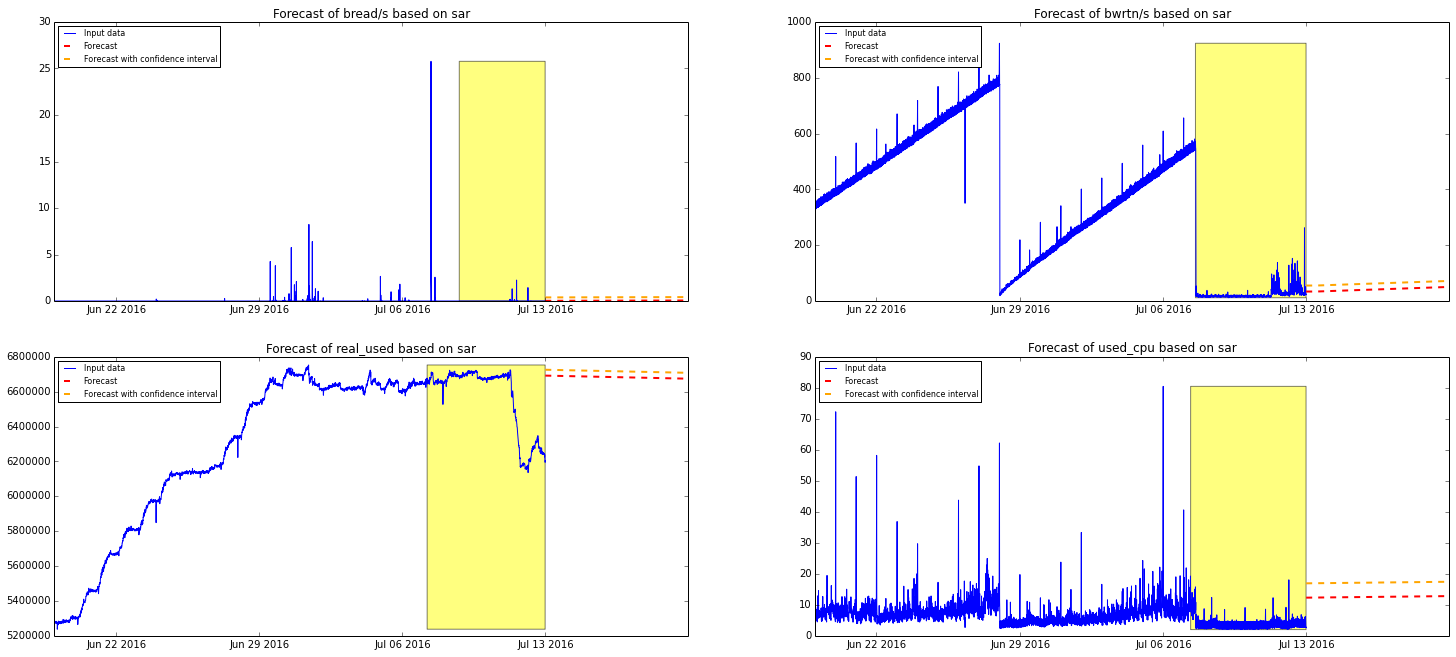

services102.eta.prod.ed5


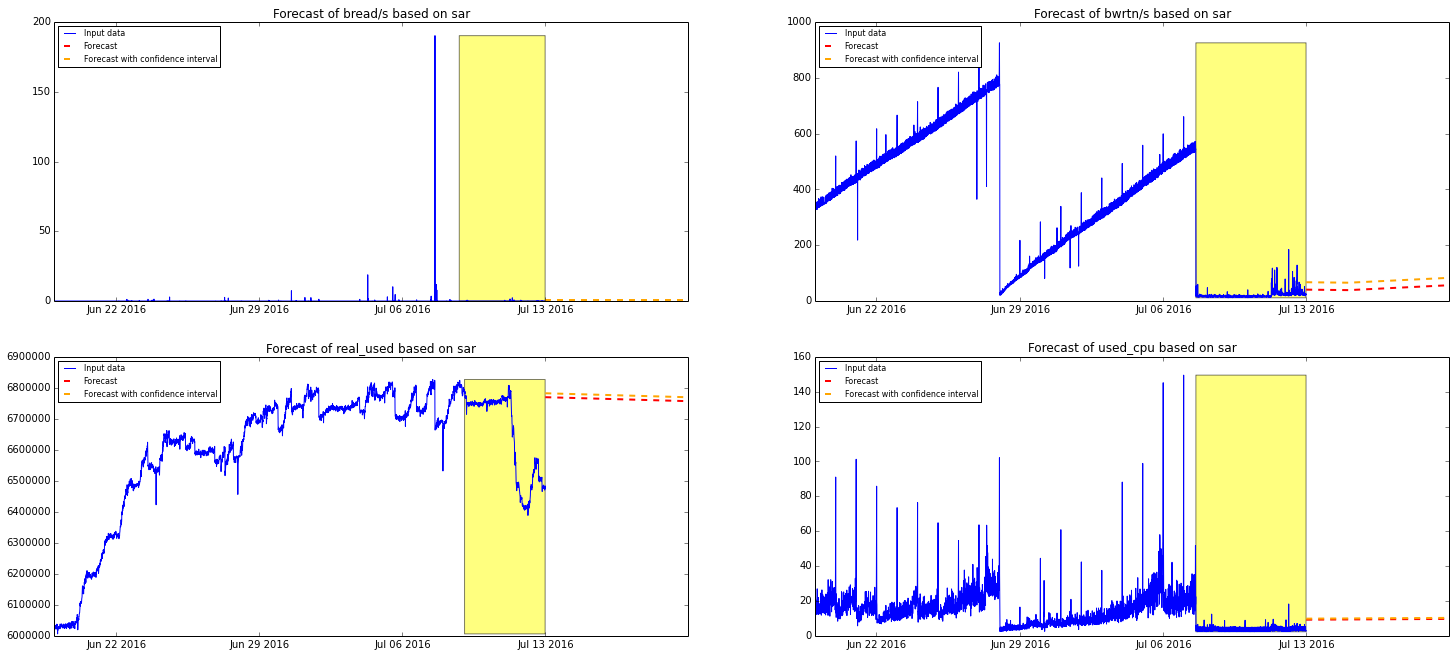

services103.eta.prod.ed5


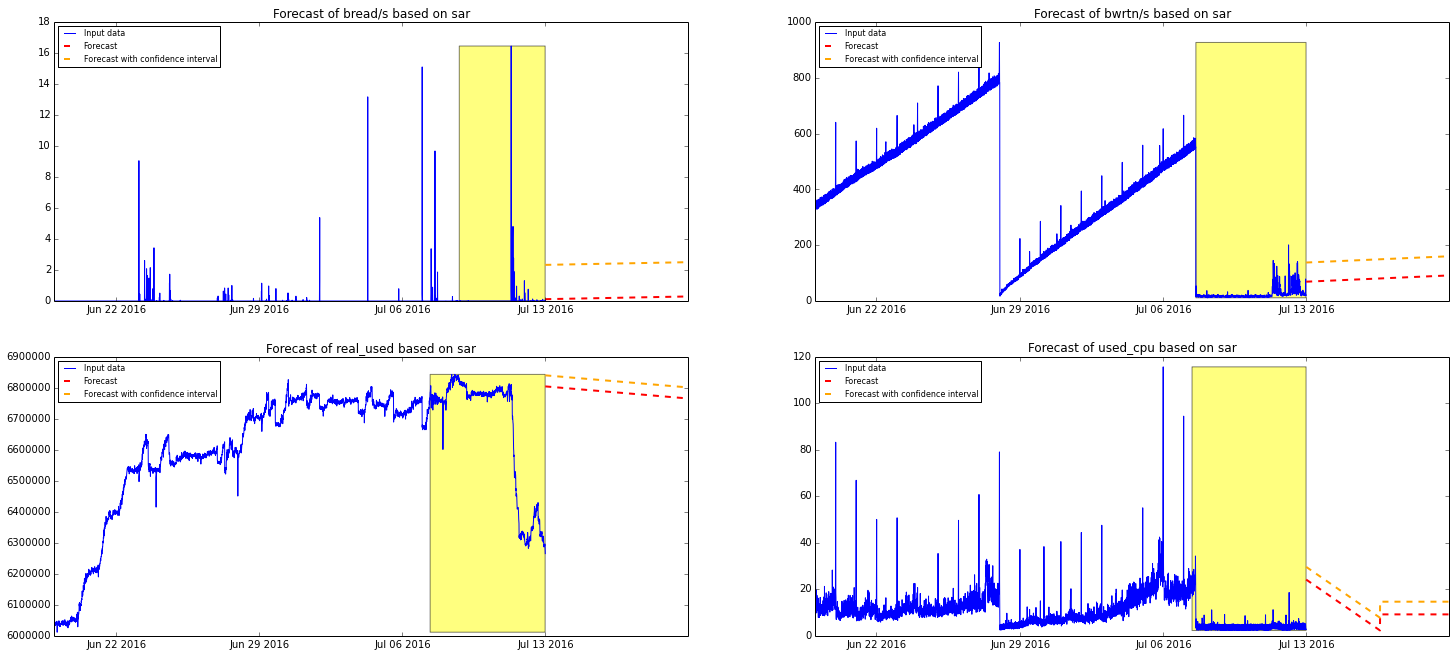

services104.eta.prod.ed5


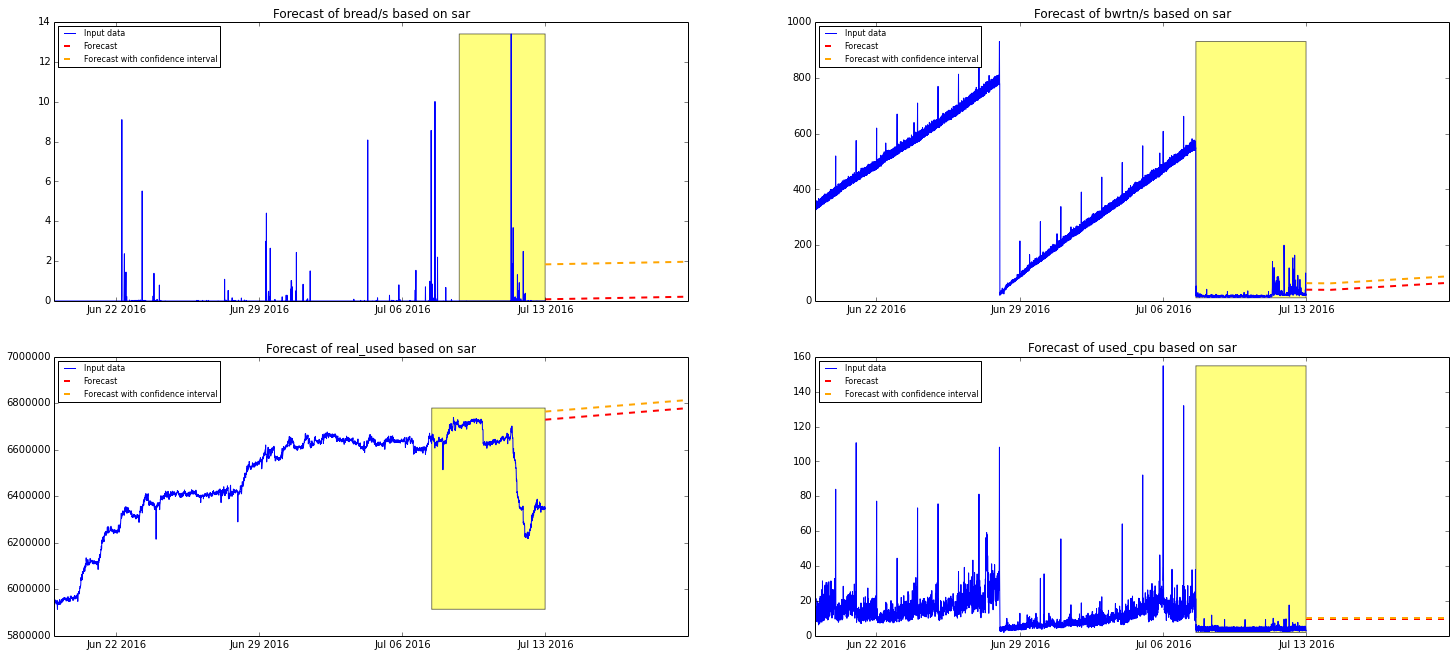

fs101.eta.prod.ed1


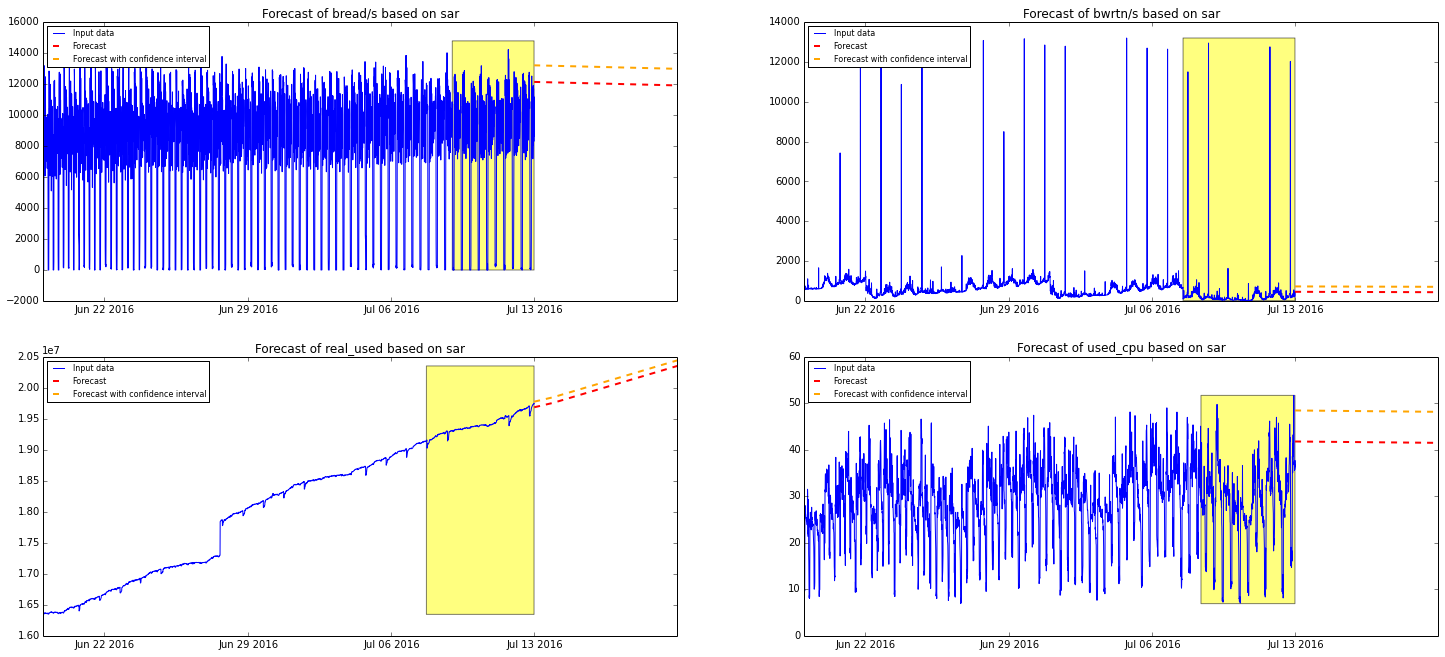

fs102.eta.prod.ed1


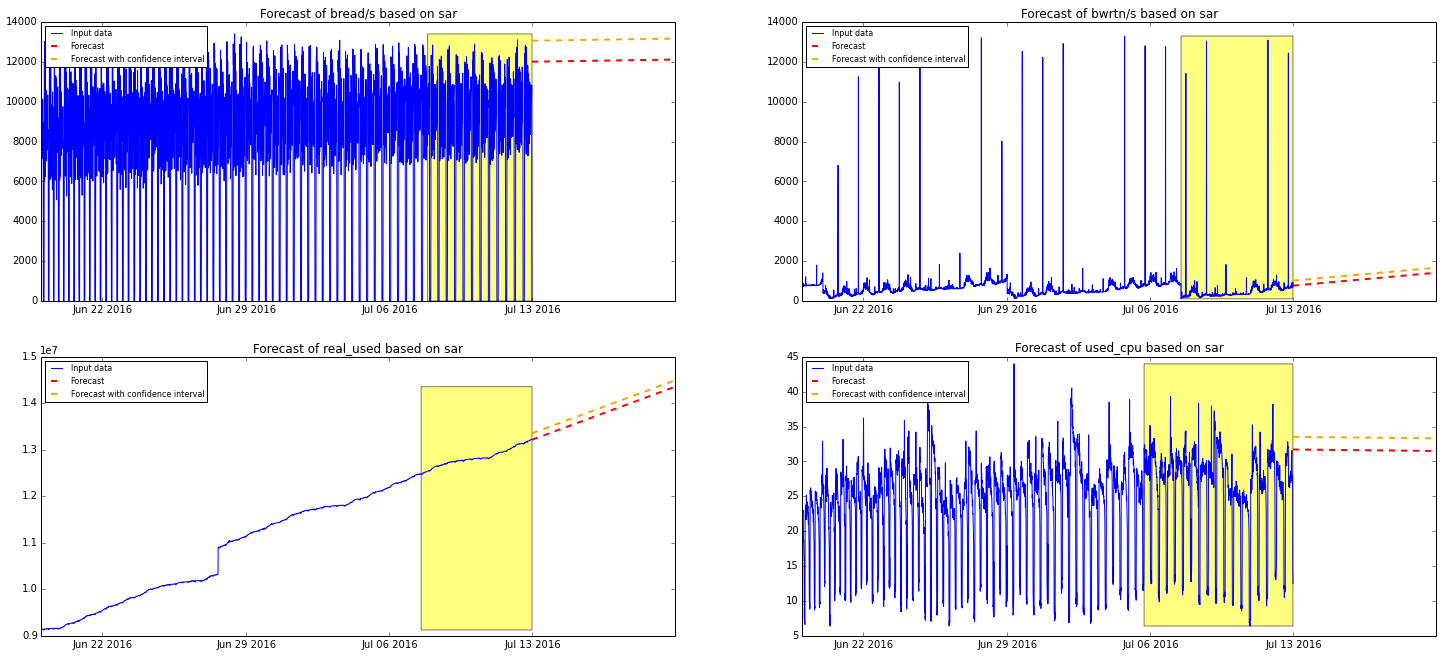

fs101.eta.prod.ed5


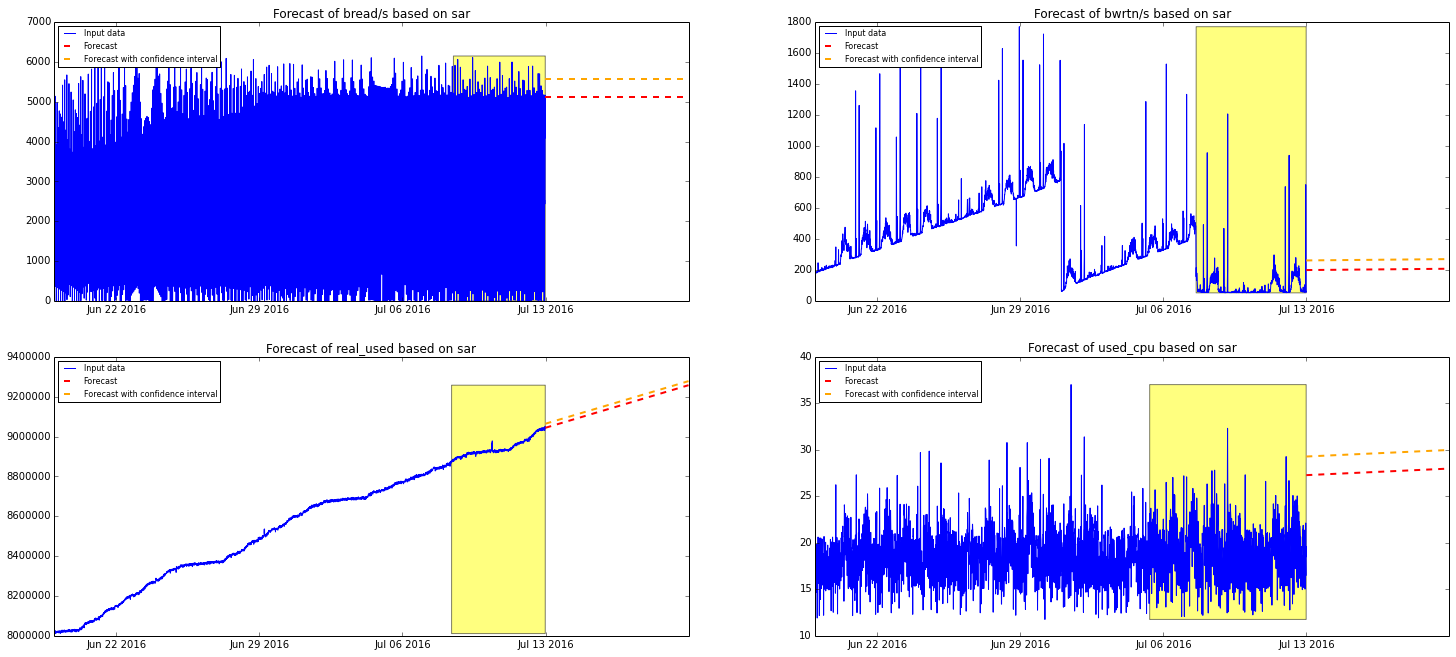

fs102.eta.prod.ed5


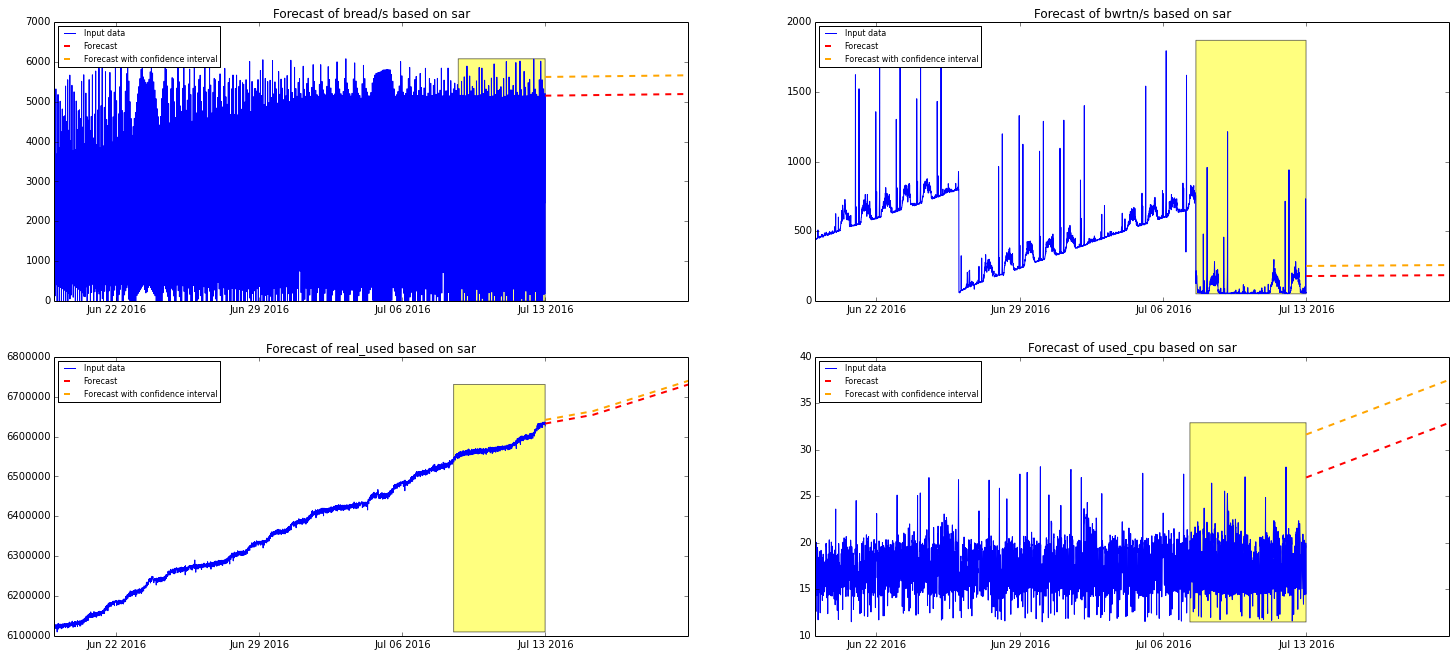

ha101.eta.prod.ed1


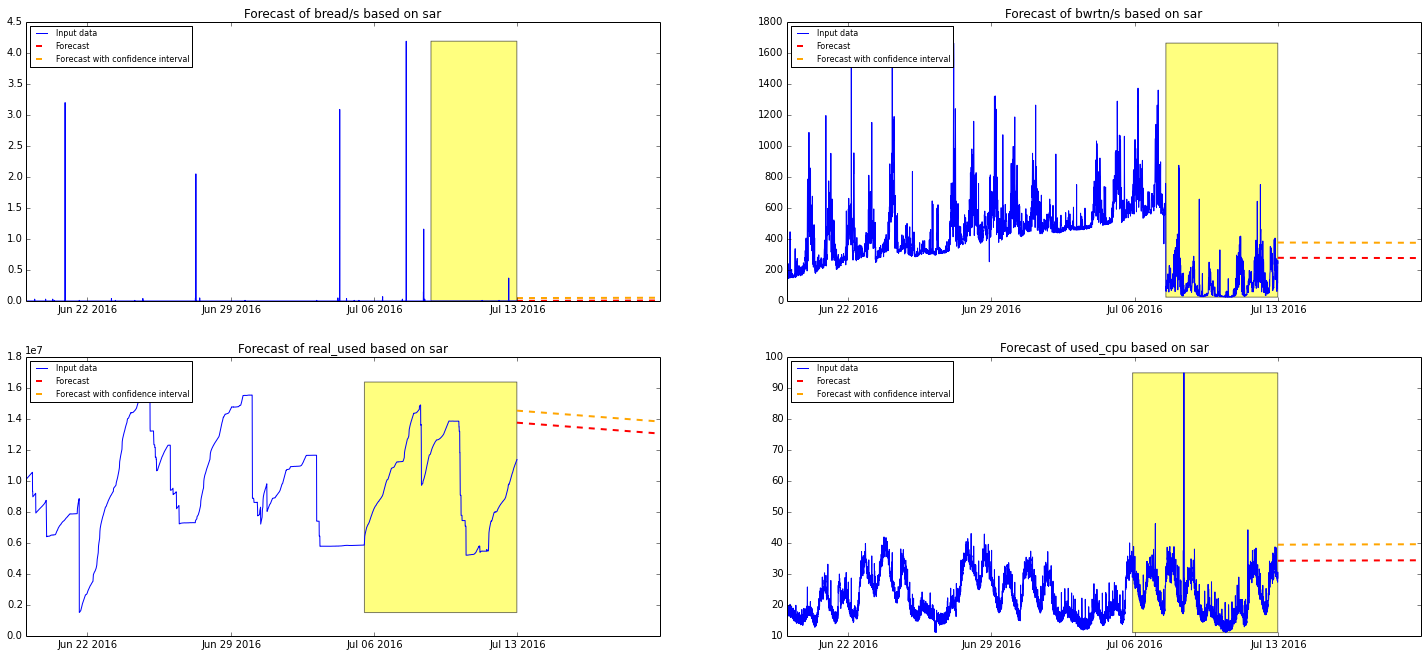

ha102.eta.prod.ed1


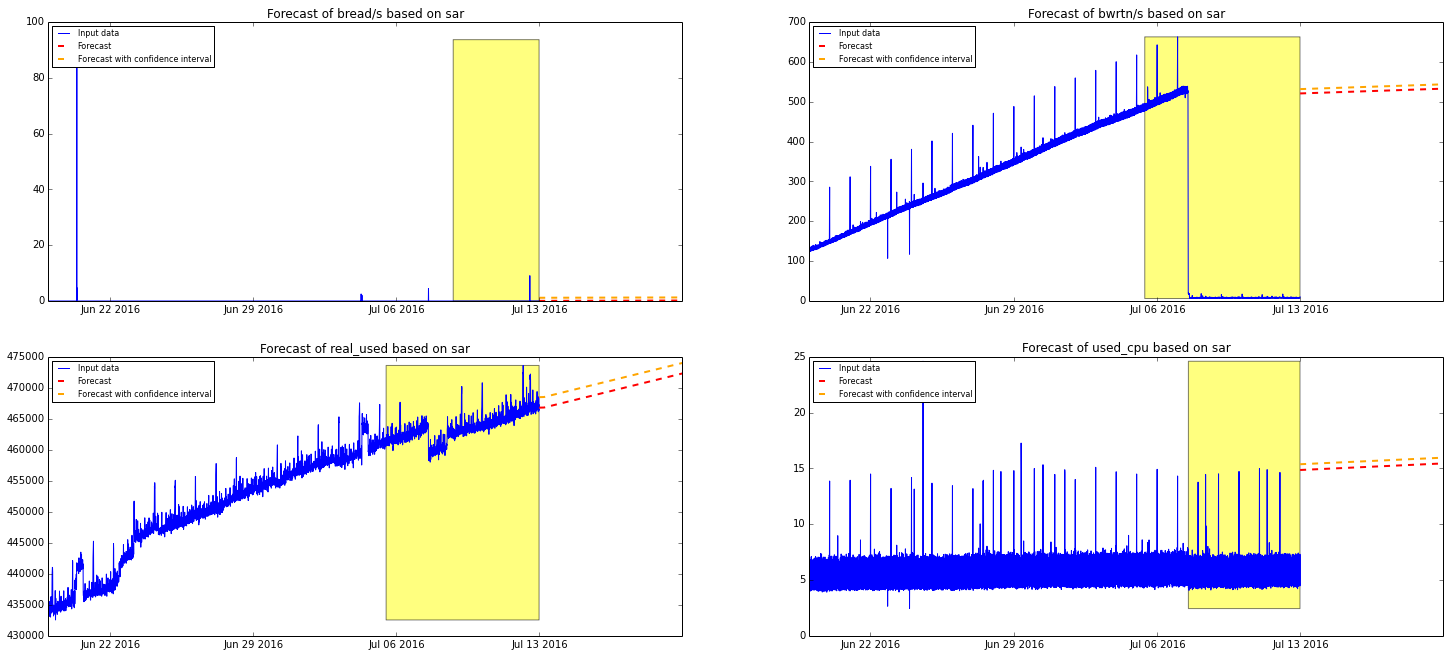

ha101.eta.prod.ed5


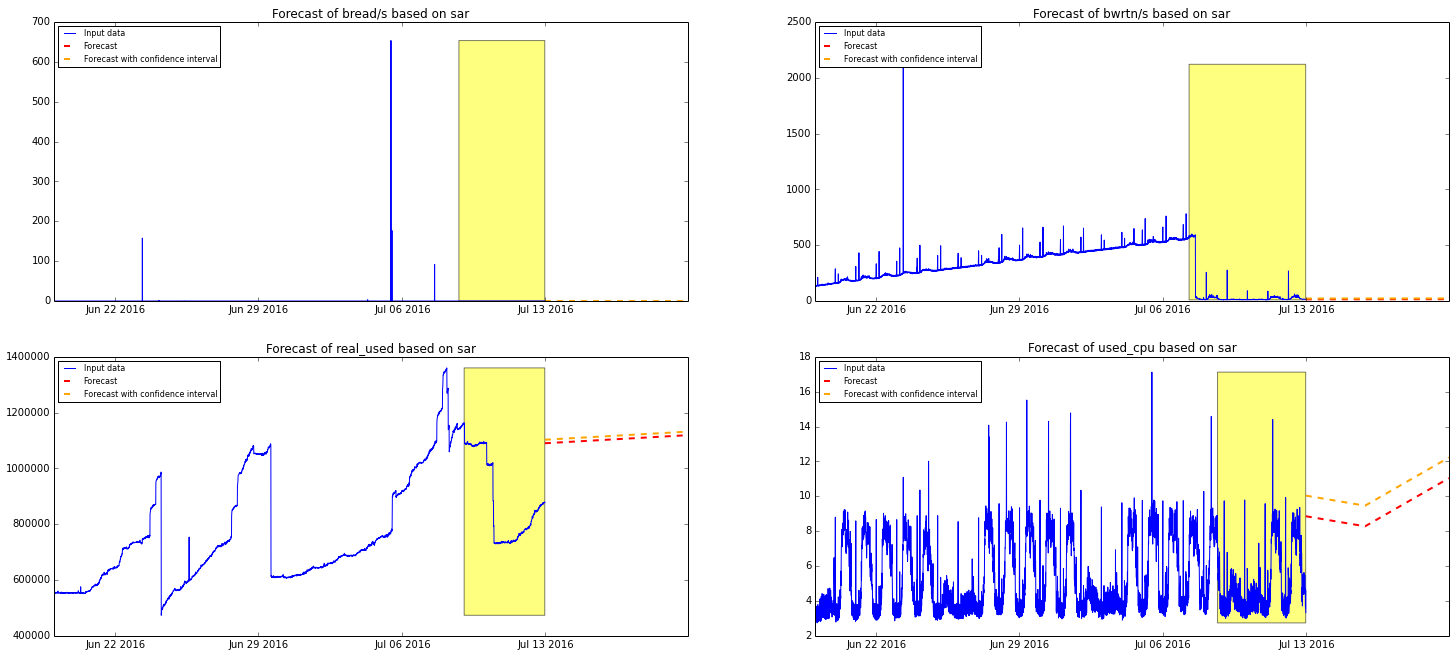

ha102.eta.prod.ed5


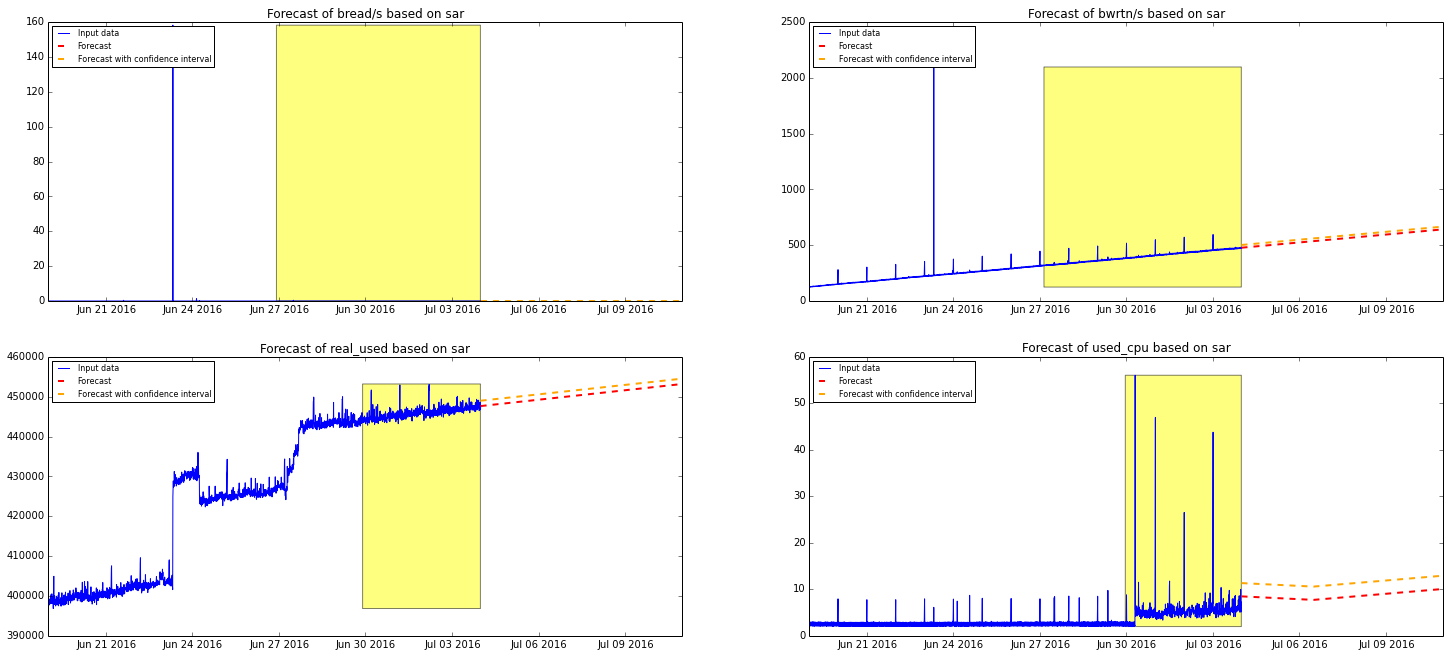

red101.eta.prod.ed1


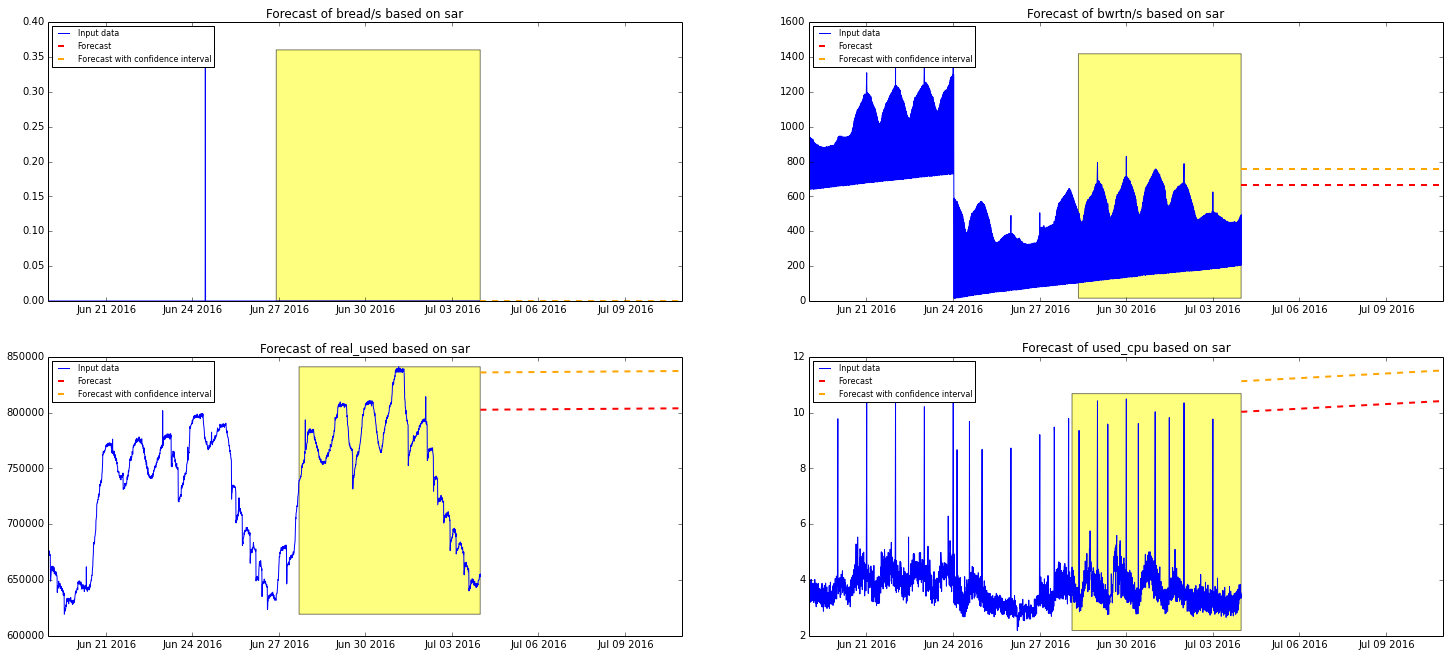

red102.eta.prod.ed1


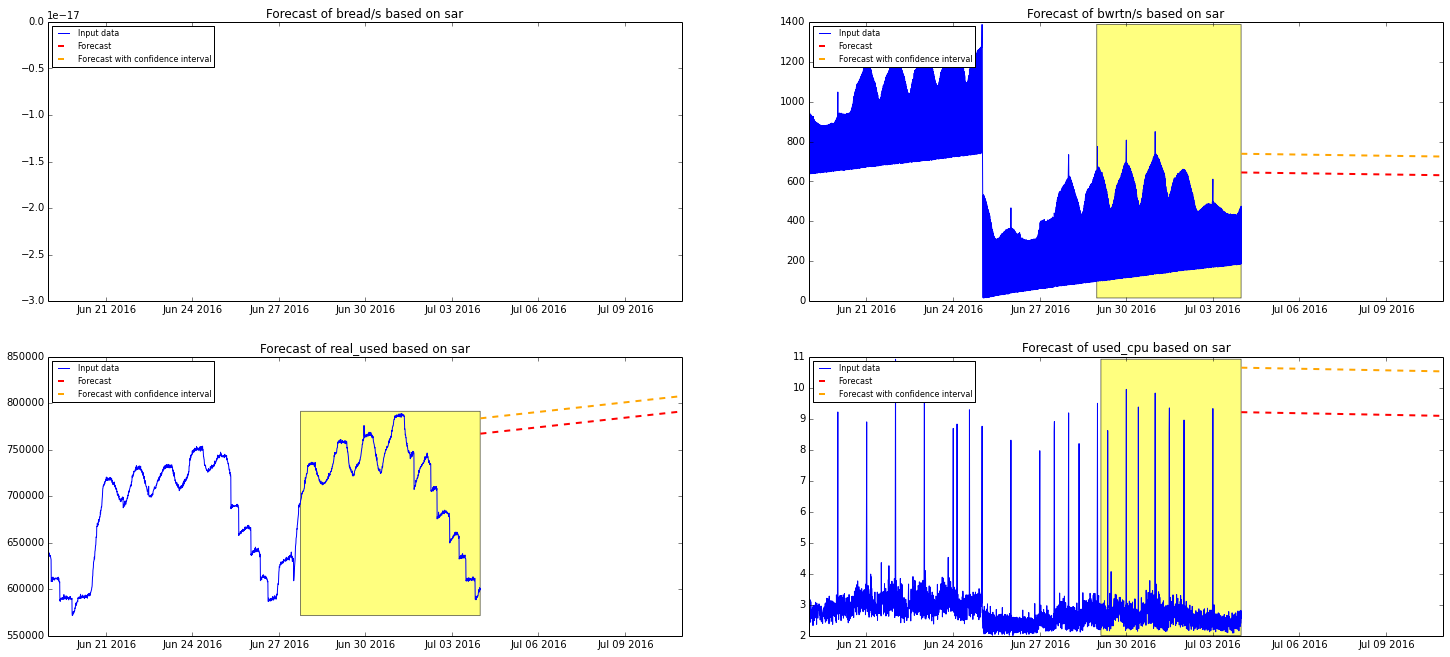

red103.eta.prod.ed1


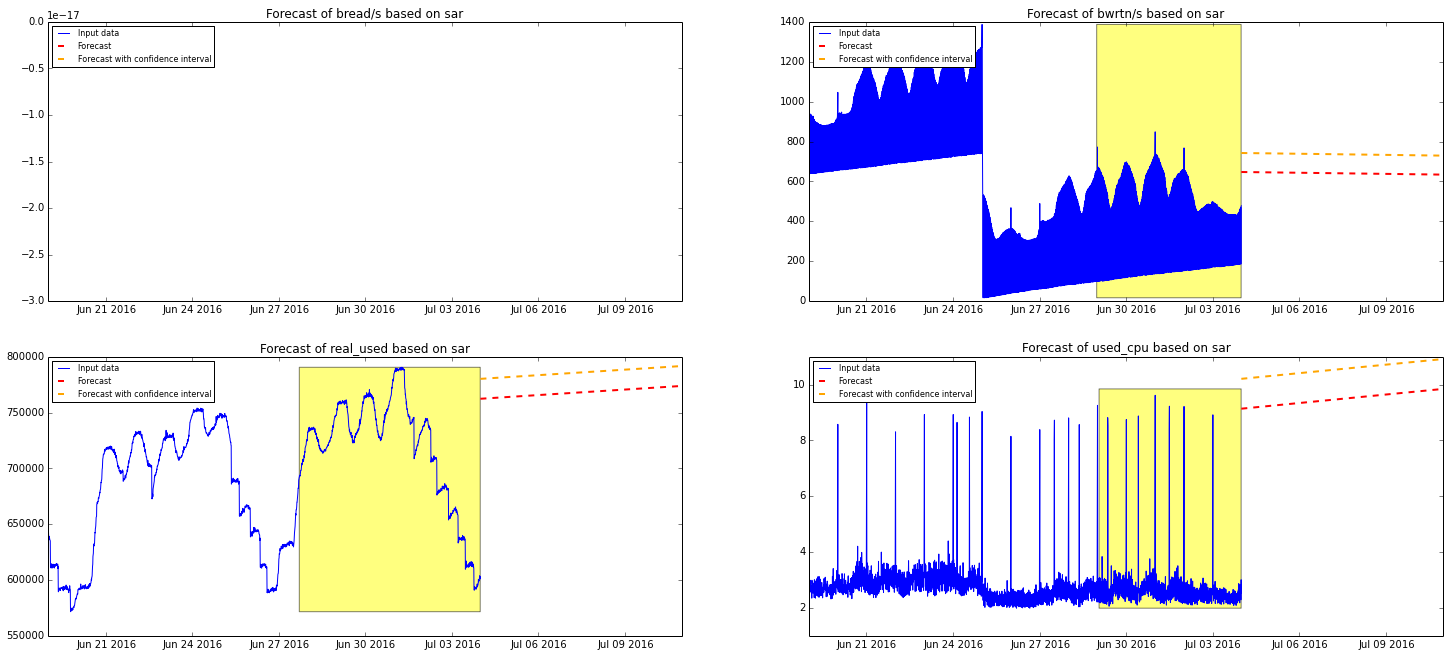

red101.eta.prod.ed5


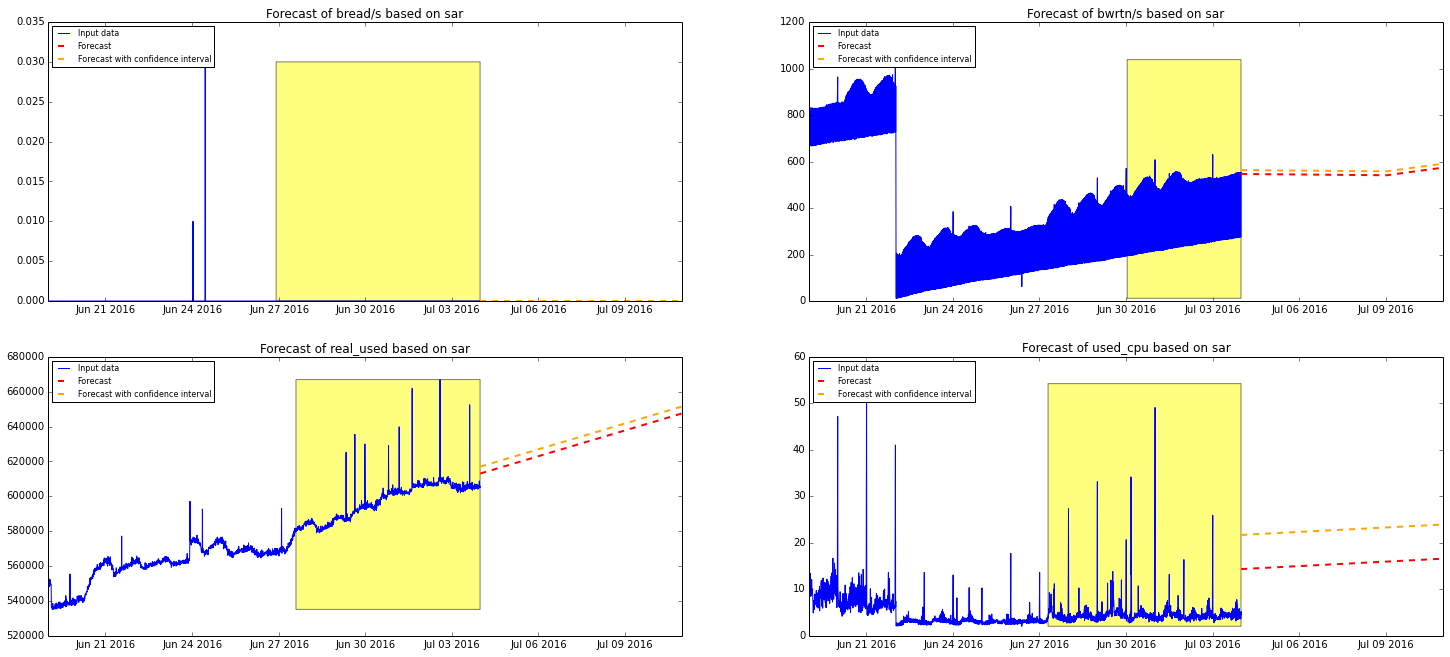

red102.eta.prod.ed5


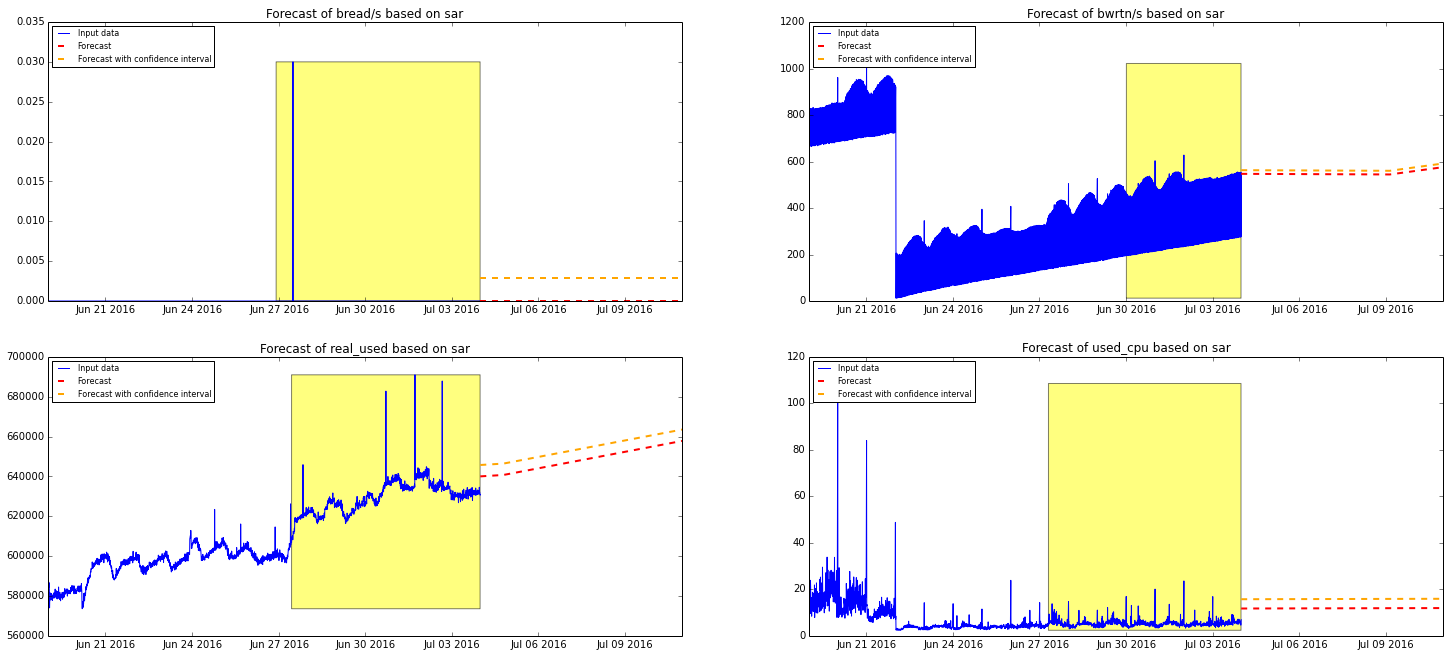

red103.eta.prod.ed5


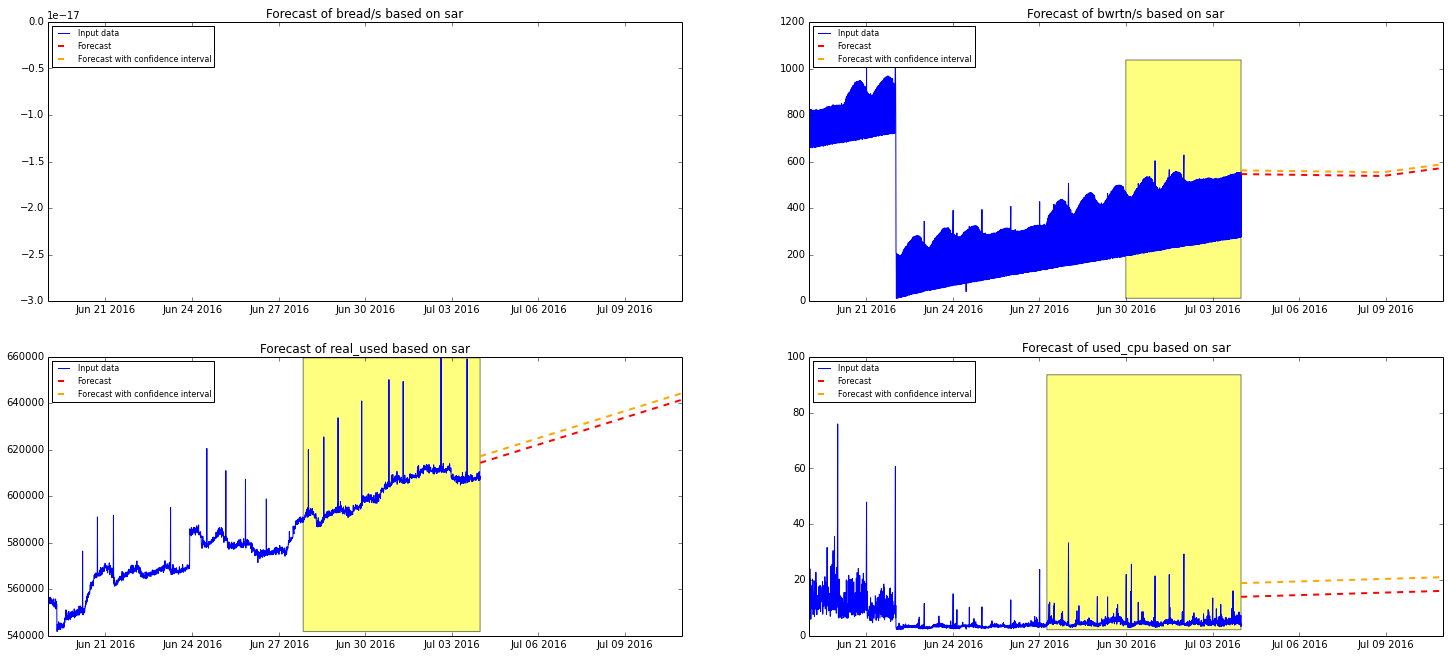

red104.eta.prod.ed1


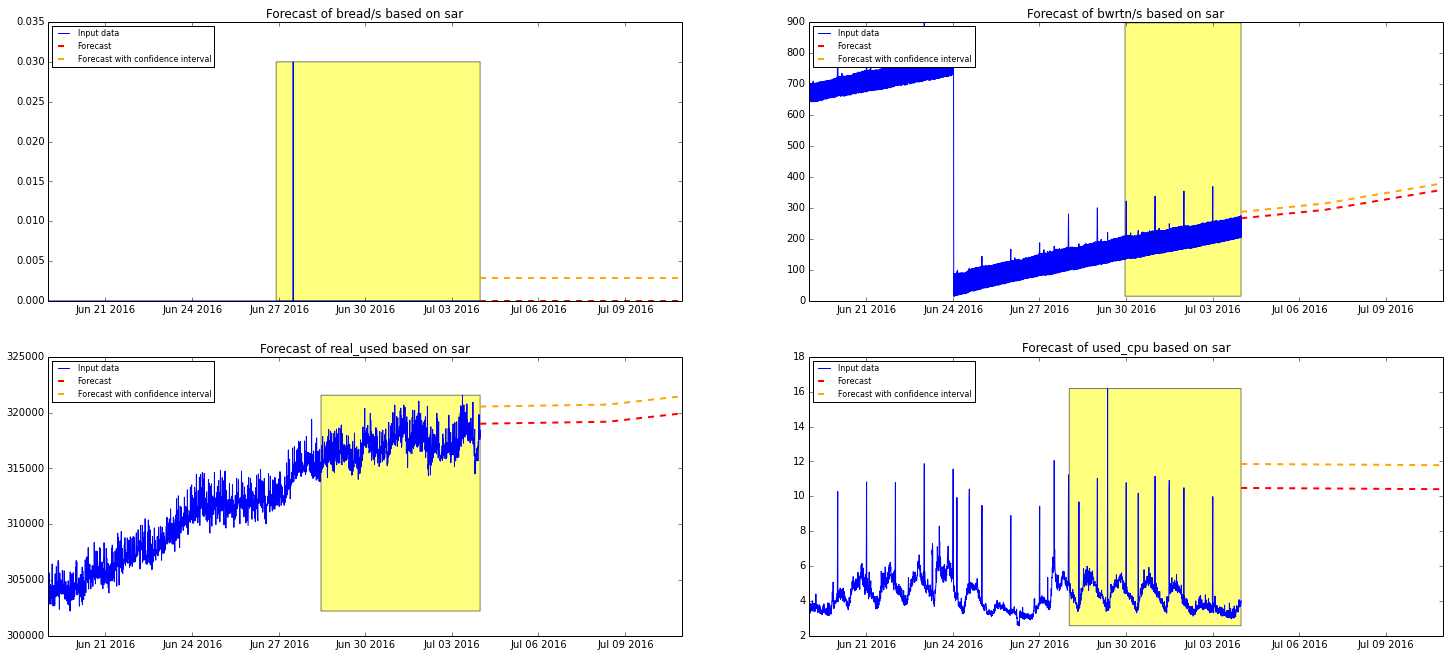

red105.eta.prod.ed1


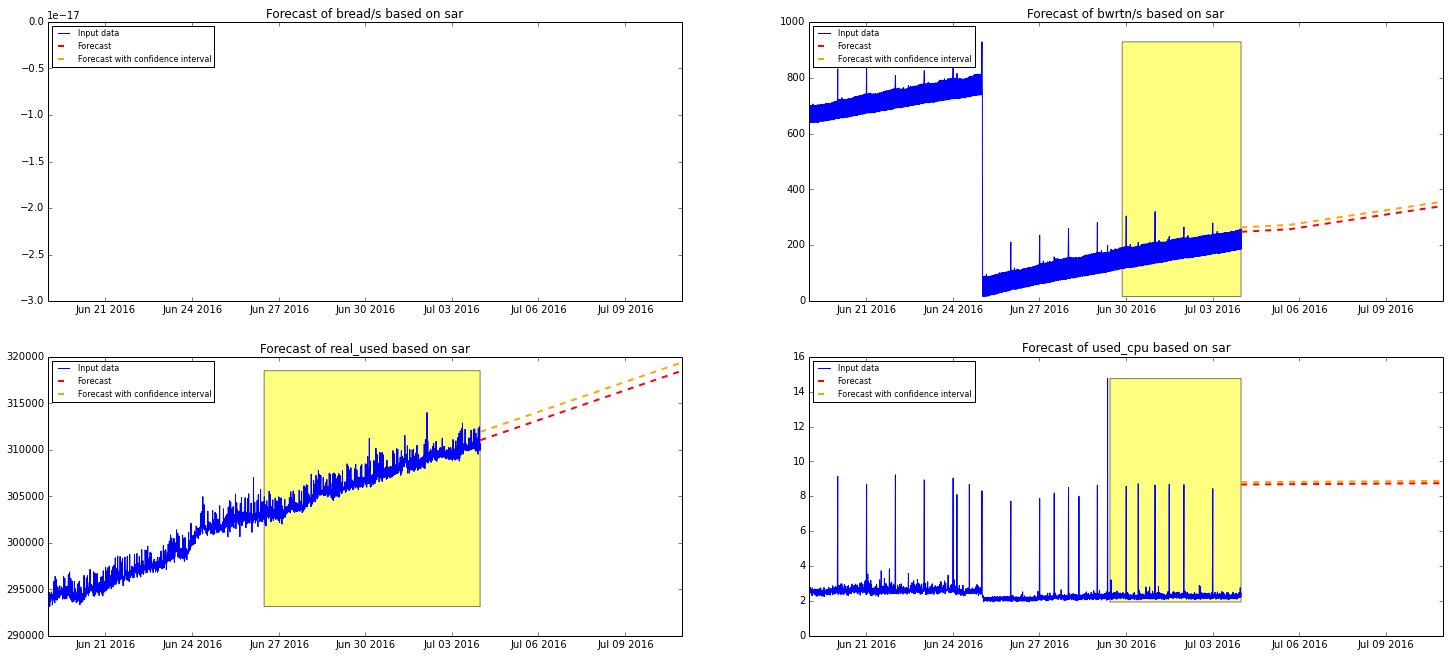

red106.eta.prod.ed1


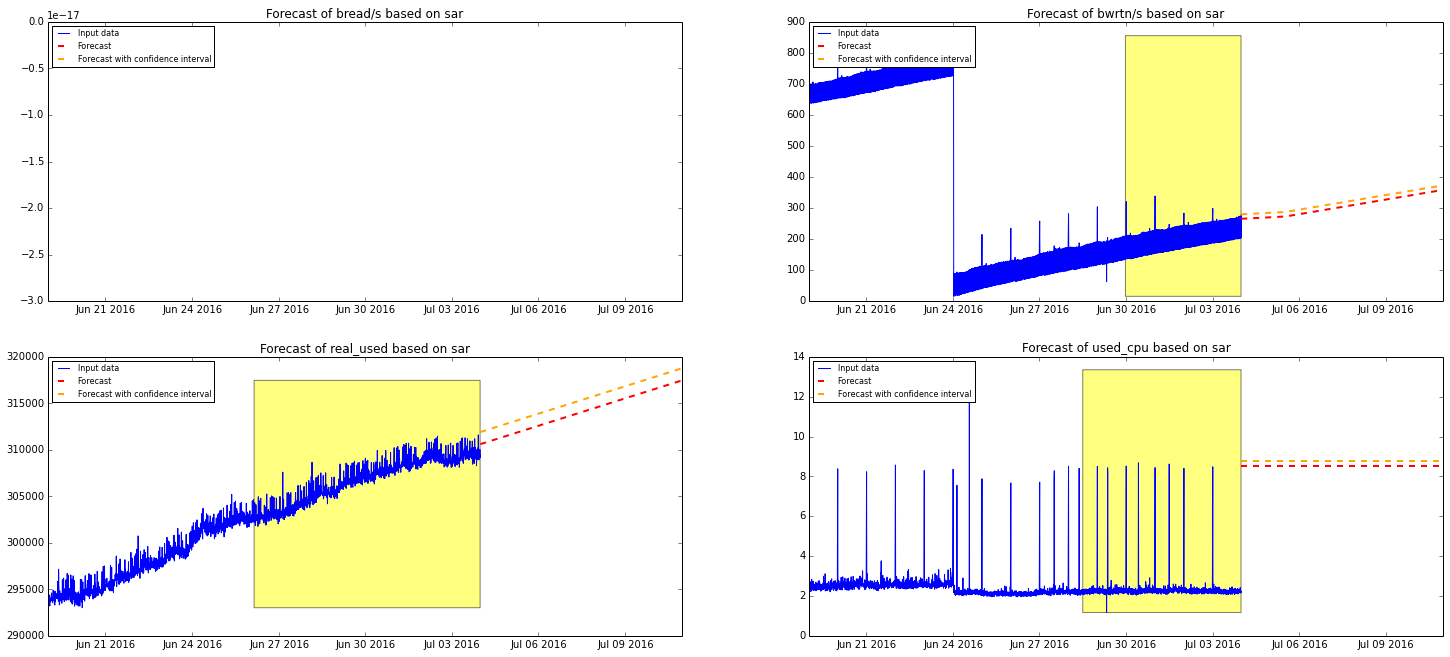

red104.eta.prod.ed5


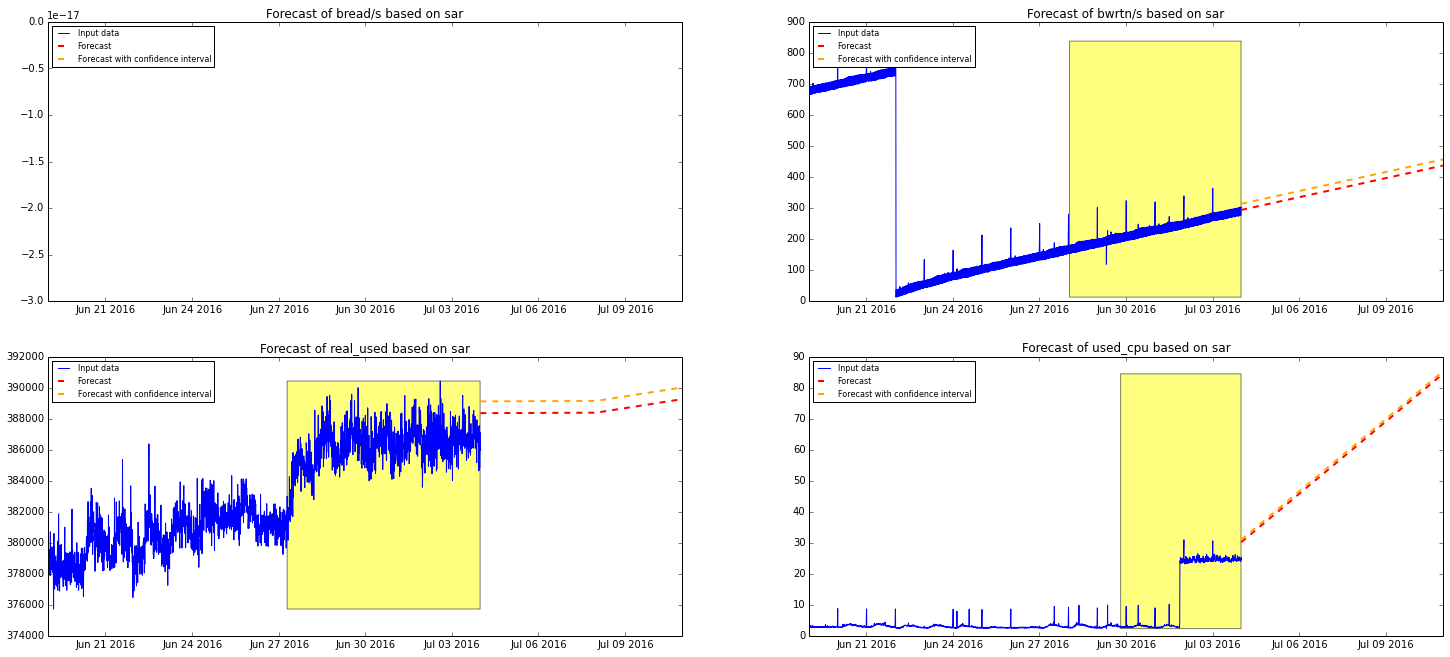

red105.eta.prod.ed5


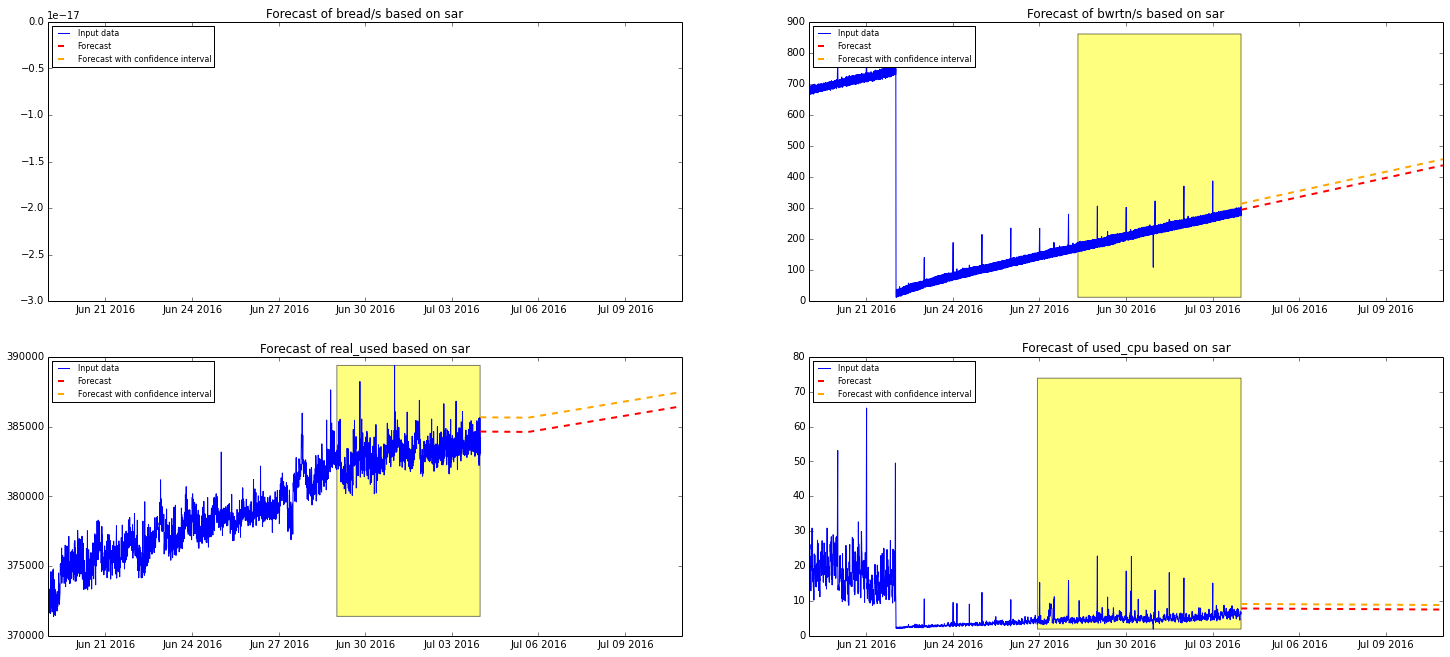

red106.eta.prod.ed5


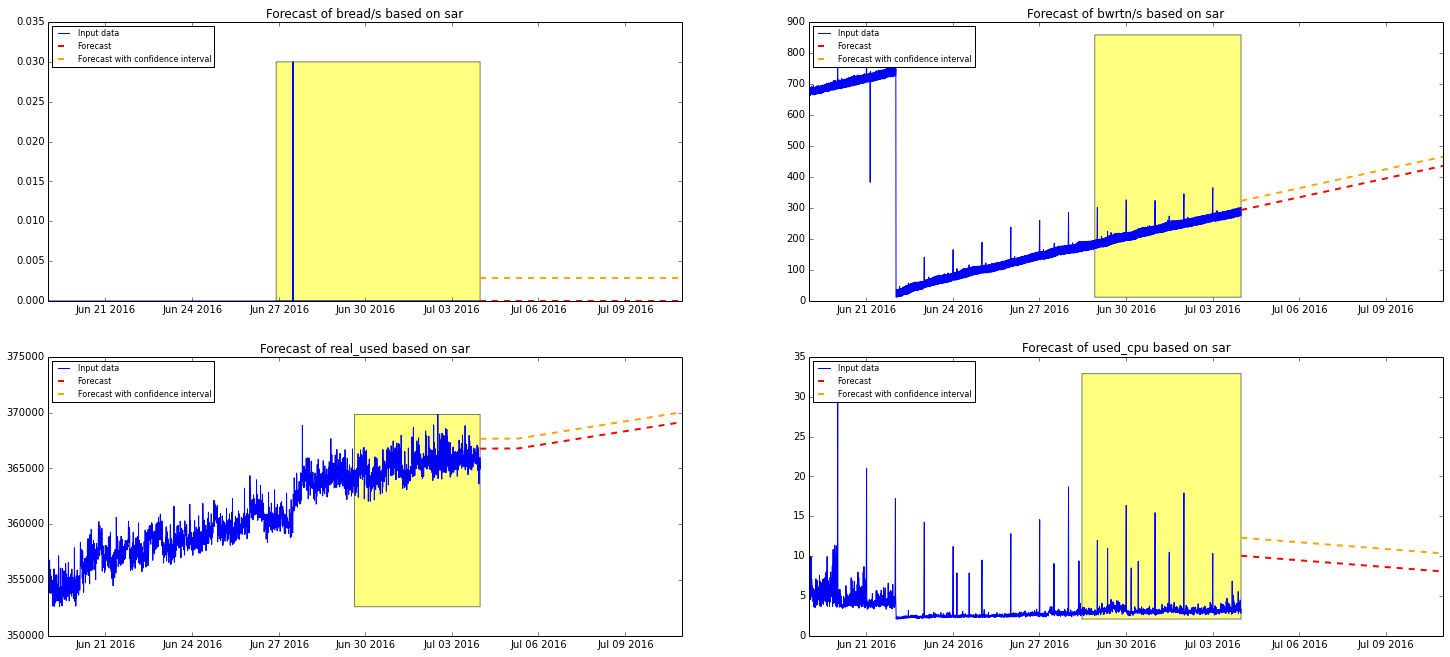

st101.eta.prod.ed1


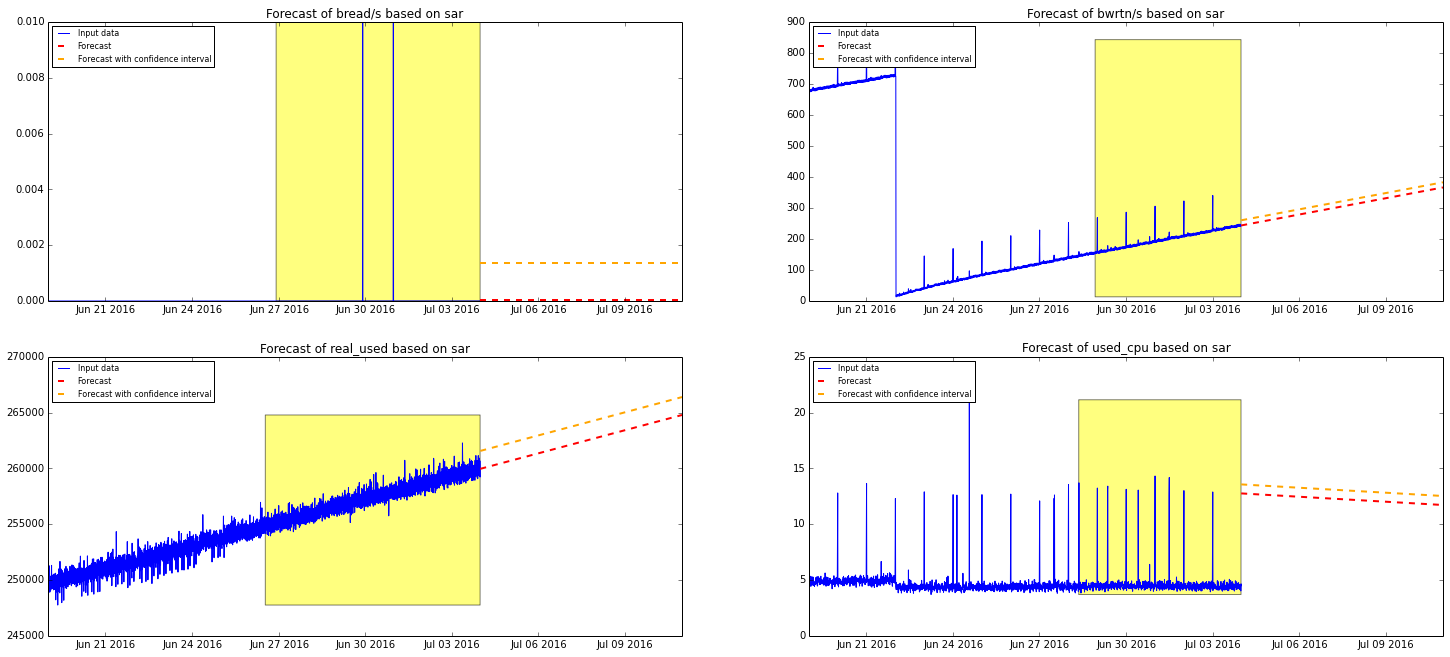

st102.eta.prod.ed1


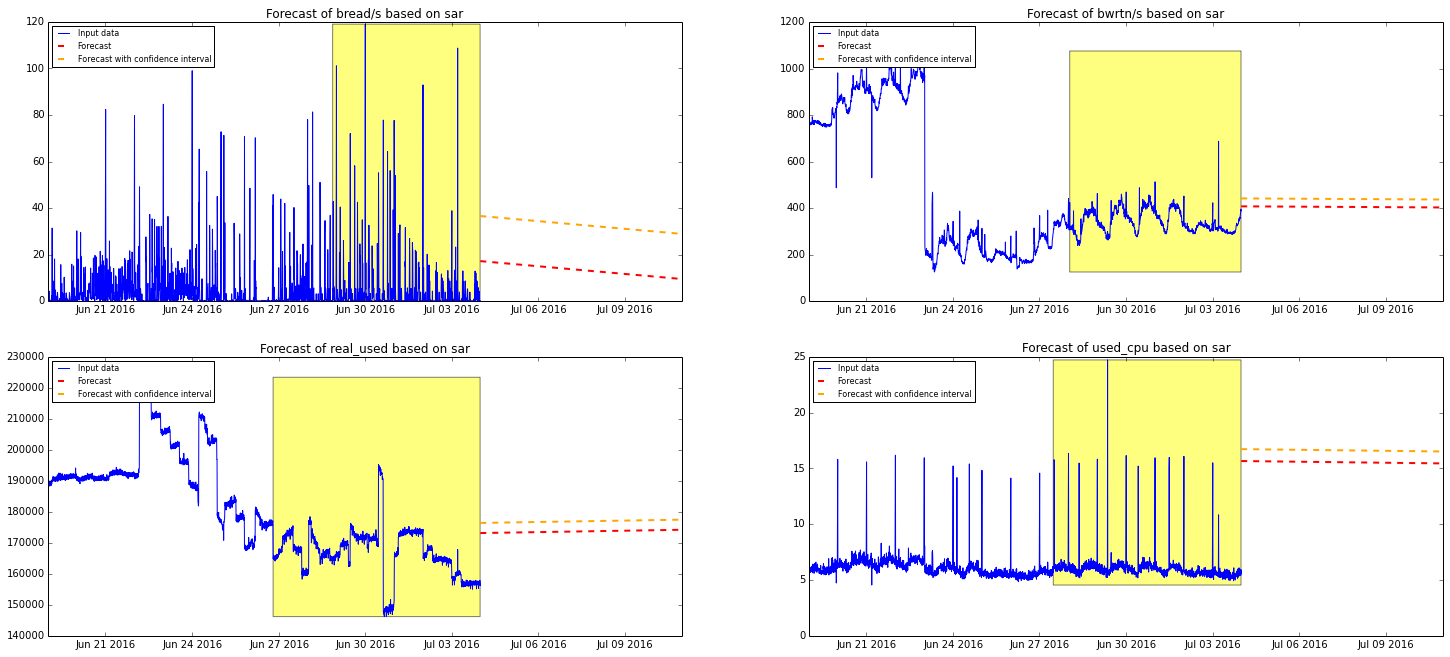

st101.eta.prod.ed5


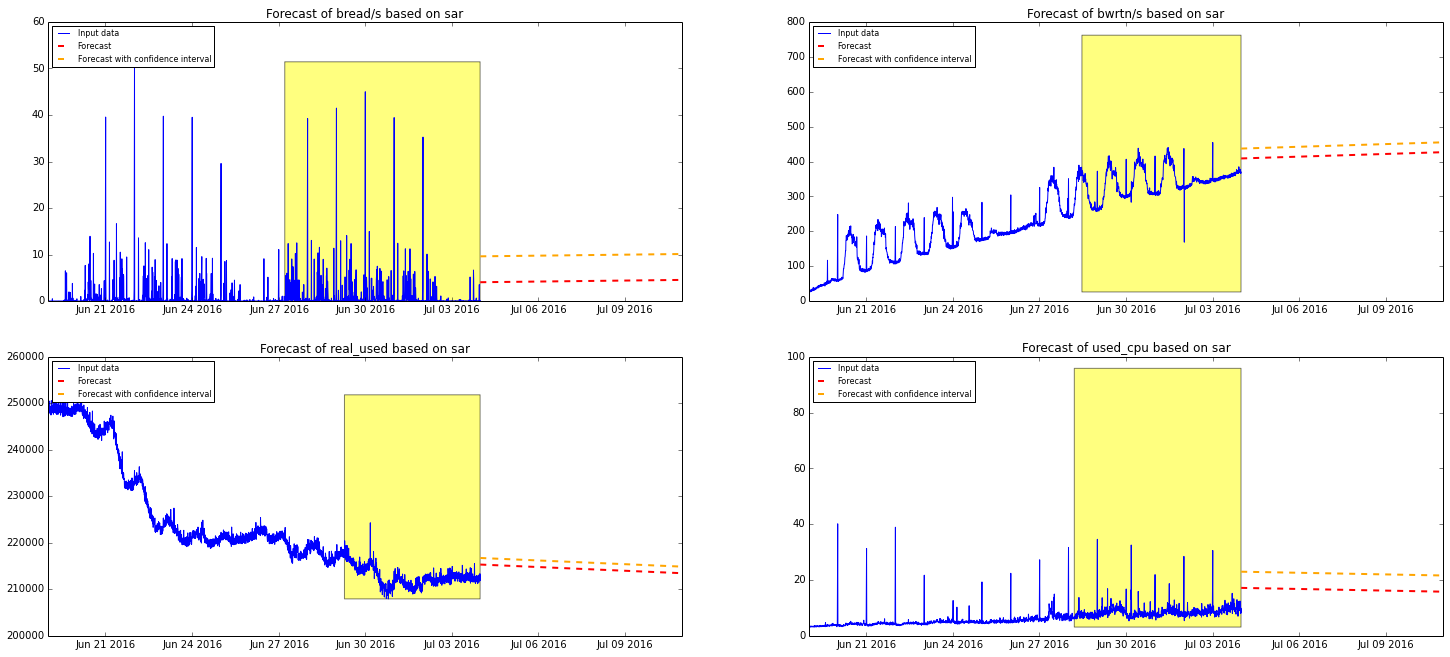

st102.eta.prod.ed5


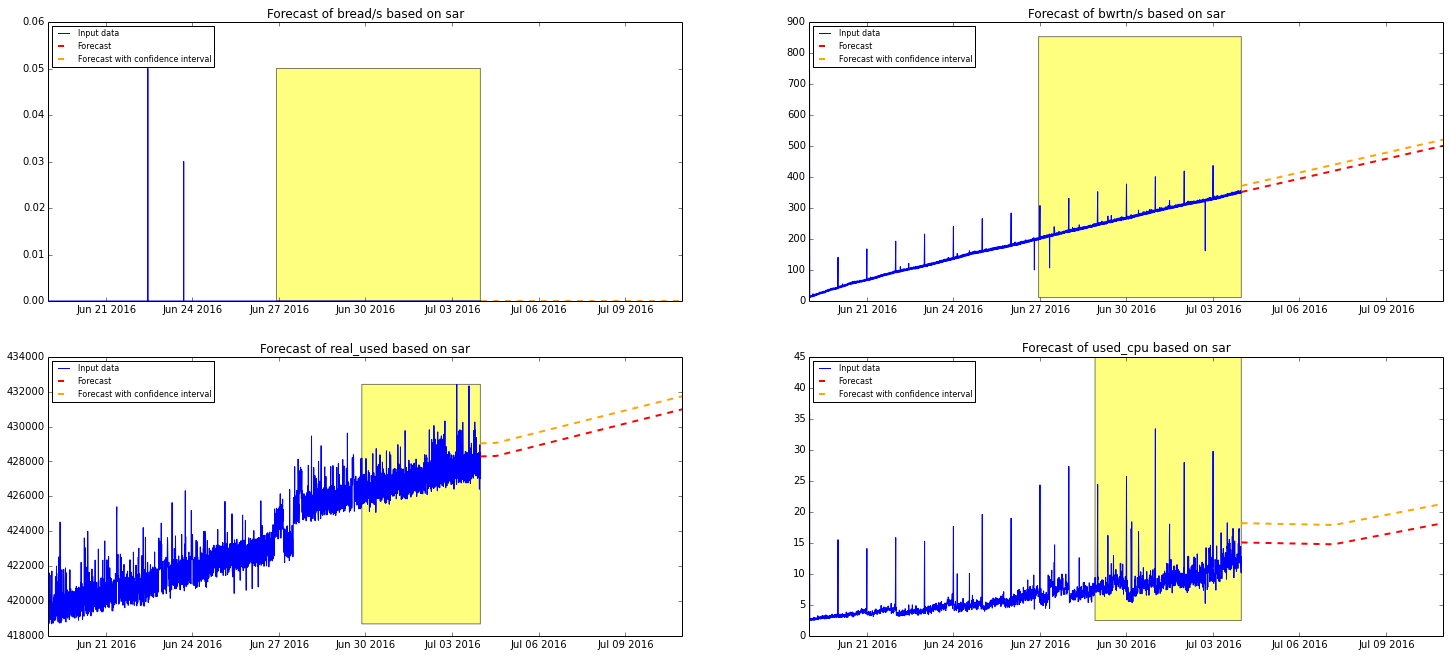

be101.etawf.prod.ed1


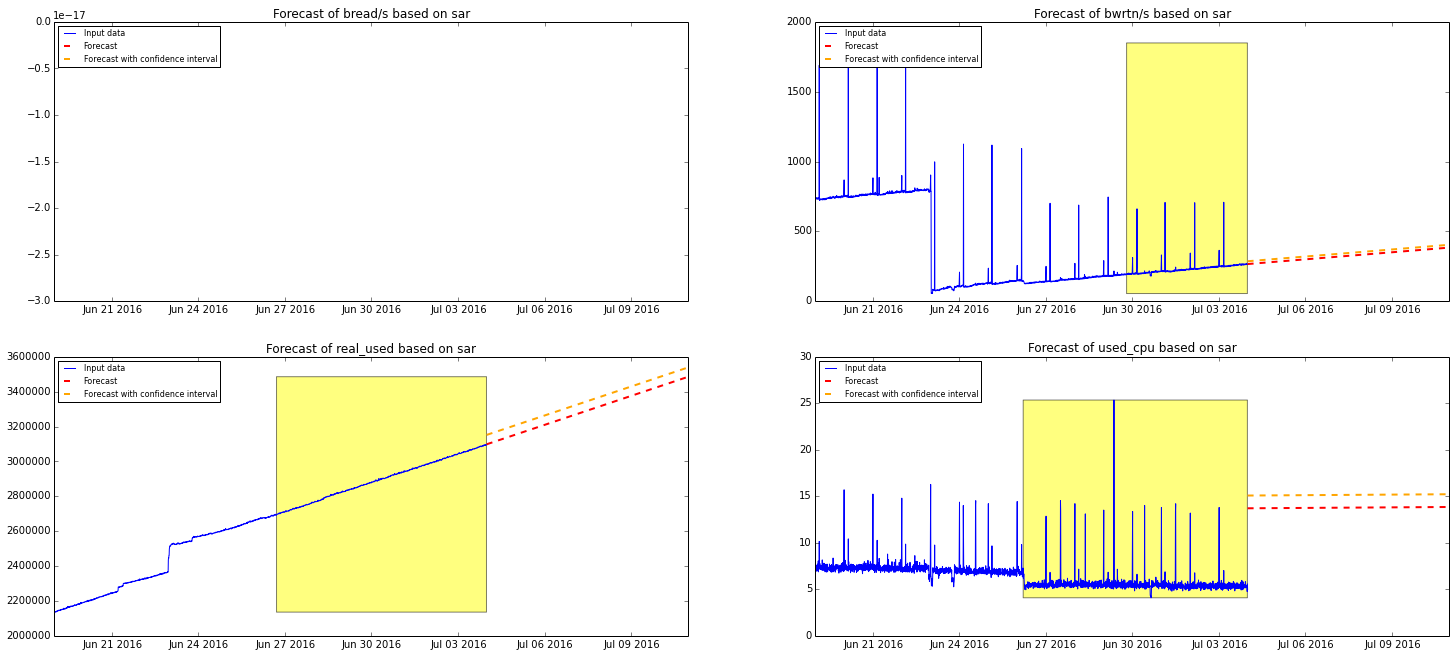

be102.etawf.prod.ed1


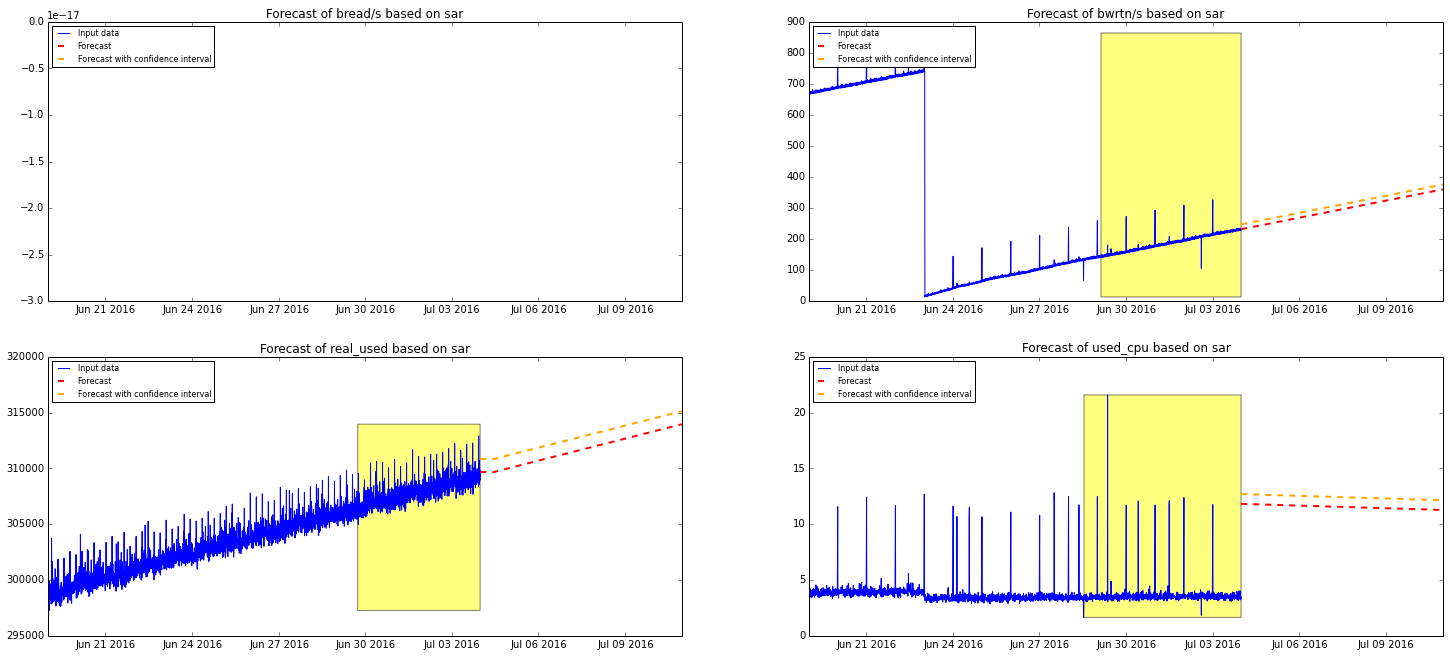

be101.etawf.prod.ed5


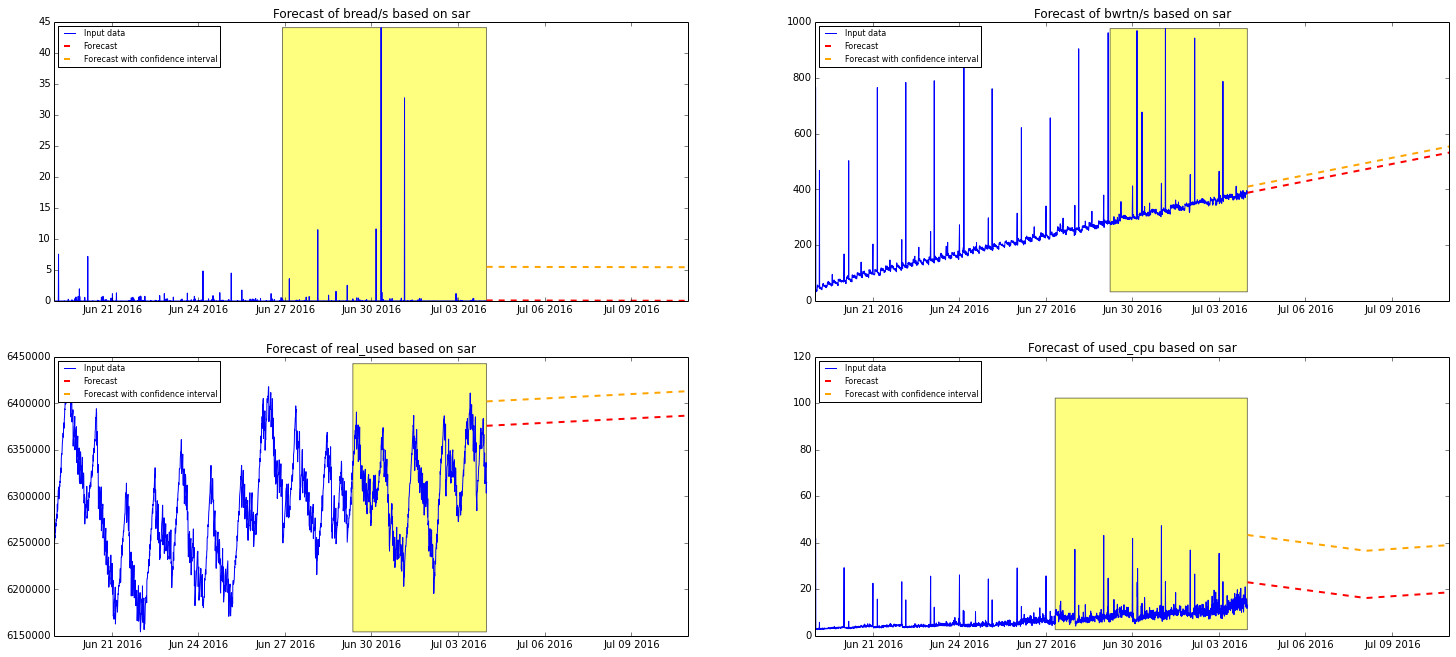

be102.etawf.prod.ed5


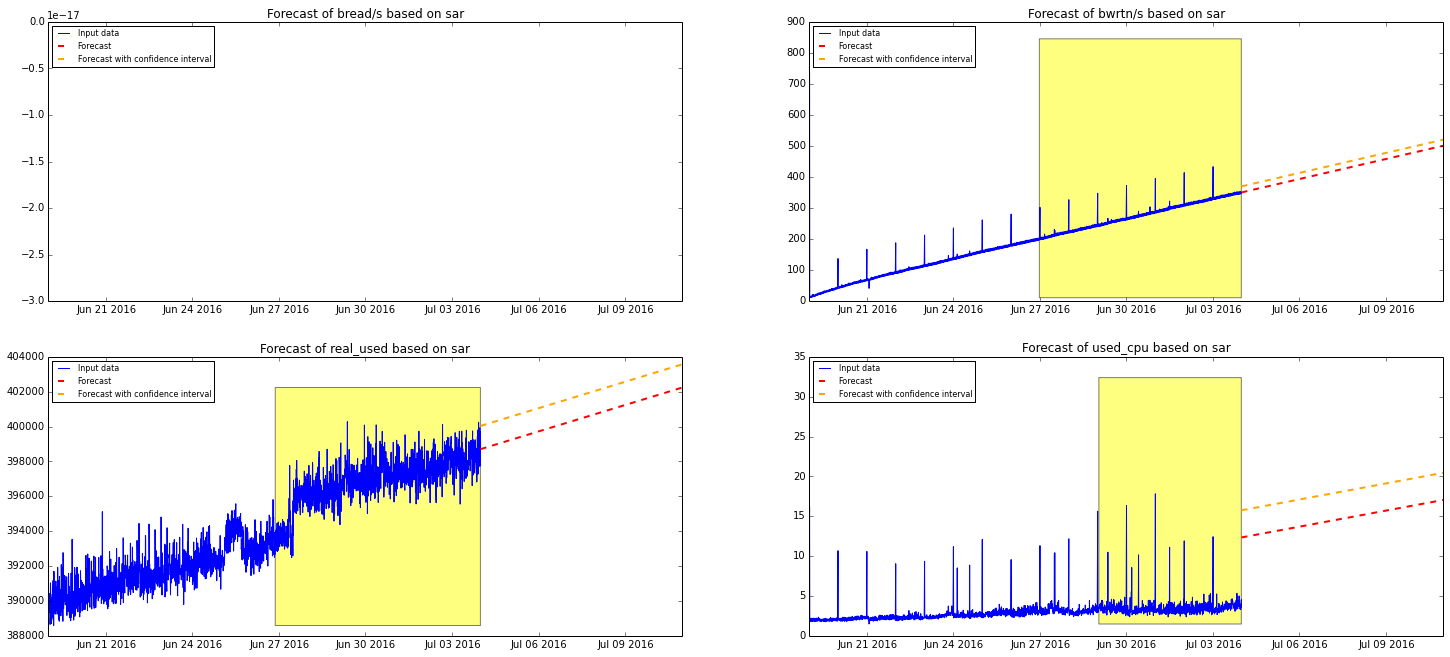

In [97]:
data=pd.read_csv(source_path+"SG5_hosts.csv")
data1=pd.read_csv(source_path+"/home/annac/POD16_2hosts.csv")
data.columns=['Group','server']
data1.columns=['Group','server']
data=data.append(data1)
data=data.reset_index()
data=data[['Group', 'server']]
gr=""
for i in data.index:
    if type(data['Group'].values[i])==float and np.isnan(data['Group'].values[i]):
        data['Group'][i]=gr
    else:
        gr=data['Group'][i]
data.columns=['group','server']

#Analyse data only for ETA
data=data[data.server.str.contains('eta')]
data=data.reset_index()
data=data[['Group', 'server']]

minsize=""
DF=pd.DataFrame()
start_d="2016-06-19 00:00:00 AM"
for i in data.index:
    d=data.iloc[i]
    host=d['server']
    print(host)
    #loading host data
    #if host not in os.listdir('/home/annac/tmp/'):
    #    r=get_host_data (host, user, password)
    #    if r==0:
    #        continue
    #    get_resource_tables(path+host)
    if host  in os.listdir(path) and host!='red002.lp.prod.ed1' and len(os.listdir(path+host))>30:
        if start_d=="":
            D=forecast_on_sar(host, user, start="2016-06-16 00:00:00 AM", plot_clust=False)
        else:
            D=forecast_on_sar(host, user, start=start_d, plot_clust=False)
        DF=DF.append(D)

#DF.to_csv(path+"Used_resources.csv")


In [165]:
DF.to_csv("/home/annac/Used_resources_POD_16_2.csv")
data.to_csv("/home/annac/Groups_Servers.csv")

In [101]:
data=data[['group', 'server']]

In [102]:
DF
data.columns=['Group','server']
DFR_CPU=pd.DataFrame()
DFR_RAM=pd.DataFrame()
for h in DF.index.unique():
    d=DF.loc[h]
    d=d[d['Param'].str.contains('real_used')]
    d=d[d.Used==max(d.Used)]
    DFR_RAM=DFR_RAM.append(d)
    d=DF.loc[h]
    d=d[d['Param']=='used_cpu']
    DFR_CPU=DFR_CPU.append(d)
DFR_RAM['server']=DFR_RAM.index.values
DFR_CPU['server']=DFR_CPU.index.values
DFR_RAM['Available']=[np.round(np.float16(DFR_RAM.loc[i]['Capacity'])-np.float16(DFR_RAM.loc[i]['Used']),2) \
                      for i in DFR_RAM.index]
DFR_CPU['Available']=[np.round(np.float16(DFR_CPU.loc[i]['Capacity'])*100-np.float16(DFR_CPU.loc[i]['Used'].replace(' %', '')),2) \
                      for i in DFR_CPU.index]
DFR_CPU=pd.merge(DFR_CPU, data)
DFR_RAM=pd.merge(DFR_RAM, data)
print(DFR_RAM.head())
print(DFR_CPU.head())

   Capacity         Details      Param  Resource Used               server  \
0        48  All data in GB  real_used  mem_data    9  app101.eta.prod.ed1   
1        48  All data in GB  real_used  mem_data    4  app102.eta.prod.ed1   
2        48  All data in GB  real_used  mem_data    7  app103.eta.prod.ed1   
3        48  All data in GB  real_used  mem_data    7  app104.eta.prod.ed1   
4        48  All data in GB  real_used  mem_data   10  app105.eta.prod.ed1   

   Available                               Group  
0         39  ETA-BE-APP.ETA-BE-APP-PROD-ED1-101  
1         44  ETA-BE-APP.ETA-BE-APP-PROD-ED1-101  
2         41  ETA-BE-APP.ETA-BE-APP-PROD-ED1-101  
3         41  ETA-BE-APP.ETA-BE-APP-PROD-ED1-101  
4         38  ETA-BE-APP.ETA-BE-APP-PROD-ED1-101  

[5 rows x 8 columns]
   Capacity                          Details     Param  Resource      Used  \
0         8  Used in %. All data ncores*100%  used_cpu  cpu_data   222.0 %   
1         8  Used in %. All data ncores*100%  u

In [103]:
D=get_resource_data('API-FE-PROD')
D.to_csv(path+"API-FE-PROD_stats.csv")

#### ETA-BE-APP-PROD group of hosts

ETA-BE-APP.ETA-BE-APP-PROD-ED1-101
                                Group  Number Resource  Sum_capacity  Sum_used
0  ETA-BE-APP.ETA-BE-APP-PROD-ED1-101      12   Memory           576      66.0
1  ETA-BE-APP.ETA-BE-APP-PROD-ED1-101      12      CPU          9600     904.5

[2 rows x 5 columns]
Summary CPU 
Used 9.421875 %
Summary RAM 
Used 11.4562988281 %
ETA-BE-APP.ETA-BE-APP-PROD-ED5-101
                                Group  Number Resource  Sum_capacity  Sum_used
0  ETA-BE-APP.ETA-BE-APP-PROD-ED5-101       4   Memory           192        24
1  ETA-BE-APP.ETA-BE-APP-PROD-ED5-101       4      CPU          3200       253

[2 rows x 5 columns]
Summary CPU 
Used 7.90625 %
Summary RAM 
Used 12.5 %


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:33: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


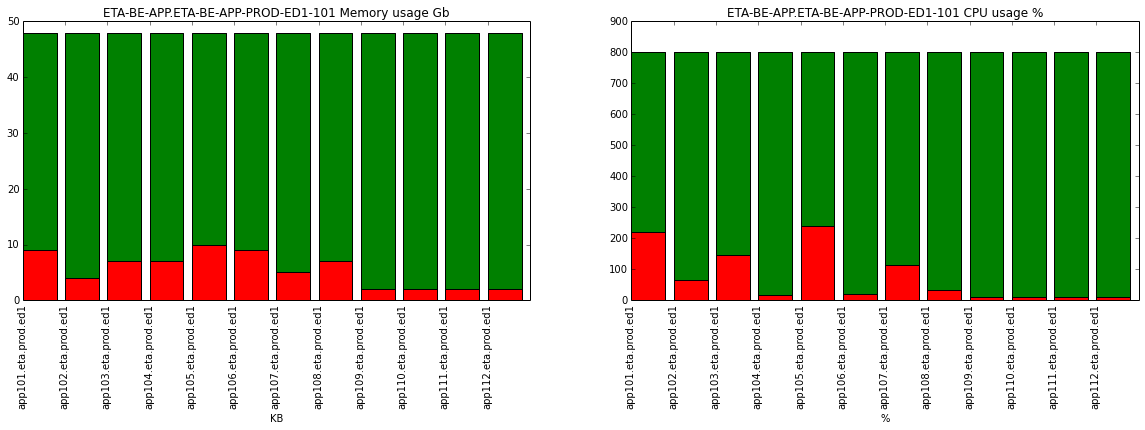

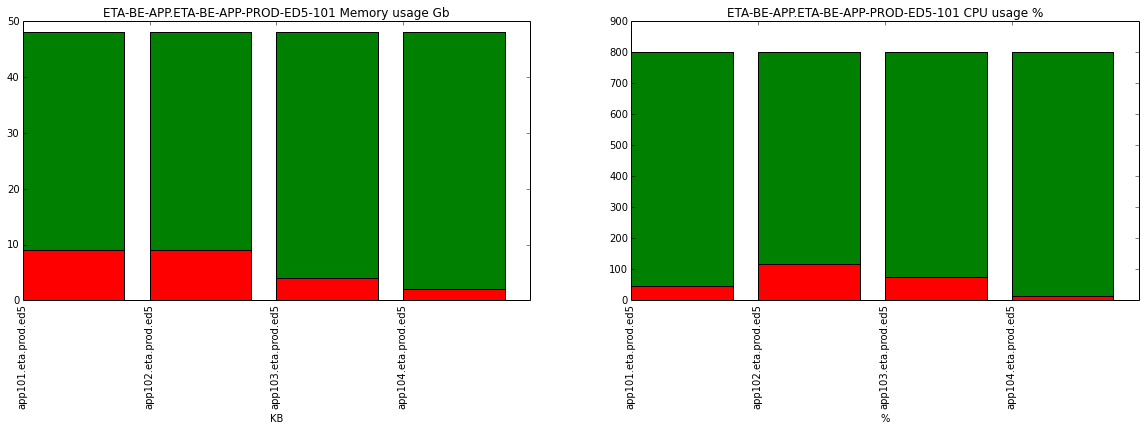

In [112]:
D=get_resource_data('ETA-BE-APP-PROD')
D.to_csv(path+"ETA-BE-APP-PROD_stats.csv")

### ETA-BE-CUSTOM group of hosts

ETA-BE-CUSTOM.ETA-BE-CUSTOM-PROD-ED1-101
                                      Group  Number Resource  Sum_capacity  \
0  ETA-BE-CUSTOM.ETA-BE-CUSTOM-PROD-ED1-101       2   Memory            32   
1  ETA-BE-CUSTOM.ETA-BE-CUSTOM-PROD-ED1-101       2      CPU           800   

   Sum_used  
0   4.00000  
1  33.96875  

[2 rows x 5 columns]
Summary CPU 
Used 4.24609375 %
Summary RAM 
Used 12.5 %
ETA-BE-CUSTOM.ETA-BE-CUSTOM-PROD-ED5-101
                                      Group  Number Resource  Sum_capacity  \
0  ETA-BE-CUSTOM.ETA-BE-CUSTOM-PROD-ED5-101       2   Memory            32   
1  ETA-BE-CUSTOM.ETA-BE-CUSTOM-PROD-ED5-101       2      CPU           800   

   Sum_used  
0    4.0000  
1   70.0625  

[2 rows x 5 columns]
Summary CPU 
Used 8.7578125 %
Summary RAM 
Used 12.5 %


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:33: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


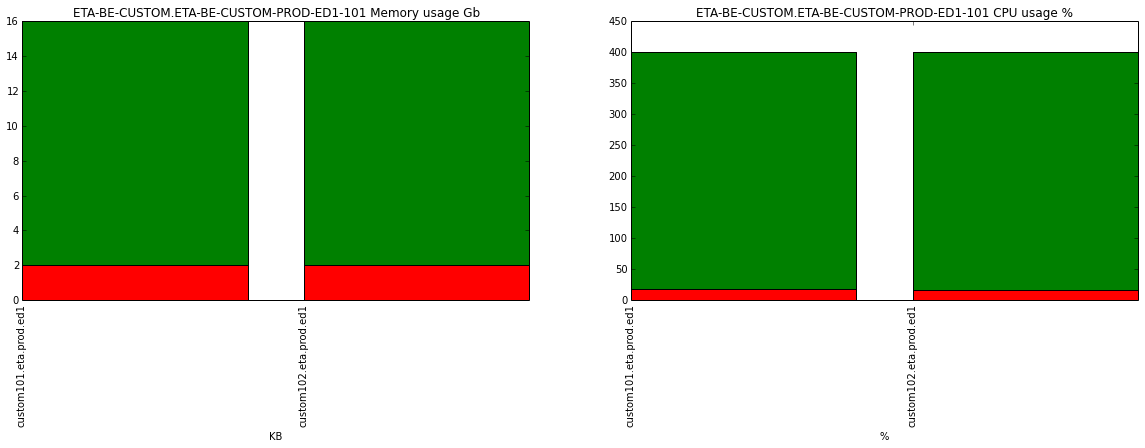

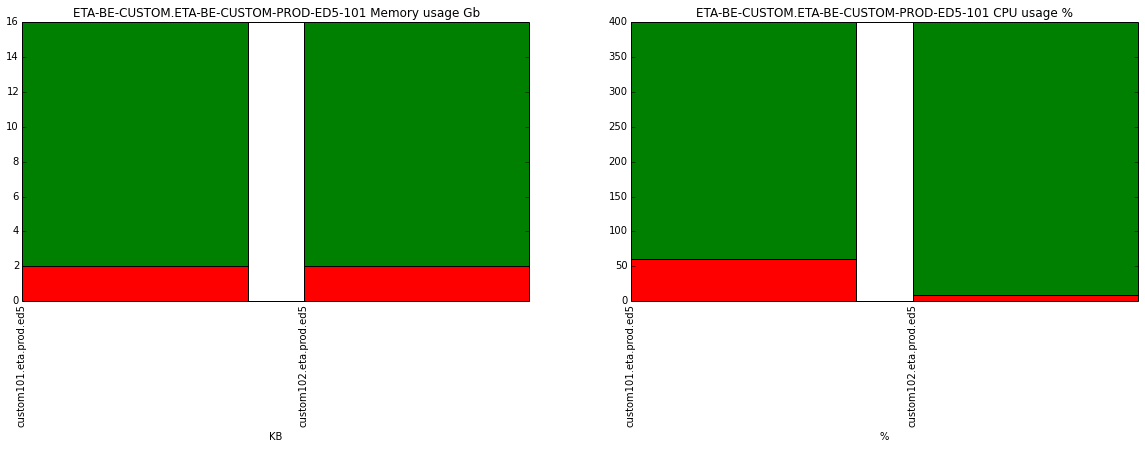

In [113]:
D=get_resource_data('ETA-BE-CUSTOM')
D.to_csv(path+"ETA-BE-CUSTOM_stats.csv")

### ETA-FE-PROD group 

ETA-FE.ETA-FE-PROD-ED1-101
                        Group  Number Resource  Sum_capacity  Sum_used
0  ETA-FE.ETA-FE-PROD-ED1-101      19   Memory           136      87.0
1  ETA-FE.ETA-FE-PROD-ED1-101      19      CPU          7600     374.5

[2 rows x 5 columns]
Summary CPU 
Used 4.92763157895 %
Summary RAM 
Used 63.96484375 %
ETA-FE.ETA-FE-PROD-ED5-101
                        Group  Number Resource  Sum_capacity  Sum_used
0  ETA-FE.ETA-FE-PROD-ED5-101       8   Memory            64     23.00
1  ETA-FE.ETA-FE-PROD-ED5-101       8      CPU          3200    232.25

[2 rows x 5 columns]
Summary CPU 
Used 7.2578125 %
Summary RAM 
Used 35.9375 %


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:33: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


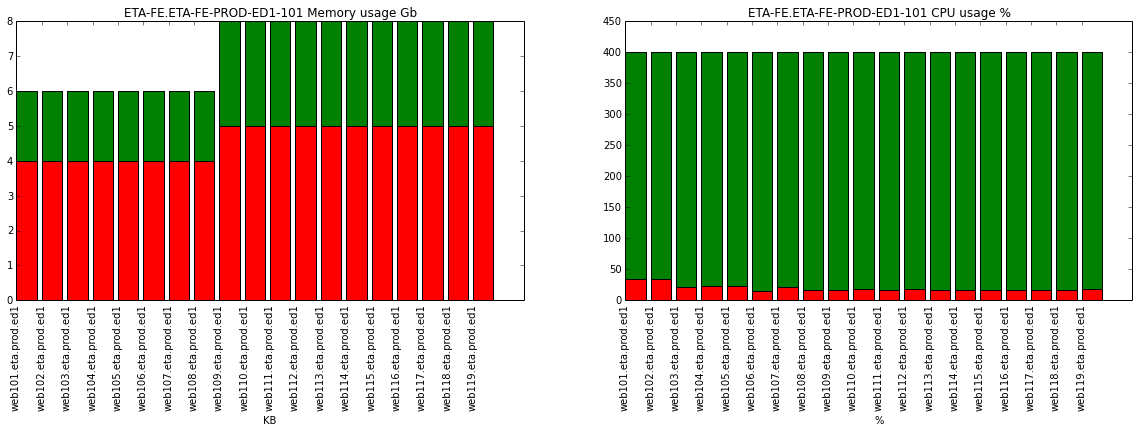

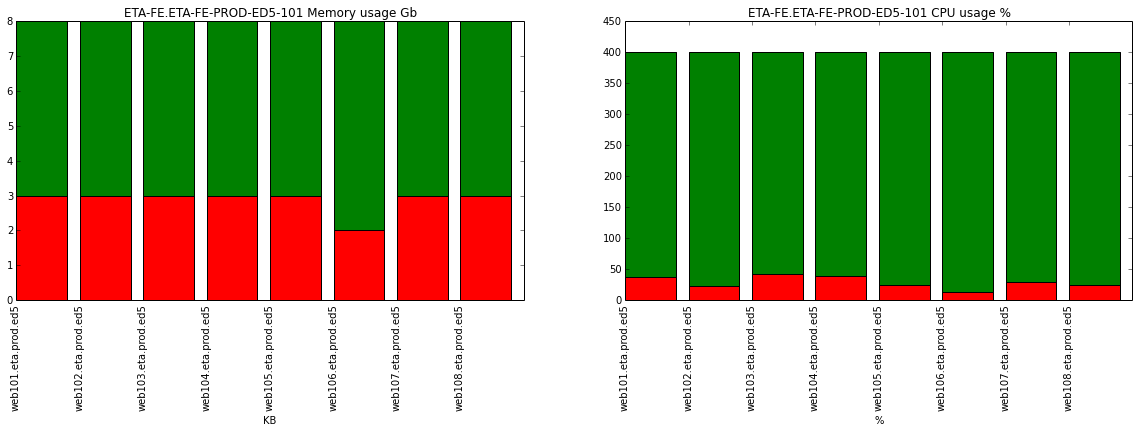

In [114]:
D=get_resource_data('ETA-FE-PROD')
D.to_csv(path+"ETA-BE-APP-PROD_stats.csv")

ETA-FE-SERVICES.ETA-FE-SERVICES-PROD-ED1-101
                                          Group  Number Resource  \
0  ETA-FE-SERVICES.ETA-FE-SERVICES-PROD-ED1-101       5   Memory   
1  ETA-FE-SERVICES.ETA-FE-SERVICES-PROD-ED1-101       5      CPU   

   Sum_capacity  Sum_used  
0            40   35.0000  
1          2000   86.9375  

[2 rows x 5 columns]
Summary CPU 
Used 4.346875 %
Summary RAM 
Used 87.5 %
ETA-FE-SERVICES.ETA-FE-SERVICES-PROD-ED5-101
                                          Group  Number Resource  \
0  ETA-FE-SERVICES.ETA-FE-SERVICES-PROD-ED5-101       4   Memory   
1  ETA-FE-SERVICES.ETA-FE-SERVICES-PROD-ED5-101       4      CPU   

   Sum_capacity  Sum_used  
0            32     28.00  
1          1600    168.25  

[2 rows x 5 columns]
Summary CPU 
Used 10.515625 %
Summary RAM 
Used 87.5 %


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:33: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


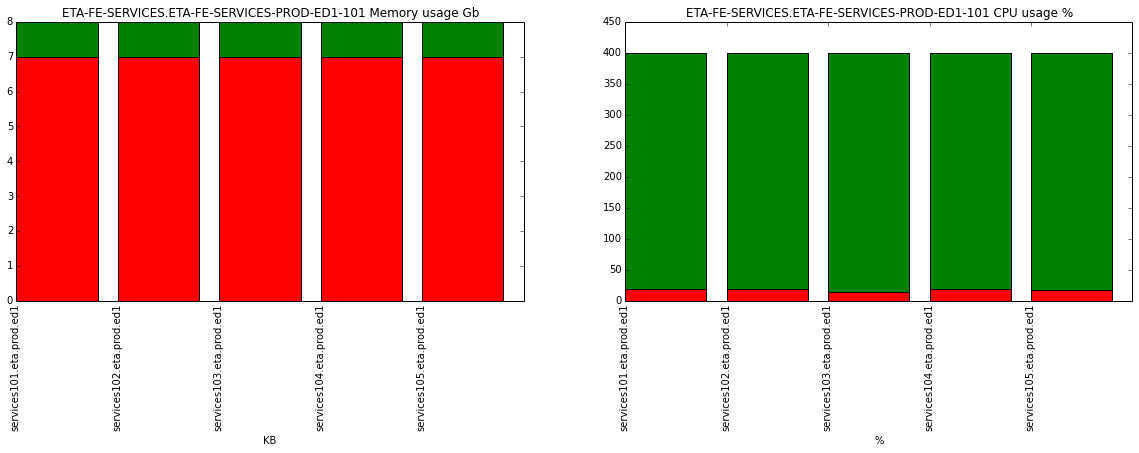

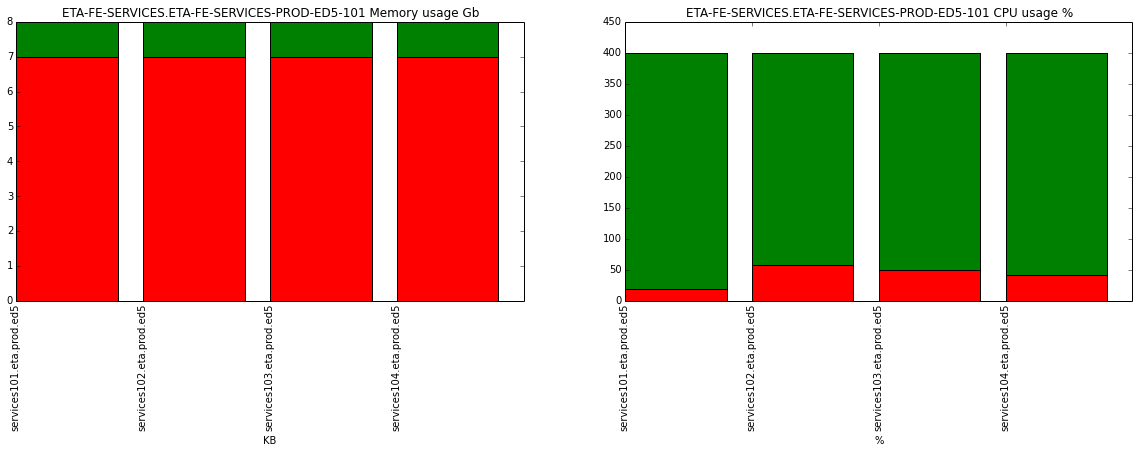

In [115]:
D=get_resource_data('ETA-FE-SERVICES')
D.to_csv(path+"ETA-FE-SERVICES.csv")

ETA-DB.ETA-DB-PROD-ED1-101
                        Group  Number Resource  Sum_capacity  Sum_used
0  ETA-DB.ETA-DB-PROD-ED1-101       2   Memory           504       137
1  ETA-DB.ETA-DB-PROD-ED1-101       2      CPU          9600       284

[2 rows x 5 columns]
Summary CPU 
Used 2.95833333333 %
Summary RAM 
Used 27.1728515625 %
ETA-DB.ETA-DB-PROD-ED5-101
                        Group  Number Resource  Sum_capacity  Sum_used
0  ETA-DB.ETA-DB-PROD-ED5-101       2   Memory           504    73.000
1  ETA-DB.ETA-DB-PROD-ED5-101       2      CPU          9600   122.125

[2 rows x 5 columns]
Summary CPU 
Used 1.27213541667 %
Summary RAM 
Used 14.4897460938 %


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:33: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


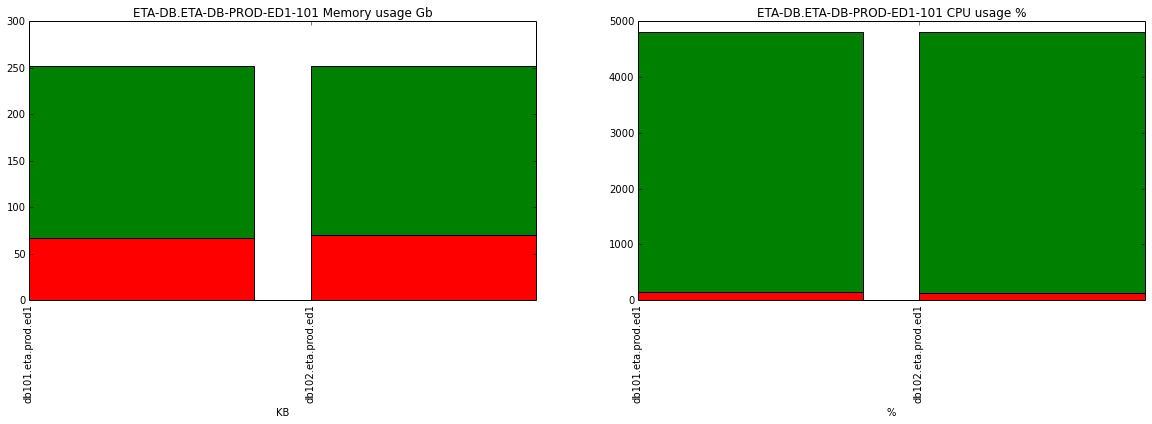

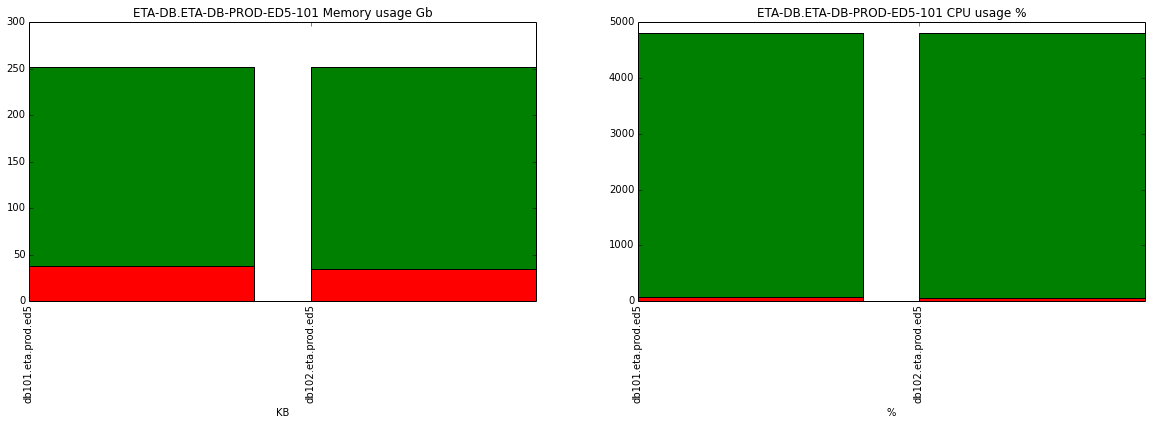

In [116]:
D=get_resource_data('ETA-DB-PROD')
D.to_csv(path+"ETA-DB-PROD.csv")


ETA-FS.ETA-FS-PROD-ED1-101
                        Group  Number Resource  Sum_capacity  Sum_used
0  ETA-FS.ETA-FS-PROD-ED1-101       2   Memory           504    32.000
1  ETA-FS.ETA-FS-PROD-ED1-101       2      CPU          9600    81.625

[2 rows x 5 columns]
Summary CPU 
Used 0.850260416667 %
Summary RAM 
Used 6.34765625 %
ETA-FS.ETA-FS-PROD-ED5-101
                        Group  Number Resource  Sum_capacity  Sum_used
0  ETA-FS.ETA-FS-PROD-ED5-101       2   Memory           504   16.0000
1  ETA-FS.ETA-FS-PROD-ED5-101       2      CPU          9600   57.4375

[2 rows x 5 columns]
Summary CPU 
Used 0.598307291667 %
Summary RAM 
Used 3.173828125 %


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:33: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


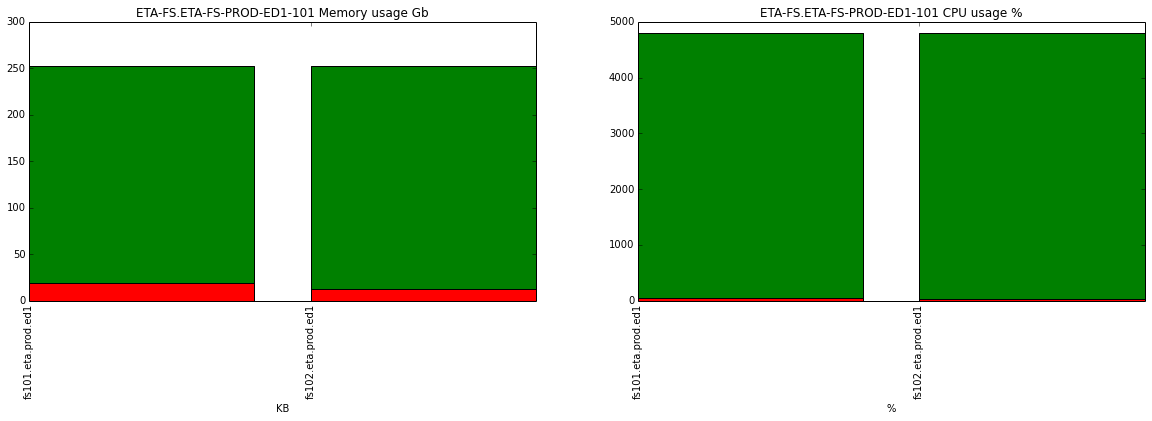

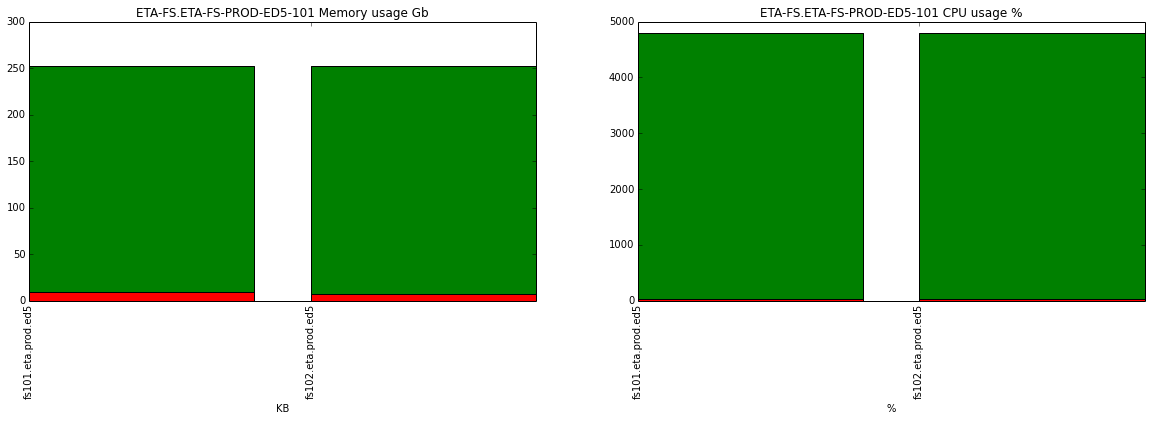

In [117]:
D=get_resource_data('ETA-FS-PROD')
D.to_csv(path+"ETA-FS-PROD.csv")

ETAWF-BE.ETAWF-BE-PROD-ED1-101
                            Group  Number Resource  Sum_capacity  Sum_used
0  ETAWF-BE.ETAWF-BE-PROD-ED1-101       2   Memory            16   4.00000
1  ETAWF-BE.ETAWF-BE-PROD-ED1-101       2      CPU           800  28.53125

[2 rows x 5 columns]
Summary CPU 
Used 3.56640625 %
Summary RAM 
Used 25.0 %
ETAWF-BE.ETAWF-BE-PROD-ED5-101
                            Group  Number Resource  Sum_capacity  Sum_used
0  ETAWF-BE.ETAWF-BE-PROD-ED5-101       2   Memory            16   8.00000
1  ETAWF-BE.ETAWF-BE-PROD-ED5-101       2      CPU           800  49.90625

[2 rows x 5 columns]
Summary CPU 
Used 6.23828125 %
Summary RAM 
Used 50.0 %


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:33: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


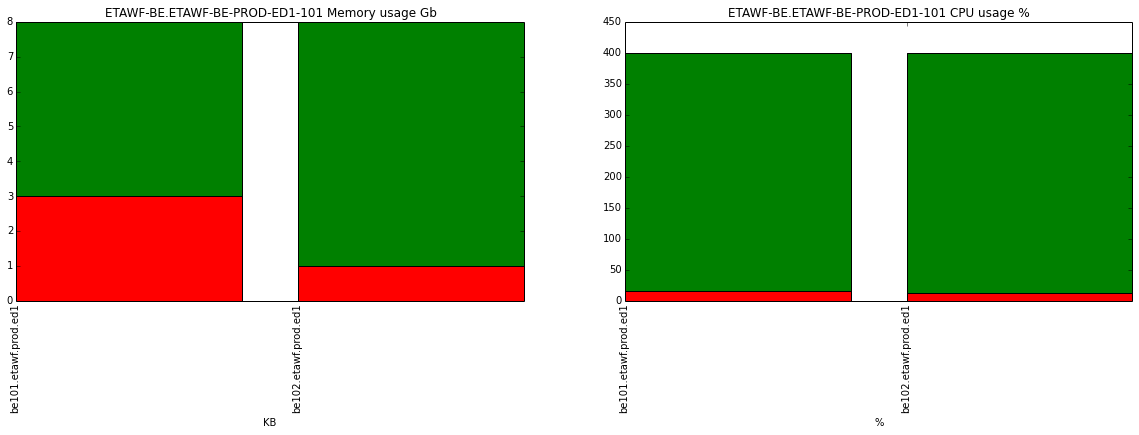

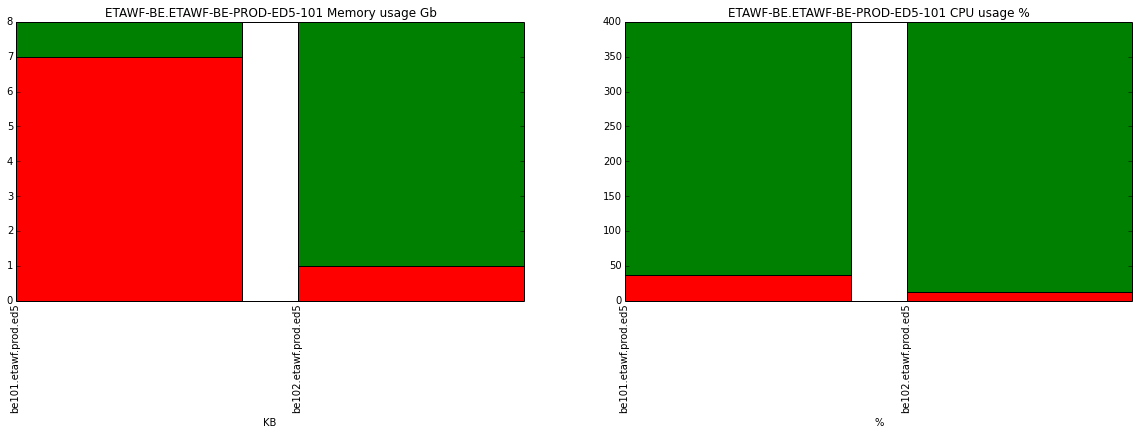

In [118]:
D=get_resource_data('ETAWF-BE-PROD')
D.to_csv(path+'ETAWF-BE-PROD')

In [27]:
data=pd.read_csv("/home/annac/POD16_2hosts.csv", sep="\t")
H=data.server.unique()
user="annac"
password="ITssa2016"
minsize=""
print (data.columns)
DF=pd.DataFrame()
host='app102.eta.prod.ed1'
get_resource_tables(path+host)

Index([u'Group', u'server'], dtype='object')


In [152]:
DFR_CPU_d=DFR_CPU[['Capacity', 'Details', 'Resource','Used', 'server', 'Available']]
DFR_CPU_d.columns=['Capacity_cpu', 'Details_cpu', 'Resource','Used_cpu', 'server', 'Available_cpu']
DFR_RAM_d=DFR_RAM[['Capacity', 'Details', 'Resource','Used', 'server', 'Available', 'Group']]
DFR_RAM_d.columns=['Capacity_mem', 'Details_mem', 'Resource','Used_mem', 'server', 'Available_mem', 'Group']
D=DFR_CPU_d.merge(DFR_RAM_d, on='server')
RES=pd.DataFrame()
for G in D.Group.unique():
    d=D[D.Group==G]
    d['util_mem']=100*d['Used_mem']/d['Capacity_mem']
    d['util_cpu']=[np.float16(x.replace(' %','')) for x in d['Used_cpu']]
    min_util_mem=min(d['util_mem'])
    max_util_mem=max(d['util_mem'])
    avg_util_mem=100*(sum(d['Used_mem'])/sum(d['Capacity_mem']))
    s=d['Capacity_mem'].unique()
    mem_per_fost=','.join(str(x) for x in s )
    RES=RES.append({'Server_class':G, 'Number_of_hosts':d.shape[0],'Mem_min_utilized':min_util_mem, 'Mem_max_utilized':max_util_mem, 'Mem_avg_clust':avg_util_mem, 'Config_mem':mem_per_fost},ignore_index=True)
RES.to_csv('/home/annac/Result for ETA classes.csv')

In [154]:
(RES)

Config_mem  Mem_avg_clust  Mem_max_utilized  Mem_min_utilized  \
0        48.0      11.458333         20.833333          4.166667   
1        48.0      12.500000         18.750000          4.166667   
2        16.0      12.500000         12.500000         12.500000   
3        16.0      12.500000         12.500000         12.500000   
4       252.0      27.182540         27.777778         26.587302   
5       252.0      14.484127         15.079365         13.888889   
6     6.0,8.0      63.970588         66.666667         62.500000   
7         8.0      35.937500         37.500000         25.000000   
8         8.0      87.500000         87.500000         87.500000   
9         8.0      87.500000         87.500000         87.500000   
10      252.0       6.349206          7.539683          5.158730   
11      252.0       3.174603          3.571429          2.777778   
12       32.0      26.562500         50.000000          3.125000   
13       32.0       4.687500          6.250000          3.125000   
14       24.0       4.166667          4.166667          4.166667   
15       24.0       4.166667          4.166667          4.166667   
16        8.0      12.500000         12.500000         12.500000   
17        8.0      12.500000         12.500000         12.500000   
18        2.0      50.000000         50.000000         50.000000   
19        2.0      50.000000         50.000000         50.000000   
20        8.0      25.000000         37.500000         12.500000   
21        8.0      50.000000         87.500000         12.500000   

    Number_of_hosts                                  Server_class  
0                12            ETA-BE-APP.ETA-BE-APP-PROD-ED1-101  
1                 4            ETA-BE-APP.ETA-BE-APP-PROD-ED5-101  
2                 2      ETA-BE-CUSTOM.ETA-BE-CUSTOM-PROD-ED1-101  
3                 2      ETA-BE-CUSTOM.ETA-BE-CUSTOM-PROD-ED5-101  
4                 2                    ETA-DB.ETA-DB-PROD-ED1-101  
5                 2                    ETA-DB.ETA-DB-PROD-ED5-101  
6                19                    ETA-FE.ETA-FE-PROD-ED1-101  
7                 8                    ETA-FE.ETA-FE-PROD-ED5-101  
8                 5  ETA-FE-SERVICES.ETA-FE-SERVICES-PROD-ED1-101  
9                 4  ETA-FE-SERVICES.ETA-FE-SERVICES-PROD-ED5-101  
10                2                    ETA-FS.ETA-FS-PROD-ED1-101  
11                2                    ETA-FS.ETA-FS-PROD-ED5-101  
12                2                    ETA-HA.ETA-HA-PROD-ED1-101  
13                2                    ETA-HA.ETA-HA-PROD-ED5-101  
14                3  ETA-RED-HISTORY.ETA-RED-HISTORY-PROD-ED1-101  
15                3  ETA-RED-HISTORY.ETA-RED-HISTORY-PROD-ED5-101  
16                3  ETA-RED-SESSION.ETA-RED-SESSION-PROD-ED1-101  
17                3  ETA-RED-SESSION.ETA-RED-SESSION-PROD-ED5-101  
18                2                    ETA-ST.ETA-ST-PROD-ED1-101  
19                2                    ETA-ST.ETA-ST-PROD-ED5-101  
20                2                ETAWF-BE.ETAWF-BE-PROD-ED1-101  
21                2                ETAWF-BE.ETAWF-BE-PROD-ED5-101  

[22 rows x 6 columns]